In [ ]:
import re
import shutil
import textwrap
import unicodedata
from collections import Counter
from pathlib import Path
from typing import Optional

import matplotlib
import matplotlib.pyplot as plt
import missingno as msno
import nltk
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import rcParams
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [ ]:
sns.set_style("whitegrid")
sns.set_context("talk")

In [ ]:
def download_file(url:str, local_filename:Optional[str]=None):
    Path(local_filename).parent.mkdir(exist_ok=True, parents=True)
    if local_filename is None:
      local_filename = url.split('/')[-1]
    with requests.get(url, stream=True) as r:
        with open(local_filename, 'wb') as f:
            shutil.copyfileobj(r.raw, f)
    return local_filename

In [ ]:
def unzip_file(path_to_zip_file:str, directory_to_extract_to:str):
  shutil.unpack_archive(path_to_zip_file, directory_to_extract_to)

In [ ]:
def wrap_labels(ax:matplotlib.axes.Axes, width:int, break_long_words:bool = False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

In [ ]:
def barplot_with_percentages(**kwargs):
    data = kwargs.get('data')
    y = kwargs.get('y')
    ax = sns.barplot(**kwargs)

    percentage = (data[y].sort_values(ascending=False)/data[y].sum() * 100).to_list()
    patches = ax.patches
    if len(patches) > 20:
        fontsize = ax.yaxis.label.get_fontsize() - 2
    else:
        fontsize = ax.yaxis.label.get_fontsize()
    for i in range(len(patches)):
        # Reduce annotation clutter if there are too many values to annotate
        if len(patches) <= 40 or i%2==0:
            x = patches[i].get_x() + patches[i].get_width()/2
            y = patches[i].get_height()+.06
            # Show only whole number part if percentage is too small
            if percentage[i] > 0.01:
                ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center', fontsize=fontsize)
            else:
                ax.annotate('{:.0f}%'.format(percentage[i]), (x, y), ha='center', fontsize=fontsize)
    return ax

In [ ]:
# Text-related functionality
def remove_stop_words(string_data:str, extra_stop_words:list=[]) -> str:
    stop_words = stopwords.words('spanish')
    stop_words.extend(extra_stop_words)
    string_data = re.sub(r'\b(' + r'|'.join(stop_words) + r')\b\s*', '', string_data)
    return string_data

def remove_characters(string_data:str, character_list:list)-> str:
    for character in character_list:
        string_data = string_data.replace(character, '')
    return string_data

def convert_to_long_string(series_data:pd.Series) -> str:
    regex_compile = re.compile(r'[^A-Za-z ]')
    string_data = series_data.str.replace(regex_compile, '', regex=True).str.cat(sep=' ').lower()

    string_data = remove_stop_words(string_data)
    string_data = remove_characters(string_data, ['-', ','])
    string_data = re.sub(' {2,}', ' ', string_data)
    return string_data

def strip_accents(accented_string:str) -> str:
  clean_string = unicodedata.normalize('NFD', accented_string) \
            .encode('ascii', 'ignore') \
            .decode("utf-8")
  return clean_string

def find_top_k_words(string_value:str, k:int=5) -> list:
  string_value = str(string_value).lower()
  # Some text cleaning
  string_value = remove_stop_words(string_value)
  string_value = remove_characters(string_value, ['-', ','])
  # Split into lists for the counter
  split_it = string_value.split()
  counter = Counter(split_it)
  most_common = counter.most_common(k)
  return most_common

In [ ]:
# Check if the data already exists, if not, download and unzip it
data_path = Path('data')
if not (data_path / 'laboratorios.csv').is_file() and not (data_path / 'notas.csv').is_file() and not (data_path / 'sociodemografico.csv').is_file():
  data_zip = download_file('https://www.dropbox.com/sh/xgs3kyvyn7lmr6p/AACB4eORnqsJpRsjv9-56eUHa?dl=1', 'data/data.zip')
  unzip_file(data_zip, data_path)
  unzip_file(data_path / 'Diana Buitrago - IQVIA_NLPmediaclNotes_DianaBuitrago.zip', data_path)

# Datasets analysis

## Sociodemografico file

In [ ]:
sociodemografico = pd.read_csv(str(data_path / "sociodemografico.csv"),sep=';')
sociodemografico.sample(5)

IDRecord  Edad  Genero  \
4683     97943    28  Hombre   
6018    121904    42  Hombre   
5667     84642    25  Hombre   
8668    139713    45  Hombre   
724      42055    33  Hombre   

                                            GrupoEtnico AreaResidencial  \
4683                                             Blanco     Zona Urbana   
6018                                           Indígena     Zona Urbana   
5667                                            Mestizo     Zona Urbana   
8668                                            Mestizo     Zona Urbana   
724   Negro, Mulato, Afrocolombiano o Afro descendiente      Zona Rural   

      EstadoCivil TSangre  
4683      Soltero      O+  
6018          NaN     NaN  
5667      Soltero      O+  
8668          NaN     NaN  
724   Desconocido     NaN

In [ ]:
sociodemografico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9306 entries, 0 to 9305
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   IDRecord         9306 non-null   int64 
 1   Edad             9306 non-null   int64 
 2   Genero           9306 non-null   object
 3   GrupoEtnico      9306 non-null   object
 4   AreaResidencial  9306 non-null   object
 5   EstadoCivil      8751 non-null   object
 6   TSangre          3801 non-null   object
dtypes: int64(2), object(5)
memory usage: 509.0+ KB


### Numerical Features Analysis

In [ ]:
sociodemografico.describe()

IDRecord         Edad
count    9306.000000  9306.000000
mean    86430.407264    47.509349
std     41221.689013    20.123695
min         5.000000    17.000000
25%     47726.000000    31.000000
50%     87220.000000    41.000000
75%    109563.000000    61.000000
max    206307.000000   105.000000

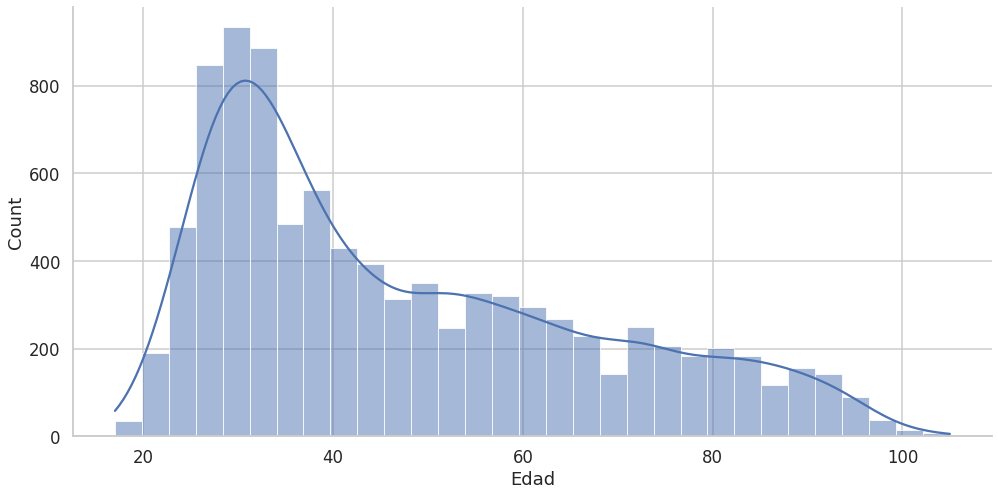

In [ ]:
p = sns.displot(data=sociodemografico, x="Edad", kde=True)
p.fig.set_figwidth(18)
p.fig.set_figheight(8)
p.savefig('Hist.png',bbox_inches='tight',dpi=600)

TODO (Marcelo Alias Steven) Talk about Age, mean, STD, Boxplot, histogram

### Null value analysis

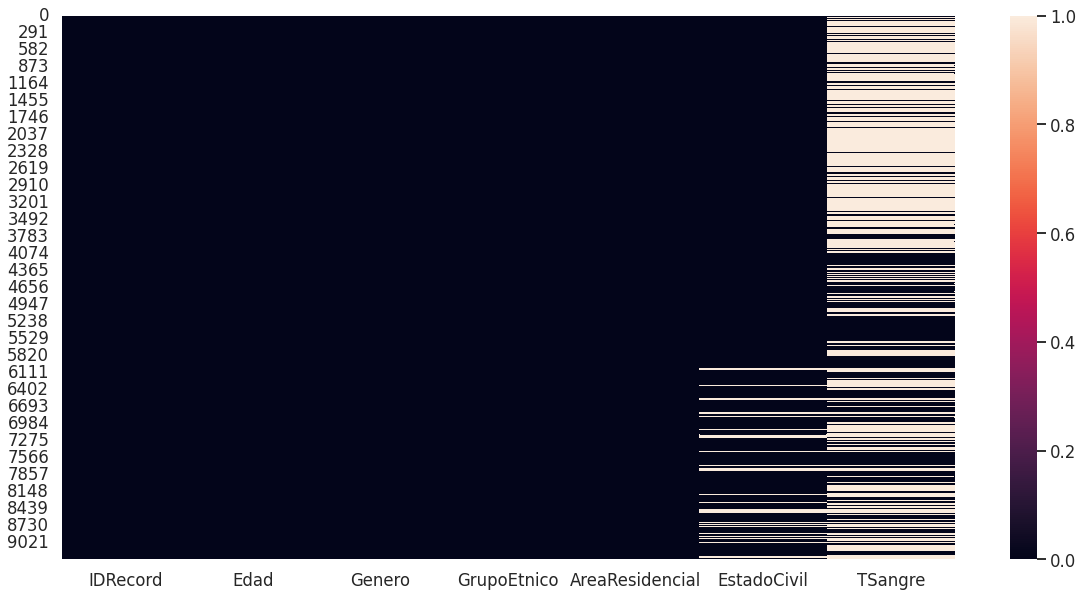

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
_ = sns.heatmap(sociodemografico.isnull(), ax = ax)
plt.savefig('NULLSoc.png',bbox_inches='tight',dpi=600)

### Categorical features analysis

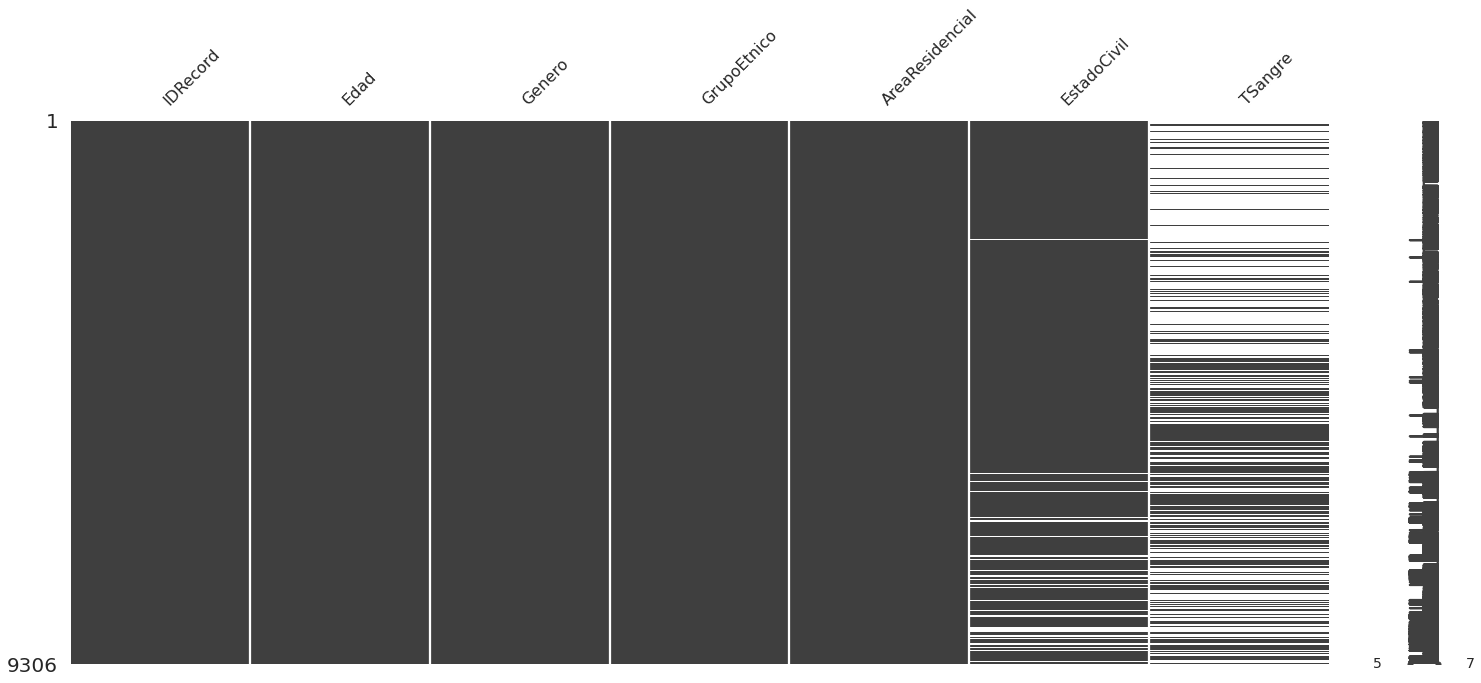

In [ ]:
_ = msno.matrix(sociodemografico)

- Edad: It might give us information on to which population groups can develop one of the conditions we are trying to look for.
- Genero: It is believed that males develop diabetes easier than females, so it is possible that this feature might give us some informatio nrelated to if the patient can have a correct diagnosis.
- GrupoEtnico: It is possible that the different diets that each ethnic group has can facilitate developing diabetes, so this can be useful.
- EstadoCivil: Patients that don't have a stable relationship are exposed to higher levels of Sexually Transmitted Diseases (STDs), so this can be an indicator for Syphilis.
- TSangre: There exists a correlation between blood type and diabetes, nonetheless we are missing many values for blood type and thus it might be difficult to use it for our analysis. 

In [ ]:
# Let's drop blood type
# sociodemografico.drop(['TSangre'], axis=1, inplace=True)
# Fill missing values with 'Not available/not reported'
sociodemografico.fillna('NA', inplace=True)
sociodemografico.head(10)

IDRecord  Edad  Genero                GrupoEtnico AreaResidencial  \
0         5    39   Mujer                    Mestizo     Zona Urbana   
1       292    84  Hombre  Ninguno de los anteriores     Zona Urbana   
2       300    88  Hombre                    Mestizo     Zona Urbana   
3       307    88  Hombre  Ninguno de los anteriores     Zona Urbana   
4       325    94  Hombre  Ninguno de los anteriores      Zona Rural   
5       339    88  Hombre  Ninguno de los anteriores     Zona Urbana   
6       361    96  Hombre  Ninguno de los anteriores     Zona Urbana   
7       401    86  Hombre  Ninguno de los anteriores     Zona Urbana   
8       406    94  Hombre  Ninguno de los anteriores     Zona Urbana   
9       433    78  Hombre  Ninguno de los anteriores     Zona Urbana   

    EstadoCivil TSangre  
0      Separado      NA  
1        Casado      NA  
2       Soltero      O+  
3  No reportado      NA  
4       Viudo/a      NA  
5  No reportado      NA  
6  No reportado      NA  
7        Casado      NA  
8  No reportado      NA  
9  No reportado      NA

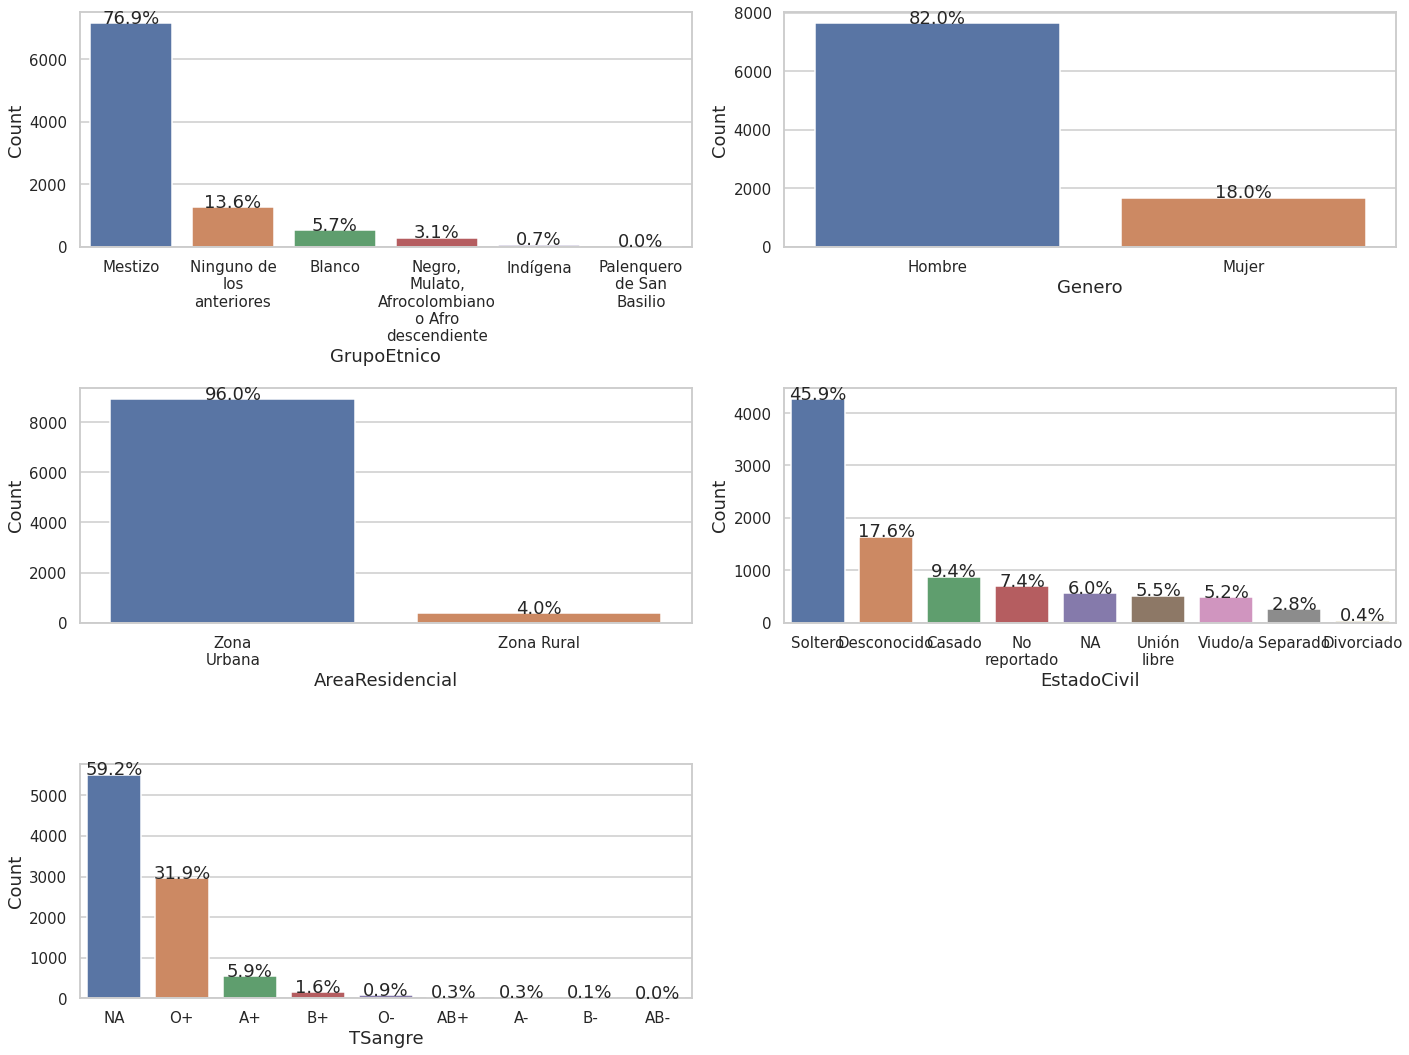

In [ ]:
fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(nrows=3, ncols=2,figsize=(20,15))
ax1 = barplot_with_percentages(x="GrupoEtnico", y=0, data=sociodemografico[['GrupoEtnico']].value_counts().to_frame().reset_index(), ax=ax1)
ax1.set(xlabel='GrupoEtnico', ylabel='Count')
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
wrap_labels(ax1, 10)

ax2 = barplot_with_percentages(x="Genero", y=0, data=sociodemografico[['Genero']].value_counts().to_frame().reset_index(), ax=ax2)
ax2.set(xlabel='Genero', ylabel='Count')
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
wrap_labels(ax2, 10)

ax3 = barplot_with_percentages(x="AreaResidencial", y=0, data=sociodemografico[['AreaResidencial']].value_counts().to_frame().reset_index(), ax=ax3)
ax3.set(xlabel='AreaResidencial', ylabel='Count')
ax3.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)
wrap_labels(ax3, 10)

ax4 = barplot_with_percentages(x="EstadoCivil", y=0, data=sociodemografico[['EstadoCivil']].value_counts().to_frame().reset_index(), ax=ax4)
ax4.set(xlabel='EstadoCivil', ylabel='Count')
ax4.tick_params(axis='x', labelsize=15)
ax4.tick_params(axis='y', labelsize=15)
wrap_labels(ax4, 10)

ax5 = barplot_with_percentages(x="TSangre", y=0, data=sociodemografico[['TSangre']].value_counts().to_frame().reset_index(), ax=ax5)
ax5.set(xlabel='TSangre', ylabel='Count')
ax5.tick_params(axis='x', labelsize=15)
ax5.tick_params(axis='y', labelsize=15)
wrap_labels(ax5, 10)

ax6.set_visible(False)
fig.tight_layout()
plt.savefig('CatSoc.png',bbox_inches='tight',dpi=600)

#### Ethnic Group (GrupoEtnico)

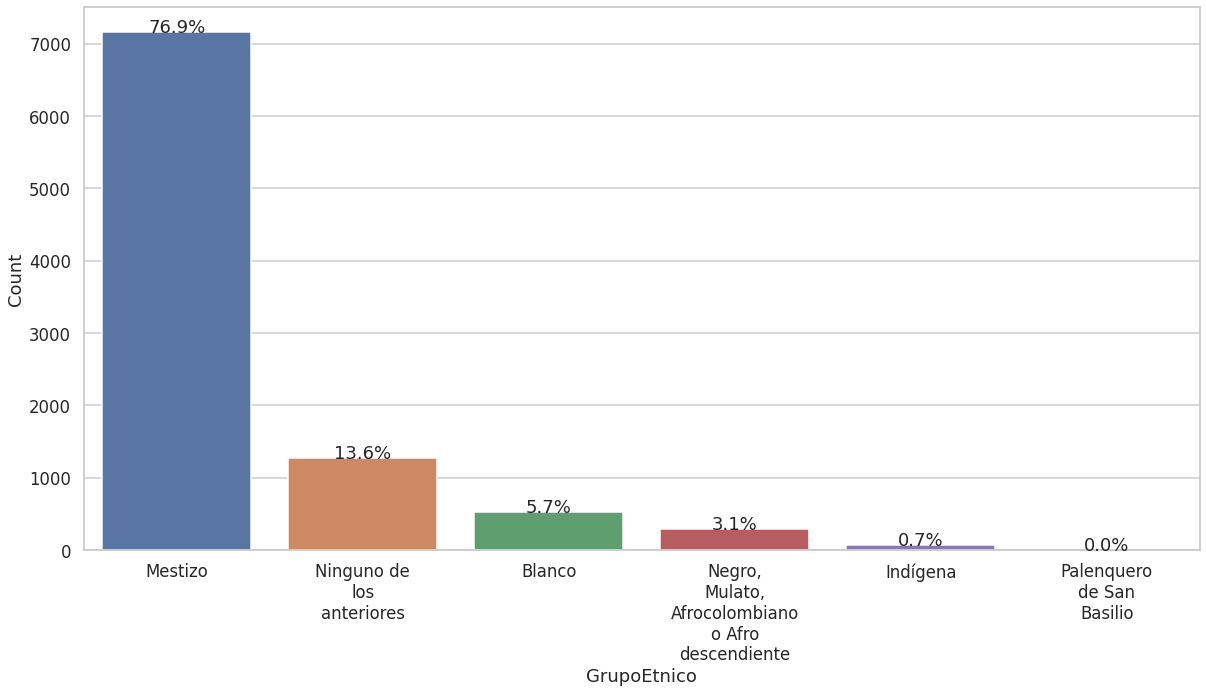

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = barplot_with_percentages(x="GrupoEtnico", y=0, data=sociodemografico[['GrupoEtnico']].value_counts().to_frame().reset_index(), ax=ax)
ax.set(xlabel='GrupoEtnico', ylabel='Count')
wrap_labels(ax, 10)

In [ ]:
grupo_etnico = sociodemografico.GrupoEtnico.value_counts().to_frame()
grupo_etnico['percentage'] = grupo_etnico.GrupoEtnico / sum(grupo_etnico.GrupoEtnico) * 100
grupo_etnico

GrupoEtnico  percentage
Mestizo                                                   7157   76.907372
Ninguno de los anteriores                                 1270   13.647109
Blanco                                                     529    5.684505
Negro, Mulato, Afrocolombiano o Afro descendiente          285    3.062540
Indígena                                                    64    0.687728
Palenquero de San Basilio                                    1    0.010746

We can see that we have 6 ethnic groups when counting the null value/group:
- Blanco: 529 samples
- Indigena: 64 samples
- Mestizo: 7157 samples
- Negro, Mulato, Afrocolombiano o Afro descendiente: 285
- Null: 1270 samples
- Palenquero de San Basilio: 1 sample

#### Gender (Genero)

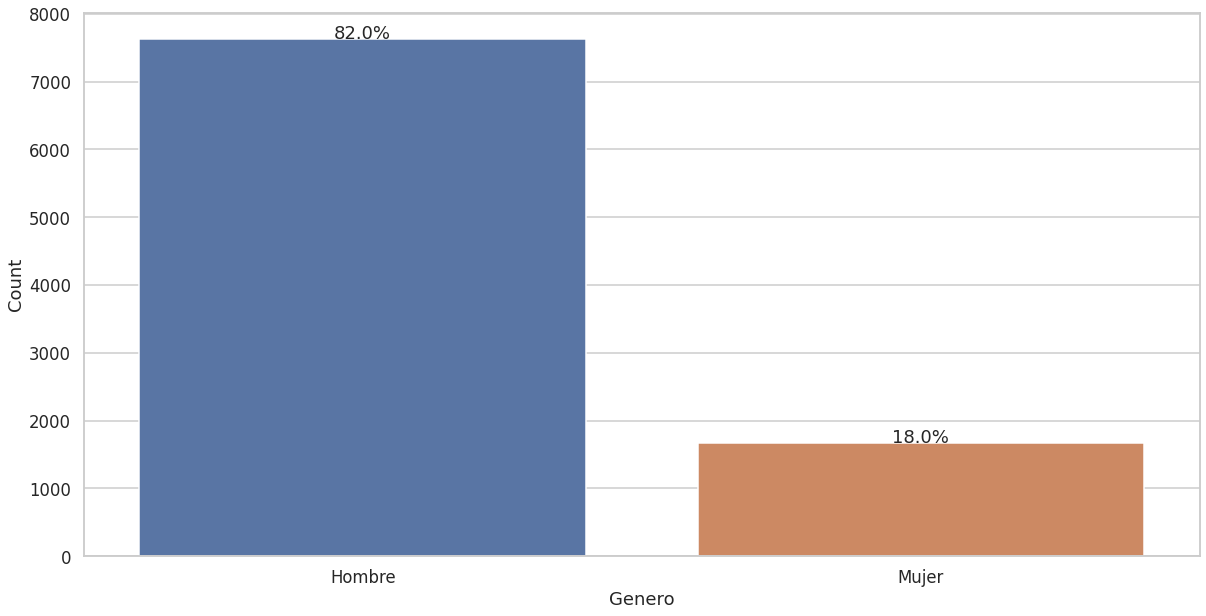

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = barplot_with_percentages(x="Genero", y=0, data=sociodemografico[['Genero']].value_counts().to_frame().reset_index(), ax=ax)
ax.set(xlabel='Genero', ylabel='Count')
wrap_labels(ax, 10)

In [ ]:
gender = sociodemografico.Genero.value_counts().to_frame()
gender['percentage'] = gender.Genero / sum(gender.Genero) * 100
gender

Genero  percentage
Hombre    7635   82.043843
Mujer     1671   17.956157

We can see that our dataset is inbalanced with respect to gender. We have only 18% of our data being of the female gender. This can affect our prediction abilities for this feature.

#### Residential Area (AreaResidencial)

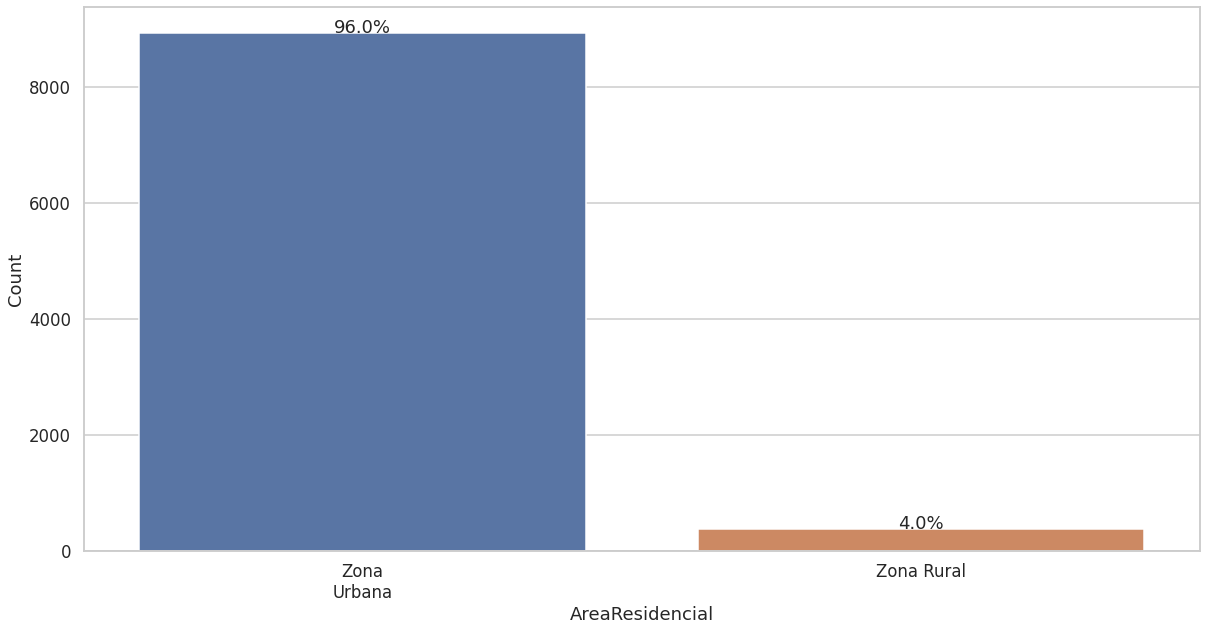

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = barplot_with_percentages(x="AreaResidencial", y=0, data=sociodemografico[['AreaResidencial']].value_counts().to_frame().reset_index(), ax=ax)
ax.set(xlabel='AreaResidencial', ylabel='Count')
wrap_labels(ax, 10)

In [ ]:
residential_area = sociodemografico.AreaResidencial.value_counts().to_frame()
residential_area['percentage'] = residential_area.AreaResidencial / sum(residential_area.AreaResidencial) * 100
residential_area

AreaResidencial  percentage
Zona Urbana             8931   95.970342
Zona Rural               375    4.029658

This feature is also very unbalanced, with the majority of the sample population living in urban areas.

#### Marital Status (EstadoCivil)

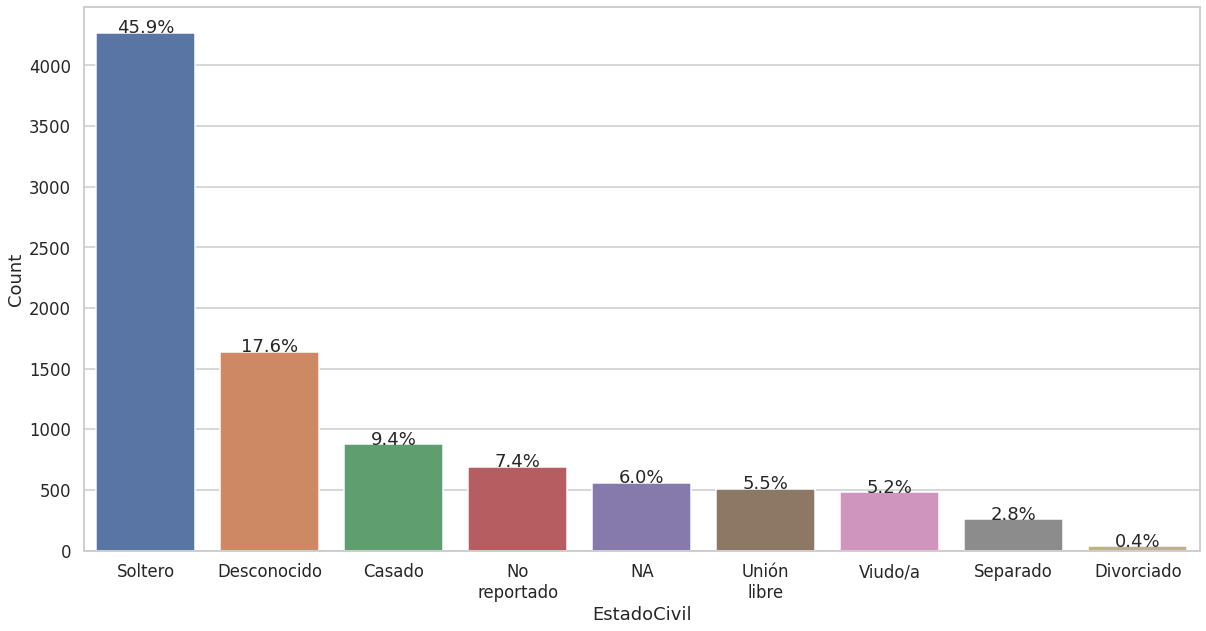

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = barplot_with_percentages(x="EstadoCivil", y=0, data=sociodemografico[['EstadoCivil']].value_counts().to_frame().reset_index(), ax=ax)
ax.set(xlabel='EstadoCivil', ylabel='Count')
wrap_labels(ax, 10)

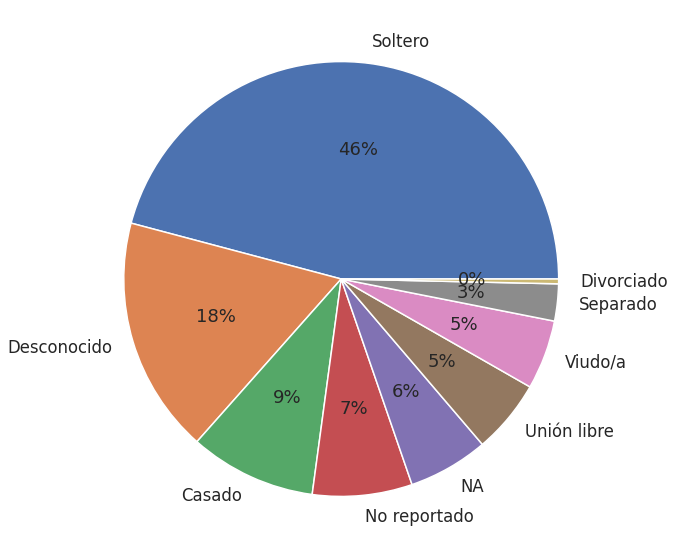

In [ ]:
#create pie chart
sc = sociodemografico[['EstadoCivil']].value_counts().to_frame().reset_index()
plt.pie(
    sc[0],
    labels = sc["EstadoCivil"],
    # colors = colors,
    autopct='%.0f%%'
    )
plt.show()

In [ ]:
marital_status = sociodemografico.EstadoCivil.value_counts().to_frame()
marital_status['percentage'] = marital_status.EstadoCivil / sum(marital_status.EstadoCivil) * 100
marital_status

EstadoCivil  percentage
Soltero              4268   45.862884
Desconocido          1637   17.590802
Casado                876    9.413282
No reportado          690    7.414571
NA                    555    5.963894
Unión libre           511    5.491081
Viudo/a               480    5.157963
Separado              256    2.750913
Divorciado             33    0.354610

Marital status also indicates that there is a large unbalance in our data, with almost half of the samples belonging to the 'Single' category. For our case, the null values (NA), "No reportado" and "desconocido" would have the same meaning and thus we can merge them together into one distinct category.

In [ ]:
for missing_val in ['Desconocido', 'NA', 'No reportado']:
    mask = sociodemografico.EstadoCivil == missing_val
    sociodemografico.loc[mask, 'EstadoCivil'] = 'Desconocido'

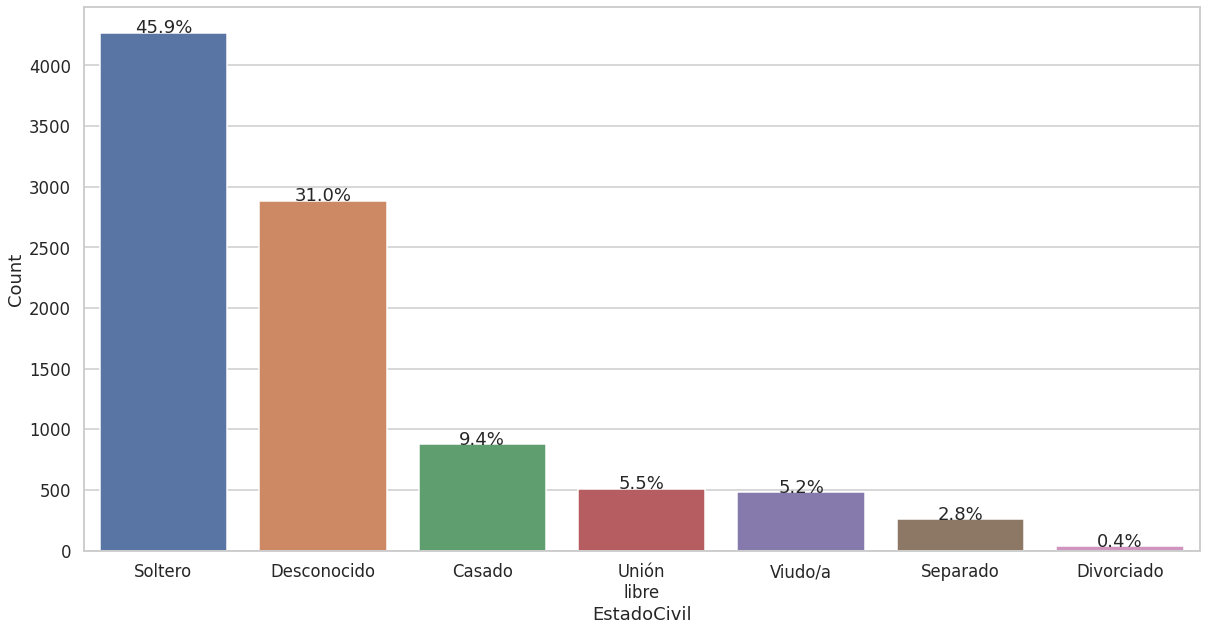

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = barplot_with_percentages(x="EstadoCivil", y=0, data=sociodemografico[['EstadoCivil']].value_counts().to_frame().reset_index(), ax=ax)
ax.set(xlabel='EstadoCivil', ylabel='Count')
wrap_labels(ax, 10)

In [ ]:
marital_status = sociodemografico.EstadoCivil.value_counts().to_frame()
marital_status['percentage'] = marital_status.EstadoCivil / sum(marital_status.EstadoCivil) * 100
marital_status

EstadoCivil  percentage
Soltero             4268   45.862884
Desconocido         2882   30.969267
Casado               876    9.413282
Unión libre          511    5.491081
Viudo/a              480    5.157963
Separado             256    2.750913
Divorciado            33    0.354610

#### Blood type (TSangre)

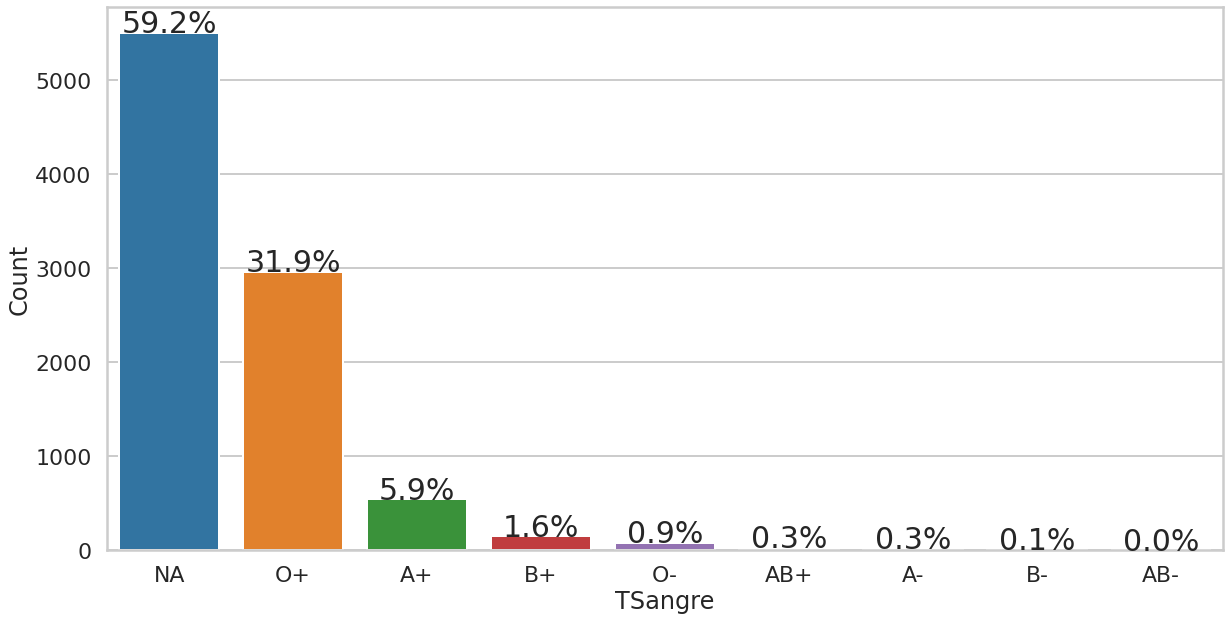

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = barplot_with_percentages(x="TSangre", y=0, data=sociodemografico[['TSangre']].value_counts().to_frame().reset_index(), ax=ax)
ax.set(xlabel='TSangre', ylabel='Count')
wrap_labels(ax, 10)

In [ ]:
blood_type = sociodemografico.TSangre.value_counts().to_frame()
blood_type['percentage'] = blood_type.TSangre / sum(blood_type.TSangre) * 100
blood_type

TSangre  percentage
NA      5505   59.155384
O+      2964   31.850419
A+       545    5.856437
B+       152    1.633355
O-        80    0.859660
AB+       25    0.268644
A-        24    0.257898
B-         9    0.096712
AB-        2    0.021492

Blood type, apart from also being heavily unbalanced, is missing information on almost 60% of the samples. It seems that it might be necessary to drop this feature from our list.

##### Marital status vs Other variables

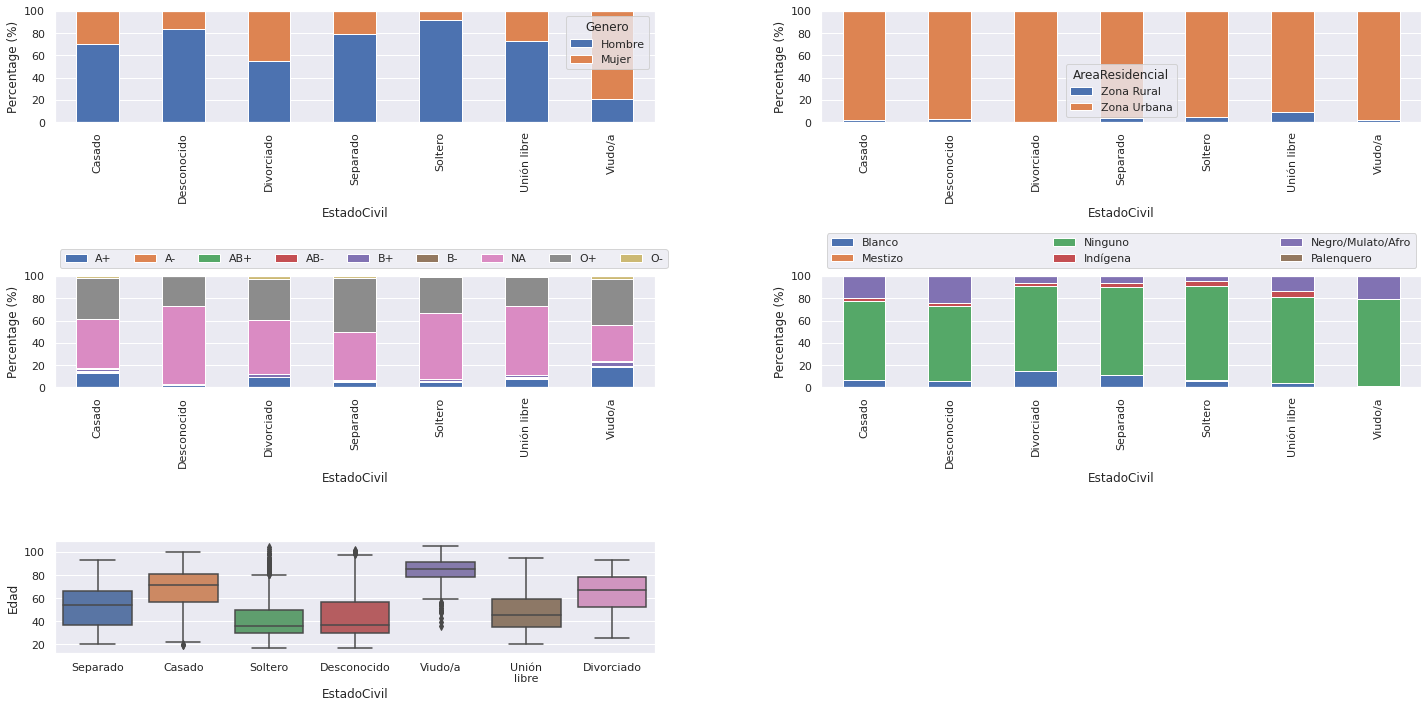

In [ ]:
with sns.plotting_context("notebook"):
    fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(nrows=3, ncols=2,figsize=(20,20))
    sd_pivot = pd.pivot_table(sociodemografico[['EstadoCivil','Genero']].value_counts().to_frame().reset_index(), index='EstadoCivil', columns='Genero', values=0, aggfunc='sum')
    suma = sd_pivot.sum(axis=1)
    sd_pivot = sd_pivot.div(suma/100, axis=0)
    sd_pivot.plot.bar(stacked=True,figsize=(20,10),ylim=(0,100), ax=ax1, ylabel='Percentage (%)')
    sd_pivot = pd.pivot_table(sociodemografico[['EstadoCivil','AreaResidencial']].value_counts().to_frame().reset_index(), index='EstadoCivil', columns='AreaResidencial', values=0, aggfunc='sum')
    suma = sd_pivot.sum(axis=1)
    sd_pivot = sd_pivot.div(suma/100, axis=0)
    sd_pivot.plot.bar(stacked=True,figsize=(20,10),ylim=(0,100), ax=ax2, ylabel='Percentage (%)')
    sd_pivot = pd.pivot_table(sociodemografico[['EstadoCivil','TSangre']].value_counts().to_frame().reset_index(), index='EstadoCivil', columns='TSangre', values=0, aggfunc='sum')
    suma = sd_pivot.sum(axis=1)
    sd_pivot = sd_pivot.div(suma/100, axis=0)
    sd_pivot.plot.bar(stacked=True,figsize=(20,10),ylim=(0,100), ax=ax3, ylabel='Percentage (%)').legend(ncol=9,bbox_to_anchor=(0,1.02,1,0.2), loc = "lower left")
    sd_pivot = pd.pivot_table(sociodemografico[['EstadoCivil','GrupoEtnico']].value_counts().to_frame().reset_index(), index='EstadoCivil', columns='GrupoEtnico', values=0, aggfunc='sum')
    suma = sd_pivot.sum(axis=1)
    sd_pivot = sd_pivot.div(suma/100, axis=0)
    sd_pivot.plot.bar(stacked=True,figsize=(20,10),ylim=(0,100), ax=ax4, ylabel='Percentage (%)').legend(['Blanco', 'Mestizo', 'Ninguno', 'Indígena', 'Negro/Mulato/Afro', 'Palenquero'], mode = "expand",ncol=3, bbox_to_anchor=(0,1.02,1,0.2), loc = "lower left")
    ax5 = sns.boxplot(x="EstadoCivil", y="Edad", data=sociodemografico[['EstadoCivil','Edad']], ax=ax5)
    ax5.set(xlabel='EstadoCivil')
    wrap_labels(ax5, 10)
    ax6.set_visible(False)
    fig.tight_layout()
    plt.savefig('MS.png',bbox_inches='tight',dpi=600)

##### Blood type vs Other variables

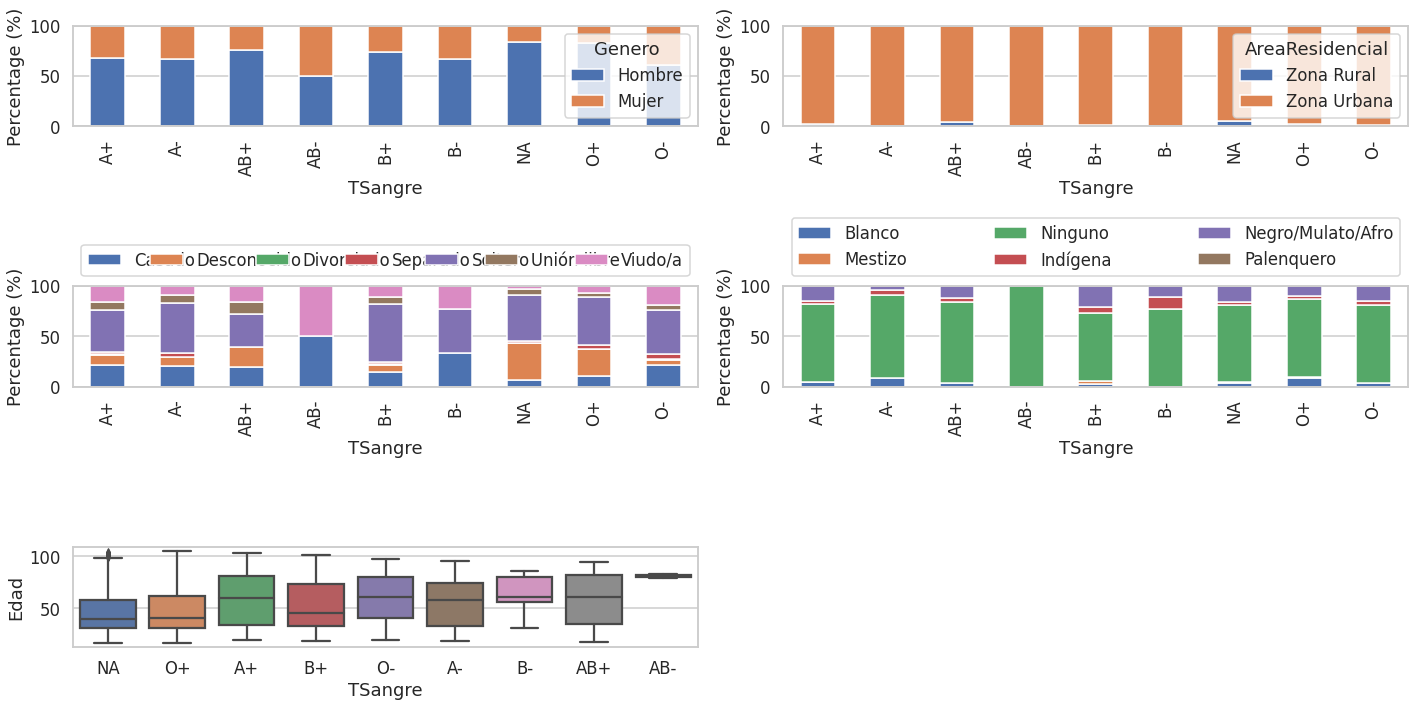

In [ ]:
with sns.plotting_context("notebook"):
    fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(nrows=3, ncols=2,figsize=(20,20))
    sd_pivot = pd.pivot_table(sociodemografico[['TSangre','Genero']].value_counts().to_frame().reset_index(), index='TSangre', columns='Genero', values=0, aggfunc='sum')
    suma = sd_pivot.sum(axis=1)
    sd_pivot = sd_pivot.div(suma/100, axis=0)
    sd_pivot.plot.bar(stacked=True,figsize=(20,10),ylim=(0,100), ax=ax1, ylabel='Percentage (%)')
    sd_pivot = pd.pivot_table(sociodemografico[['TSangre','AreaResidencial']].value_counts().to_frame().reset_index(), index='TSangre', columns='AreaResidencial', values=0, aggfunc='sum')
    suma = sd_pivot.sum(axis=1)
    sd_pivot = sd_pivot.div(suma/100, axis=0)
    sd_pivot.plot.bar(stacked=True,figsize=(20,10),ylim=(0,100), ax=ax2, ylabel='Percentage (%)')
    sd_pivot = pd.pivot_table(sociodemografico[['TSangre','GrupoEtnico']].value_counts().to_frame().reset_index(), index='TSangre', columns='GrupoEtnico', values=0, aggfunc='sum')
    suma = sd_pivot.sum(axis=1)
    sd_pivot = sd_pivot.div(suma/100, axis=0)
    sd_pivot.plot.bar(stacked=True,figsize=(20,10),ylim=(0,100), ax=ax4, ylabel='Percentage (%)').legend(['Blanco', 'Mestizo', 'Ninguno', 'Indígena', 'Negro/Mulato/Afro', 'Palenquero'], mode = "expand",ncol=3, bbox_to_anchor=(0,1.02,1,0.2), loc = "lower left")
    sd_pivot = pd.pivot_table(sociodemografico[['TSangre','EstadoCivil']].value_counts().to_frame().reset_index(), index='TSangre', columns='EstadoCivil', values=0, aggfunc='sum')
    suma = sd_pivot.sum(axis=1)
    sd_pivot = sd_pivot.div(suma/100, axis=0)
    sd_pivot.plot.bar(stacked=True,figsize=(20,10),ylim=(0,100), ax=ax3, ylabel='Percentage (%)').legend(ncol=7,bbox_to_anchor=(0,1.02,1,0.2), loc = "lower left", mode="expand")
    ax5 = sns.boxplot(x="TSangre", y="Edad", data=sociodemografico[['TSangre','Edad']], ax=ax5)
    ax5.set(xlabel='TSangre')
    wrap_labels(ax5, 10)
    ax6.set_visible(False)
    fig.tight_layout()
    plt.savefig('TS.png',bbox_inches='tight',dpi=600)

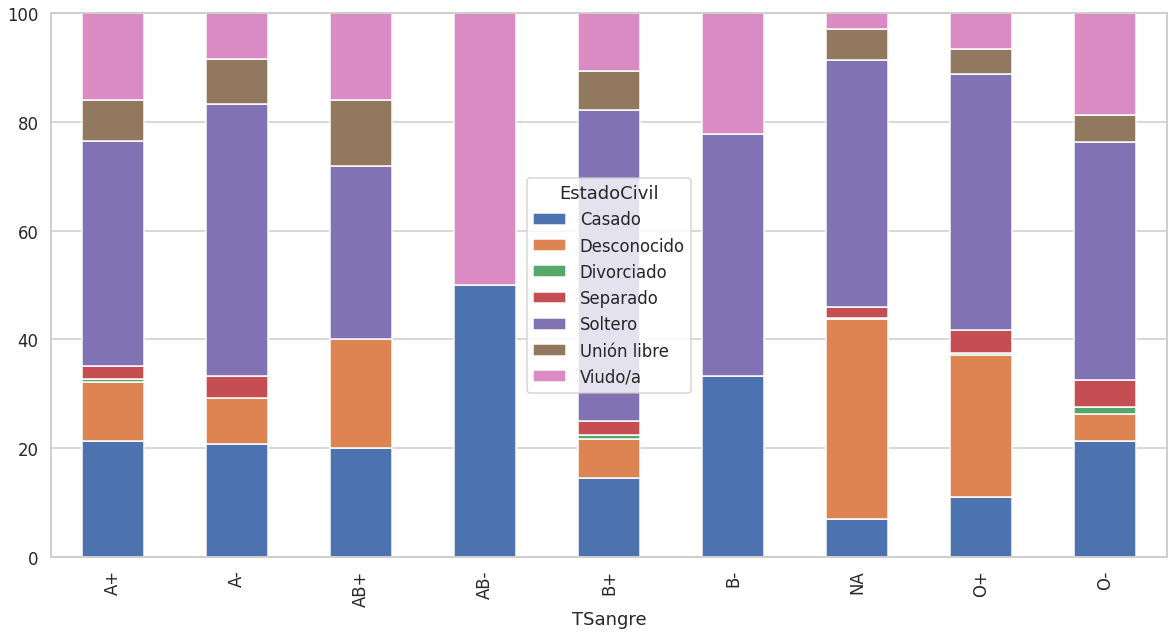

In [ ]:
sd_pivot = pd.pivot_table(sociodemografico[['TSangre','EstadoCivil']].value_counts().to_frame().reset_index(), index='TSangre', columns='EstadoCivil', values=0, aggfunc='sum')
suma = sd_pivot.sum(axis=1)
sd_pivot = sd_pivot.div(suma/100, axis=0)
sd_pivot.plot.bar(stacked=True,figsize=(20,10),ylim=(0,100))

TODO (Jorge): Comparar grupo sanguineo con las otras variables de sociodemografico, buscar si hay relaciones entre datos faltantes y ej genero, area residencial, etc. Comaprar tambien grupo sanguineo no faltante con als otras variable.

## Laboratorios file

TODO (Daniel): Analisis de valores nulos y todo lo de la seccion de Laboratorios

In [ ]:
laboratorios = pd.read_csv(str(data_path / "laboratorios.csv"),sep=';')

In [ ]:
laboratorios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189643 entries, 0 to 189642
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   IDRecord  189643 non-null  int64 
 1   Codigo    189643 non-null  object
 2   Nombre    189643 non-null  object
 3   Fecha     189643 non-null  object
 4   Valor     161754 non-null  object
dtypes: int64(1), object(4)
memory usage: 7.2+ MB


In a preliminary view of the data, we can see that in total we have 189.643 entries with a total of 5 columns of which one is an int number and the rest are strings.

In [ ]:
laboratorios.sample(10)

IDRecord   Codigo                                             Nombre  \
149134     47835   903895                                         CREATININA   
166806     87546   903866  TRANSAMINASA GLUTÁMICOPIRÚVICA O ALANINO AMINO...   
185454     41998   907106                     PARCIAL DE ORINA - UROANALISIS   
155401     40277   903895                                         CREATININA   
75026      45060   903866  TRANSAMINASA GLUTÁMICOPIRÚVICA O ALANINO AMINO...   
35542      62651   903895                                         CREATININA   
176171    111693  9100000                RELACIÓN  ALBUMINURIA Y CREATINURIA   
162062     47177   903866  TRANSAMINASA GLUTÁMICOPIRÚVICA O ALANINO AMINO...   
19002      65615   903816       COLESTEROL DE BAJA DENSIDAD (LDL) ENZIMÁTICO   
100406    127372   906221  Hepatitis B, ANTICUERPOS CENTRAL TOTALES (ANTI...   

                   Fecha                           Valor  
149134   30/04/2019 0:00                            1.10  
166806   27/08/2021 0:00                           35.30  
185454    1/05/2019 0:00  OTROS - METODO:MICROSCOPÍA AUT  
155401   11/11/2021 0:00                            1.11  
75026    7/02/2022 12:57                           31.60  
35542    9/03/2021 18:00                            0.75  
176171   19/08/2020 0:00                          708.45  
162062   19/08/2020 0:00                          121.00  
19002     1/12/2021 8:26                           94.00  
100406  21/05/2021 14:42                            0.11

In a quick glimpse at the data itself we have int the ‘laboratorios’ dataset information about the code of the patient, the code of the laboratory test, the name of the laboratory test, the date of the test, and the value of each test taken.

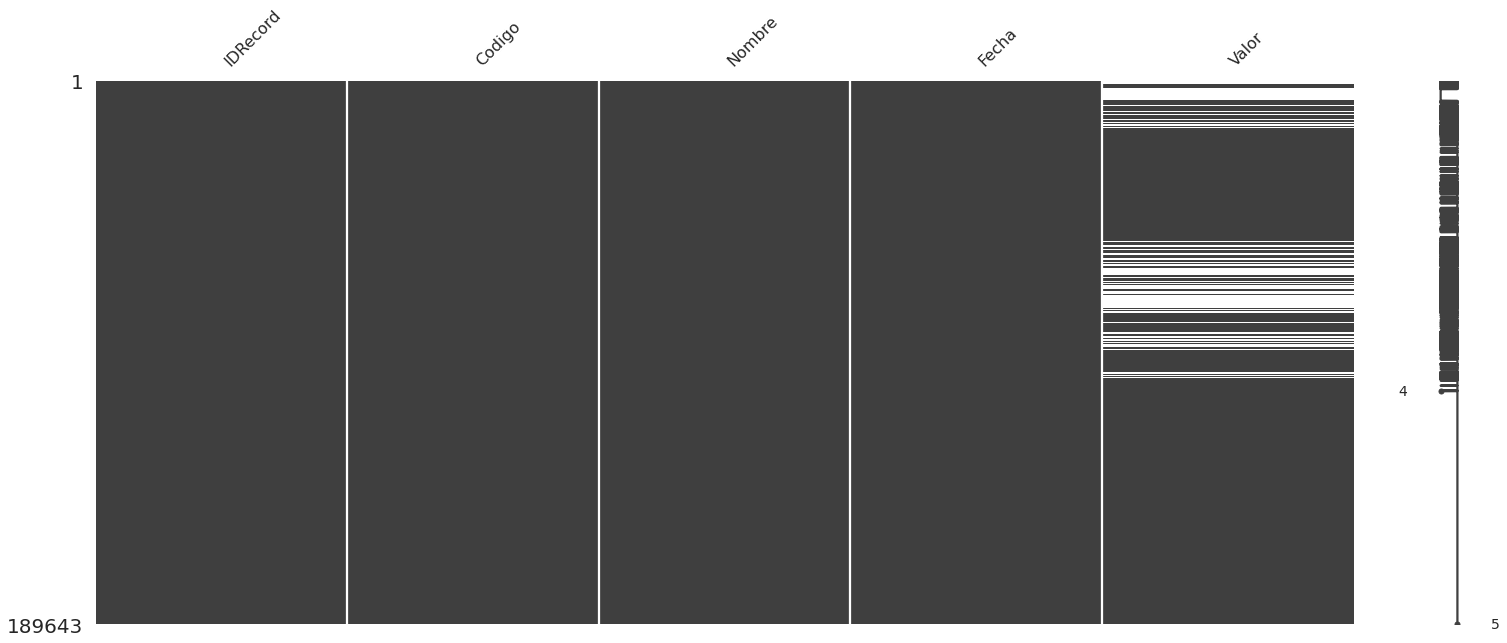

In [ ]:
_ = msno.matrix(laboratorios)

As we can see the only column that has null values is the ‘Valor’ column which represents the value obtained in the test made on the patient.

In [ ]:
laboratorios.Valor.isnull().sum()

27889

We have a total of 27.889 entries with 'Valor' column null. That represents the 14.07% of all the entries.

### Numerical Features Analysis

#### Date (Fecha)

In [ ]:
laboratorios.Fecha = pd.to_datetime(laboratorios.Fecha)

In [ ]:
laboratorios.Fecha.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  189643
unique                   8292
top       2020-10-14 00:00:00
freq                      383
first     2001-12-09 00:00:00
last      2022-12-03 14:56:00
Name: Fecha, dtype: object

After turning the ‘Fecha’ column into datetime and running the describe command we can see that we have laboratory tests from December 9, 2001 to December 3, 2022. Being the date with the most test taken October 14 2020.

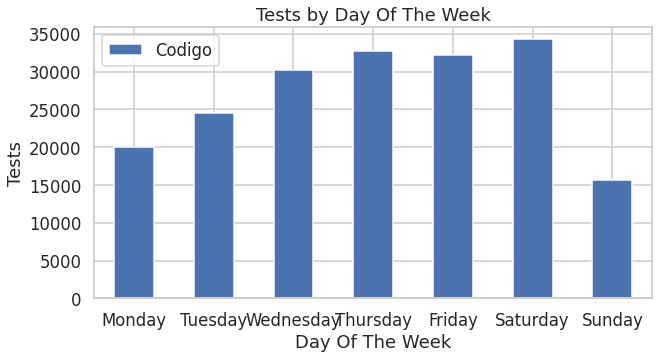

In [ ]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_df = laboratorios.groupby(laboratorios.Fecha.dt.day_name()).count().reindex(cats)
week_df.plot(kind="bar", y="Codigo", rot = 0, figsize=(10, 5))
plt.xlabel("Day Of The Week")
plt.ylabel("Tests")
plt.title("Tests by Day Of The Week")
plt.legend()
plt.show()

We can see that the take test 7 days of the week, being the day with most test saturday

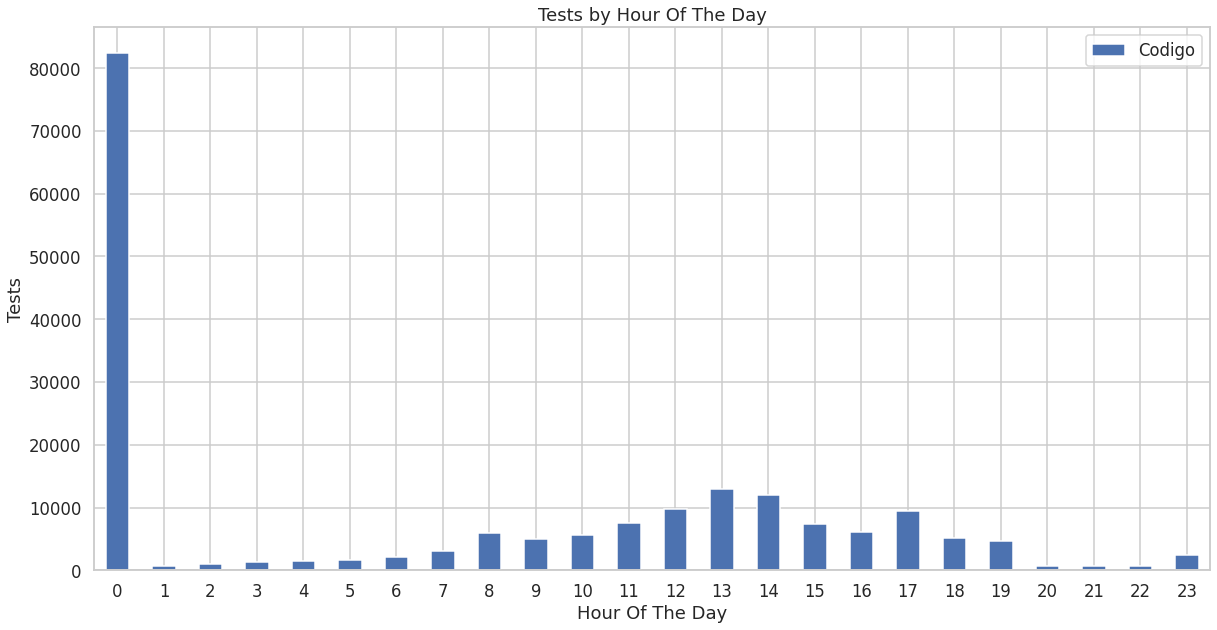

In [ ]:
hour_df = laboratorios.groupby(laboratorios.Fecha.dt.hour).count()
hour_df.plot(kind="bar", y="Codigo", rot = 0)
plt.xlabel("Hour Of The Day")
plt.ylabel("Tests")
plt.title("Tests by Hour Of The Day")
plt.legend()
plt.show()

Watching the hours that are in the dataset we can see that the hour with most tests taken is 0 hours, having another peak on the 13 hours. The peak at 0 hours might indicate a problem with missing values for the time, as blood test labs are not normally open at midnight

In [ ]:
# TODO: average periods between exams of patients between exams of patients

#### Value (Valor)

TODO: Describe average values, max, min, by test type/code. 

TODO: Analyze how is the missing data related to each patient: Are datapoints missing for a specific patient, are we only loosing e.g. one of the measurements done in a patient from 5? Etc

### Categorical Features analysis

#### Code (Codigo)

In [ ]:
laboratorios.Codigo.unique()

array(['902045', '902049', '902206', '902209', '901101', '903426',
       '903603', '903604', '903703', '903706', '903801', '903803',
       '903809', '903812', '903815', '903816', '902211', '903818',
       '902213', '903895', '902220', '904904', '903016', '903026',
       '903044', '903105', '903833', '904912', '904921', '906250',
       '906314', '906317', '903835', '903841', '906318', '906744',
       '908807', '906915', '903843', '903846', '903856', '903859',
       '903862', '903864', '903866', '907002', '907102', '907106',
       '903867', '907109', '908802', '908806', '908825', '908832',
       '904922', '90110102', '90110101', '903868', '904508', '906039',
       '906127', '906129', '906205', '906219', '906220', '906221',
       '906222', '906223', '906225', '906610', '906712', '903027',
       '903838', '906206', '906218', '906714', '903895..', '901404',
       '903835-3', '902207', '902208', '903810', '903809.', '904902',
       '. 903809 .', '904913', '906840', '90691501', 

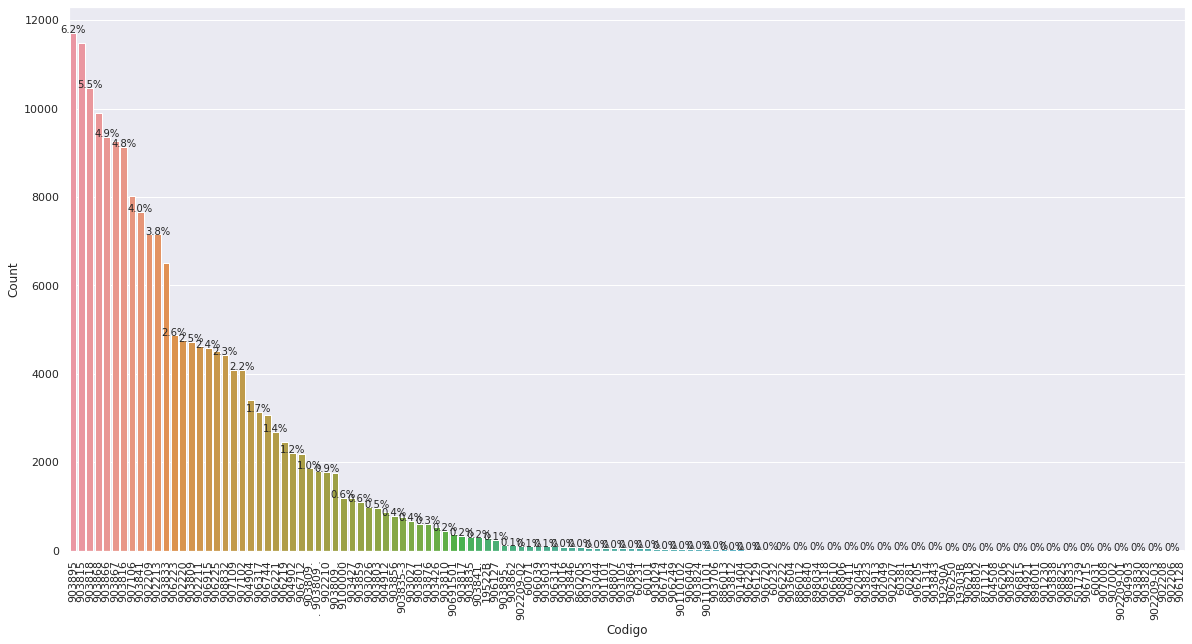

In [ ]:
with sns.plotting_context("notebook"):
    fig, ax = plt.subplots(figsize=(20,10))
    code_count = laboratorios[['Codigo']].value_counts().to_frame().reset_index()
    code_count = code_count[code_count[0]>1]
    ax = barplot_with_percentages(x="Codigo", y=0, data=code_count, ax=ax)
    ax.set(xlabel='Codigo', ylabel='Count')
    # wrap_labels(ax, 10)
    ax.tick_params(axis='x', rotation=90)

In [ ]:
code = laboratorios.Codigo.value_counts().to_frame()
code['percentage'] = code.Codigo / sum(code.Codigo) * 100
code.sort_values(by="percentage", ascending=False)
code.columns = ["quantity", "percentage"]
code

quantity  percentage
903895         11712    6.175815
903815         11492    6.059807
903818         10462    5.516681
903868          9905    5.222972
903866          9353    4.931898
...              ...         ...
890380             1    0.000527
90624902           1    0.000527
05894-T            1    0.000527
99350202_X         1    0.000527
906233             1    0.000527

[180 rows x 2 columns]

The table above presents the different laboratory test codes in the dataset with the percetage of records found in it. There are 180 in total.

As we can see, the test most employeed is the one with the code 903895 with 6.17% of records found. Then, tests 903815 and 903818 with 6.05% and 5.51% respectively. On the other hand, there are test with just 1 records found in the dataset (i.g. test 906233, among others).

Adittionally, we can observe that some codes are no completly numerical. We can see codes with som characters such as "05894-T" and "99350202_X	".

In [ ]:
code = code.reset_index()

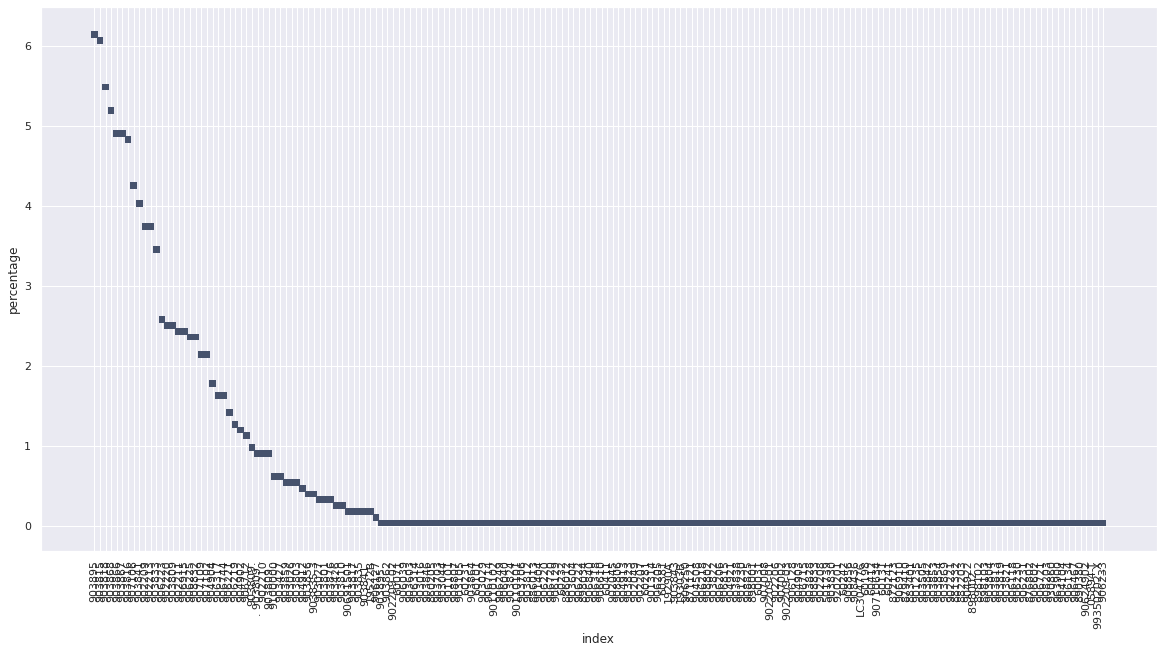

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.xticks(rotation=90)
code_plot = sns.histplot(data=code, x="index", y="percentage")

If we look into the values through the plot below, we can see the following:
*   A few kind of test are between 3 and around 6%.
*   Then, other group of test range from almost 1% and less than 3%
*   The major part of the test have a percentage lower than 1%

The next plot present the ones with a percentage equal or more than 1%

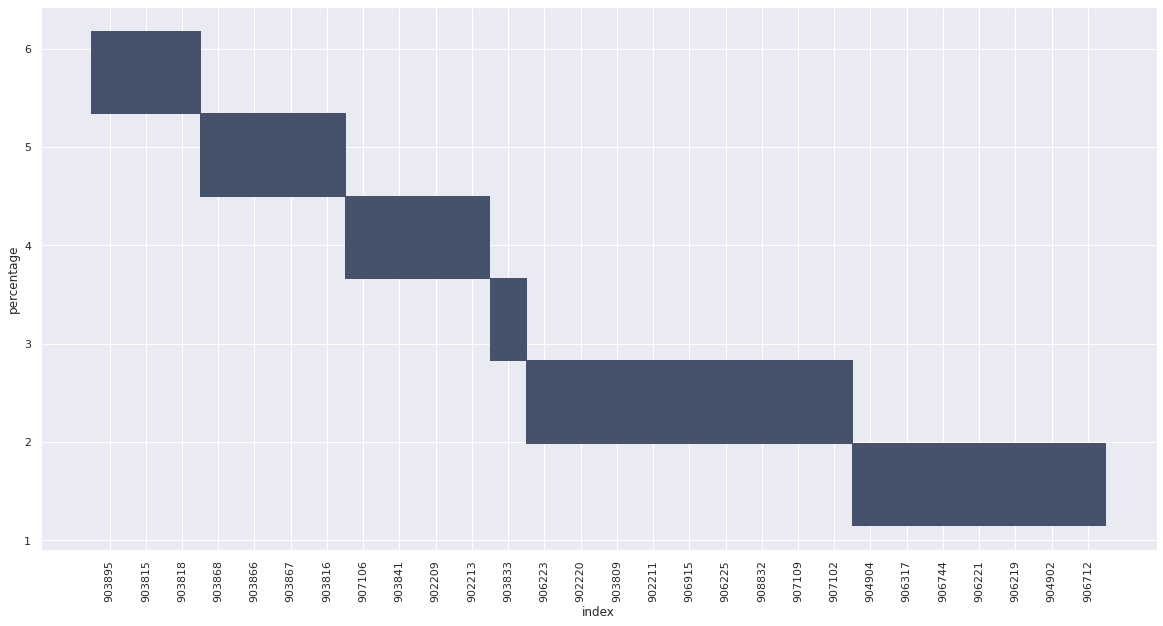

In [ ]:
top_tests = code[code.percentage >= 1]
sns.set(rc = {'figure.figsize':(20,10)})
plt.xticks(rotation=90)
top_tests_plot = sns.histplot(data=top_tests, x="index", y="percentage")

#### Name (Nombre)

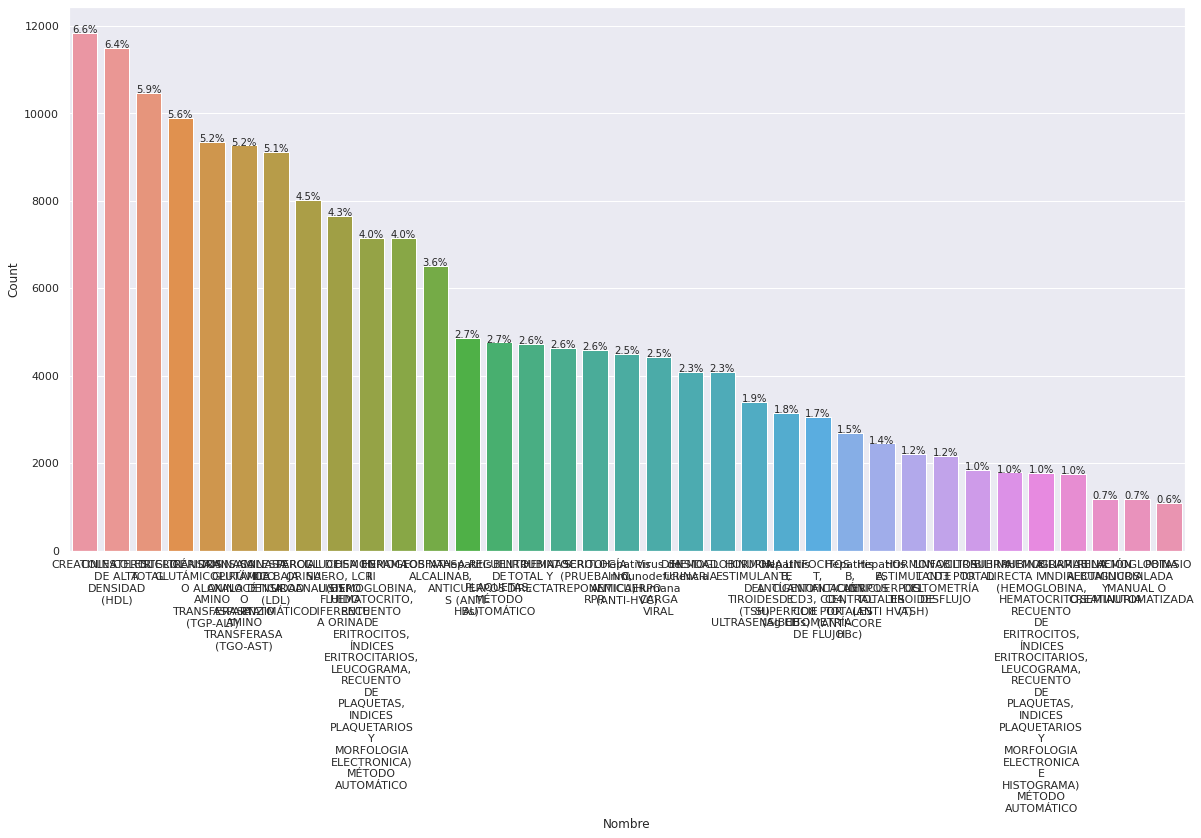

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
name_count = laboratorios[['Nombre']].value_counts().to_frame().reset_index()
name_count = name_count.head(int(len(name_count)*(20/100))) # Pareto's principle
ax = barplot_with_percentages(x="Nombre", y=0, data=name_count, ax=ax)
ax.set(xlabel='Nombre', ylabel='Count')
wrap_labels(ax, 10)

In [ ]:
name = laboratorios.Nombre.value_counts().to_frame()
name['percentage'] = name.Nombre / sum(name.Nombre) * 100
name

Nombre  percentage
CREATININA                                           11841    6.243837
COLESTEROL DE ALTA DENSIDAD (HDL)                    11492    6.059807
COLESTEROL TOTAL                                     10462    5.516681
TRIGLICÉRIDOS                                         9905    5.222972
TRANSAMINASA GLUTÁMICOPIRÚVICA O ALANINO AMINO ...    9353    4.931898
...                                                    ...         ...
VIH 1 Y 2 ANTICUERPOS SEGUNDA PRUEBA                     1    0.000527
prueba de Tropismo vírico                                1    0.000527
XEROMAMOGRAFIA O MAMOGRAFIA, BILATERAL                   1    0.000527
HEPATITIS A MAYORES DE 19 A                              1    0.000527
HTLV-I Y II, ANTICUERPOS (ANTI HTLV-I) TOTALES ...       1    0.000527

[178 rows x 2 columns]

Now, we can see the different names for the laboratory tests. Some of them are larger than others. Besides, there are somes names registered in lower case and others with upper case. It can be standarized by transforming all names to lower case.

Here, we can notice a difference between the amount of records of this table with names and the one previously showed with codes. While in the first table are 180 records, this present 178. It can suggest there are some names duplicated. To verify this, we can explore its values as following:

In [ ]:
name_code = laboratorios[['Nombre', 'Codigo']].value_counts().reset_index().rename({0:'Count'}, axis=1)
# name['percentage'] = name.Nombre / sum(name.Nombre) * 100
name_code

Nombre     Codigo  Count
0                                           CREATININA     903895  11712
1                    COLESTEROL DE ALTA DENSIDAD (HDL)     903815  11492
2                                     COLESTEROL TOTAL     903818  10462
3                                       TRIGLICÉRIDOS      903868   9905
4    TRANSAMINASA GLUTÁMICOPIRÚVICA O ALANINO AMINO...     903866   9353
..                                                 ...        ...    ...
175                   IRRIGACION O ENEMA TRANSANAL SOD     963900      1
176  TEST DE AVIDEZ ANTICUERPOS Ig G TOXOPLASMA SEM...     906134      1
177  ESTUDIO DE COLORACIÓN BASICA EN CITOLOGIA DE L...  898002         1
178                               TIROXINA TOTAL (T4)      904922      1
179   CONSULTA DE CONTROL O DE SEGUIMIENTO POR ESPE...     890380      1

[180 rows x 3 columns]

We create a table with both columns: Nombre and Codigo. Here, we have 180 rows in total. Now, let's find the duplicate by nombre.

In [ ]:
name_code[name_code.Nombre.duplicated()]

Nombre    Codigo  Count
51                                          CREATININA  903895..    129
150  TRANSAMINASA GLUTÁMICO OXALACÉTICA O ASPARTATO...     60242      1

As we can see, there are two test that are more than once in our data. No, we can find them to see in detail each of the duplicates

In [ ]:
name_code[name_code.Nombre == "CREATININA"]

Nombre    Codigo  Count
0   CREATININA    903895  11712
51  CREATININA  903895..    129

In [ ]:
name_code[name_code.Codigo == "60242"].Nombre.values

array(['TRANSAMINASA GLUTÁMICO OXALACÉTICA O ASPARTATO AMINO TRANSFERASA [TGO-AST] . .'],
      dtype=object)

The code below is for extracting the full name of the second test duplicated

In [ ]:
name_code[name_code.Nombre == "TRANSAMINASA GLUTÁMICO OXALACÉTICA O ASPARTATO AMINO TRANSFERASA [TGO-AST] . ."]


Nombre Codigo  Count
139  TRANSAMINASA GLUTÁMICO OXALACÉTICA O ASPARTATO...  60241      1
150  TRANSAMINASA GLUTÁMICO OXALACÉTICA O ASPARTATO...  60242      1

With the duplicates identified, we can proceed to unify them, particularly by the code.

## Notas file

TODO (Juan): Analisis archivo Notas

In [ ]:
notas = pd.read_csv(str(data_path / "notas.csv"),sep=';')
notas.sample(10)

IDRecord Código                                             Nombre  \
77457     70307   A539                           SIFILIS, NO ESPECIFICADA   
112735    39359   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
54825     47665   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
62767     54582   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
90950     40893   A539                           SIFILIS, NO ESPECIFICADA   
46368     39619   E119  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
118108    44936   A539                           SIFILIS, NO ESPECIFICADA   
53484     45480   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
8101      91164   E119  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
21468    110323   A539                           SIFILIS, NO ESPECIFICADA   

                       Tipo                                               Plan  
77457   Confirmado Repetido  Se recomienda adherencia  a su medicación TARV...  
112735  Confirmado Repetido  -TAR: CONTINUA IGUAL: DTG+DRV+ RTV  -PROFILAXI...  
54825   Confirmado Repetido  PACIENTE DE 27 AÑOS, CON DIAGNOSTICO DE VIH EN...  
62767   Confirmado Repetido  - Completar esquema de vacunación  - Control e...  
90950   Confirmado Repetido  PLAN:  - TARV:TDF/FTC+ATV/r (300/200mgx1+300/1...  
46368   Confirmado Repetido  -TAR: CONTINUA IGUAL: ABC/3TC + RAL.  -PROFILA...  
118108  Confirmado Repetido  se  recomienda ingesta  fraccionada  y  se res...  
53484   Confirmado Repetido                                       ver análisis  
8101    Confirmado Repetido  1. SEGUIR LAS RECOMENDACIONES Y EL PLAN NUTRIC...  
21468   Confirmado Repetido  EMPEZO TAR EN NOV/20  SE CONTINUA IGUAL TAR CO...

In [ ]:
notas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140227 entries, 0 to 140226
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   IDRecord  140226 non-null  object
 1   Código    140179 non-null  object
 2   Nombre    140178 non-null  object
 3   Tipo      140176 non-null  object
 4   Plan      140117 non-null  object
dtypes: object(5)
memory usage: 5.3+ MB


### Null value analysis

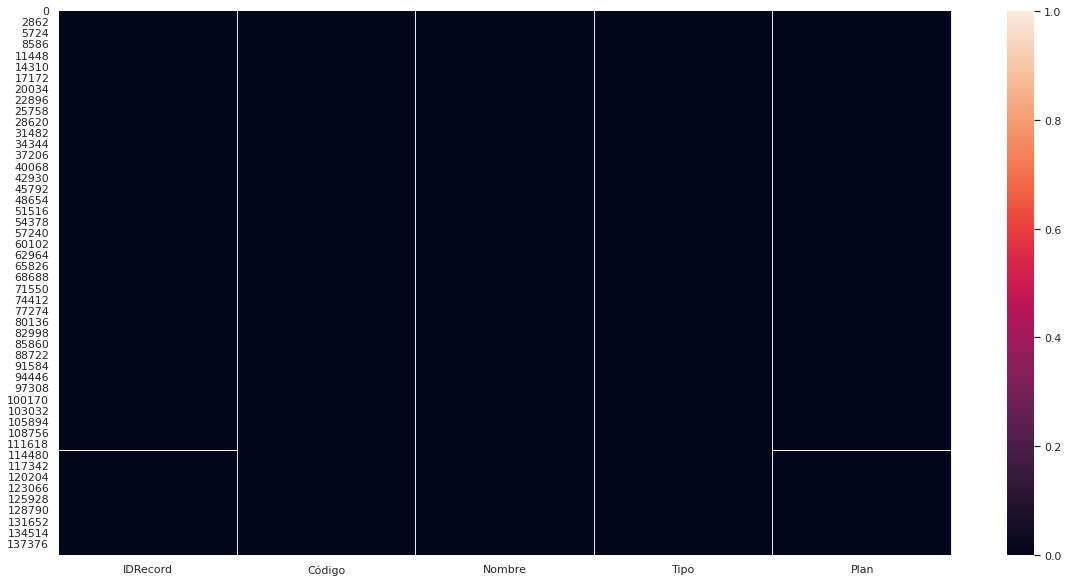

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
_ = sns.heatmap(notas.isnull(), ax=ax)

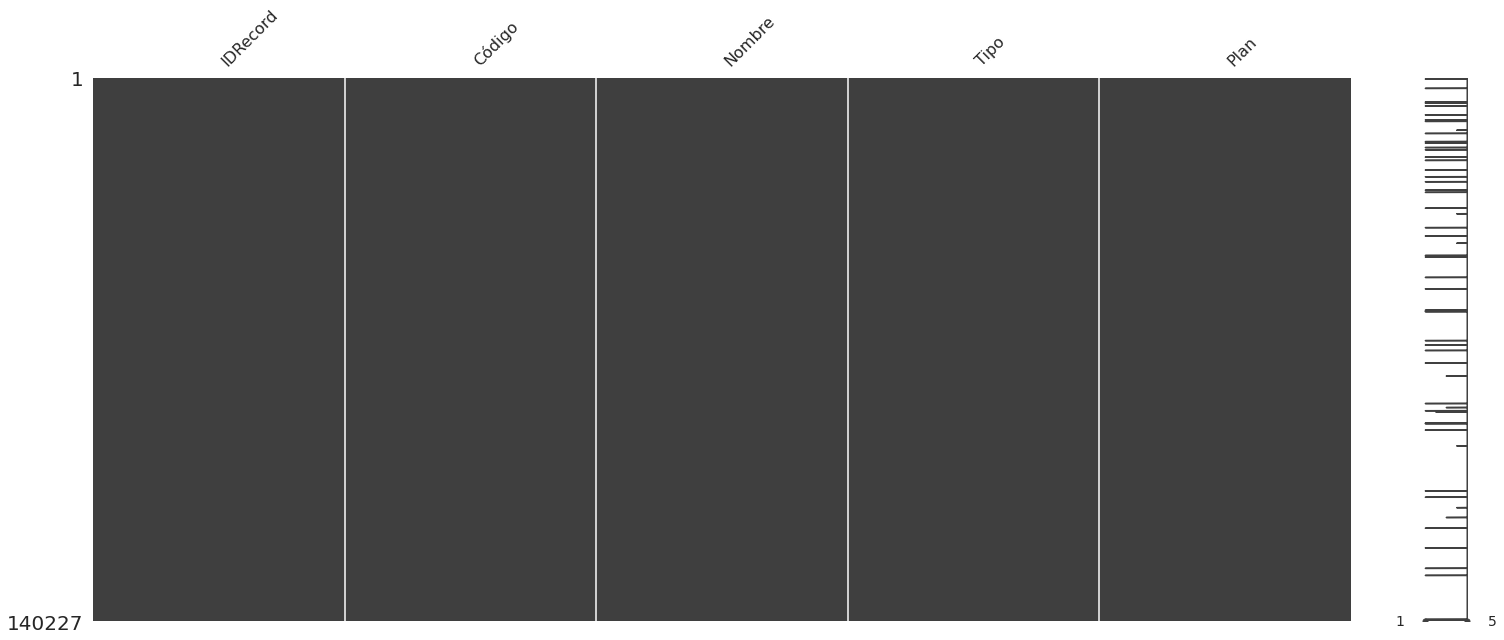

In [ ]:
_ = msno.matrix(notas)

In [ ]:
notas.isnull().sum().to_frame("count")

count
IDRecord      1
Código       48
Nombre       49
Tipo         51
Plan        110

It seems we do have some null values in the different features of our  dataset. Let's see what we can do with them:
- IDRecord:
We can't replace IDRecord as that is a unique value used for joining together the information of the different datasets. 
- Code/Name:
Code/Name would be the feature we would be trying to predict on, so we can't fill those either. However, each Name uniquely correspond to each Code, so we might be able to recover some missing values with that
- Type, Plan:
We can do a simple inputting and replace the missing values from the null samples for the rest of the samples, in order to see if we can use the rest of the data found in the other datasets to predict the condition of the patient.

In [ ]:
# Dropping null values from IDRecord
notas.dropna(subset=['IDRecord'], inplace=True)

In [ ]:
notas.IDRecord.isnull().any()

False

In [ ]:
# Checking to see what we can do with  Code and Name
notas[notas[['Código', 'Nombre']].isnull().any(axis=1)]

IDRecord  \
346     ÍNTOMAS COMO DOLOR DE GARGANTA, DOLOR DE CABEZ...   
2756    FARMACEUTICA: PENDIENTE  TRABAJO SOCIAL: FEB/2...   
6298     Psicología, Nutrición, Trabajo social, Químic...   
6314    ncia, motivación para proyecto de vida, estilo...   
6552    MIDA CON RESTRICCIÓN DE CARBOHIDRATOS SIMPLES ...   
7285    ENA RESPUESTA AL TRATAMINTO ( RPR INICIAL EN 3...   
9588    ndiente aplicar 2da dosis de vacuna contra VHB...   
10890   ROMORFONA 2.5 MG VO CADA 8 HORAS, 1 CADA 8 HOR...   
11267   CIONADO  PACIENTE DICE ENTENDER Y ACEPTAR.  PR...   
14380   adoptadas para evitar las infecciones respirat...   
16491   generar un mejor rendimiento en las tareas que...   
16843    RICION: JUL/20  ODONTOLOGIA: NOV/20 (PARTICULAR)   
18018   FIERE ALGUNO  6. SE DAN SIGNOS DE ALARMA (FIEB...   
18588                                           MENTOS***   
20491   ILIDADES CON LOSARTAN 50MGX2, AMLODIPINOX5MGX1...   
21331                                            CONTROL    
23826   ECAIMIENTO O DETERIORO DEL ESTADO GENERAL EN F...   
25553   GRAL DE ATENCIÓN DE ACUERDO AL CICLO DE VIDA: ...   
26836   USCULAR.  -SEGUIMIENTO NUTRICIONAL EN 6 MESES....   
29022   dificultad para respirar o tomar aire  - Fiebr...   
29576    SUENA O LE DUELE AL RESPIRAR, SOMNOLENCIA O D...   
33674    Valoración: todo el equipo multidisciplinario...   
38679   ejore, dolor en el pecho, persistencia del dol...   
40832   estimiento espeso y blanco en la lengua o la b...   
45863   gramo, una ampolla intravenosa cada 12 horas h...   
46247   .    *Control grupo de apoyo  *Recomendaciones...   
51520   O POR COVID 19 AUN DESPUES DE HABER RECIBIDO L...   
54461                                 tria: No requiere     
59984   0/200/600 mg vo cada noche 9 pm .  2.Trimetrop...   
60230   23 TGP 22 BILIRRUBINA TOTAL 0,37 TSH 1,7..HEMO...   
60352   vacuna para hb coinfeccion con vhb  Vacuna inf...   
67822   espirar o tomar aire  - Fiebre de difícil cont...   
68962   ALIDADES DERIVADAS COMO PSICOLOGÍA, ODONTOLOGÍ...   
70367   L TRATAMIENTO  4. ACUDIR A CITAS DE CONTROL EQ...   
73613   /day for 10 days, ceftriaxone 500 mg IM in a s...   
84051   SIÓN ARTERIAL ESTÁN POR ENCIMA DE 160/100.  • ...   
85907   n infectología ultima 11/2019 proximo en 05/20...   
86209                                        ado Repetido   
89127   EVIAMENTE     SE EXPLICA CLARAMENTE CONDUCTA M...   
89245   8 con TNF/FCT/EFV se educa acerca de efectos a...   
90911    MOMENTO  SE FORMULAN PRESERVATIVOS PARA PREVE...   
106576   DE TRANSMISIÓN Y A DISMINUIR EL RIESGO DE TRA...   
108230  2021.  f) Paraclinicos control 01/2022  g) se ...   
116216  ados hace una semana  + anoscopia + biopsia  -...   
121294  8 TFG mdrd-4 (ml/min/1,73 m2) 104 ml/min.  - V...   
126567  titis b, influenza cepa 2021, neumococo preven...   
128391  e tardía.   *coinfección por hepatitis b, no s...   
139735  ENFERMERIA:     1.RIESGO DE INFECCIÓN: CONOCIM...   
140128  ON GLOMERULAR: 81 ML/MIN POR MDRD  PERFIL META...   

                                                   Código Nombre Tipo Plan  
346                                                   NaN    NaN  NaN  NaN  
2756                                                  NaN    NaN  NaN  NaN  
6298                                                  NaN    NaN  NaN  NaN  
6314                                                  NaN    NaN  NaN  NaN  
6552                                                  NaN    NaN  NaN  NaN  
7285                                                  NaN    NaN  NaN  NaN  
9588                                                  NaN    NaN  NaN  NaN  
10890                                                 NaN    NaN  NaN  NaN  
11267                                                 NaN    NaN  NaN  NaN  
14380                                                 NaN    NaN  NaN  NaN  
16491                                                 NaN    NaN  NaN  NaN  
16843                                                 NaN    NaN  NaN  NaN

It seems we're missing the same data for both Name and Code features, except for one that contains the Plan for one of the samples. At the same time, we can see that the samples that have NaN for Code and/or Name also have a problem with their IDRecord, making them unusable. 

In [ ]:
# Drop samples where both Code and Name are null
notas.dropna(how='all', subset=['Código', 'Nombre'], inplace = True)

In [ ]:
notas.isnull().sum().to_frame('count')

count
IDRecord      0
Código        0
Nombre        1
Tipo          3
Plan         61

Next, we'll check on the missing values for feature Plan and how it relates with other variables

In [ ]:
# Checking to see what we can do with Type
plan_missing = notas[notas[['Plan']].isnull().any(axis=1)]
plan_missing.head()

IDRecord Código                                             Nombre  \
345     65615   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
2755    94301   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
6297    54544   A539                           SIFILIS, NO ESPECIFICADA   
6313    87270   A539                           SIFILIS, NO ESPECIFICADA   
6551    62282   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   

                     Tipo Plan  
345   Confirmado Repetido  NaN  
2755  Confirmado Repetido  NaN  
6297  Confirmado Repetido  NaN  
6313  Confirmado Repetido  NaN  
6551  Confirmado Repetido  NaN

In [ ]:
plan_missing.groupby(["Nombre", 'Tipo']).size().to_frame('counts').reset_index().sort_values(by=['counts'], ascending=False)

Nombre  \
3  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
4                           SIFILIS, NO ESPECIFICADA   
1  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
2  DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...   
0                                Confirmado Repetido   

                                                Tipo  counts  
3                                Confirmado Repetido      25  
4                                Confirmado Repetido      23  
1                                Confirmado Repetido       7  
2                                Confirmado Repetido       2  
0  *Control por Trabajo Social según frecuencia y...       1

We can see that all of the missing values in Plan have Tipo = Confirmado Repetido. At first sight, it could indicate that there is a relation between this category and the missing values. However, the proportion of this category in the dataset is close to 97%, so, it makes sense that this particular type is present in all of the missing values. To observe the relation with the different categories in Name, we plot the relationship between feature Name and the missing/not missing values for Plan

In [ ]:
plan_missing = notas.copy()
plan_missing['miss_plan'] = plan_missing[['Plan']].isnull().any(axis=1)

In [ ]:
plan_missing['IDRecord'] = pd.to_numeric(plan_missing['IDRecord'], errors='coerce')
plan_missing.dropna(subset=['IDRecord'], inplace = True)

index = plan_missing[plan_missing.Nombre == 'Confirmado Repetido'].index
plan_missing.loc[index, ['Nombre', 'Tipo', 'Plan']] = plan_missing.loc[index, ['Código', 'Nombre', 'Tipo']].to_numpy()
plan_missing.loc[index, 'Código'] = plan_missing[plan_missing['Nombre'] == plan_missing.loc[index, 'Código'].iat[0]]['Código'].iloc[0]

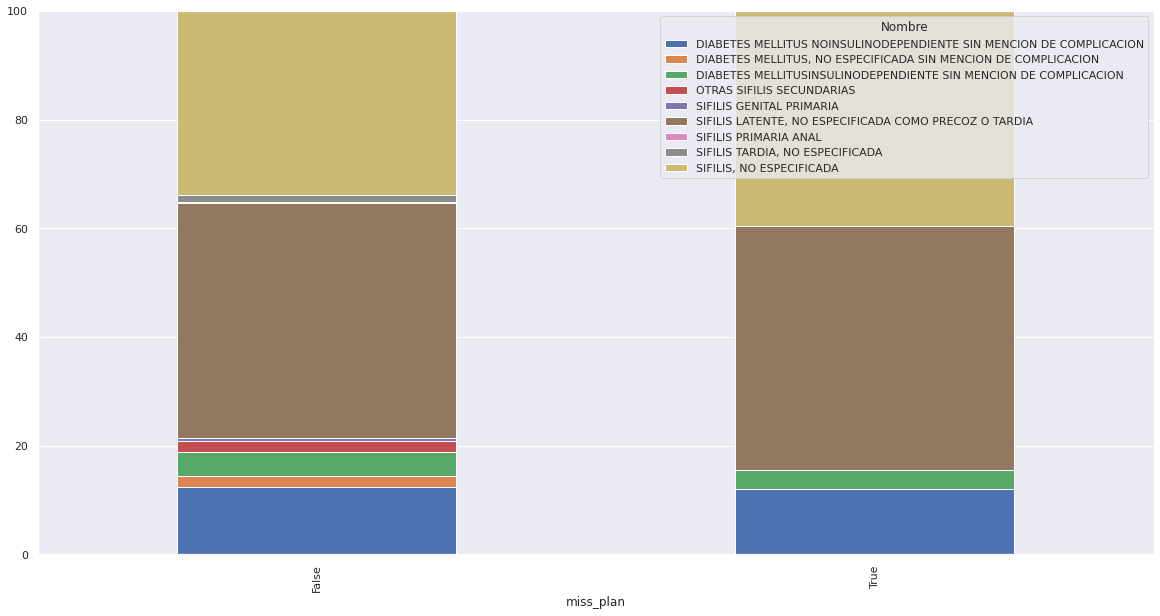

In [ ]:
sd_pivot = pd.pivot_table(plan_missing[['miss_plan','Nombre']].value_counts().to_frame().reset_index(), index='miss_plan', columns='Nombre', values=0, aggfunc='sum')
suma = sd_pivot.sum(axis=1)
sd_pivot = sd_pivot.div(suma/100, axis=0)
sd_pivot.plot.bar(stacked=True,figsize=(20,10),ylim=(0,100))

After inspecting the previous plot, we can see that the proportions for missing and non missing values are similar. Therefore, we cannot see a relationship other than the number of rows per category in the dataset. 

The rest of the null values will be dealt with on each of the different following subsections.

### Numerical features analysis

#### IDRecord

IDRecord should be numeric according to the dataset description provided by IQVIA, but it's showing as an object dtype, which indicates that it has non-numeric values in it. Let's try and look at what is happening

In [ ]:
notas[~notas.IDRecord.str.isnumeric()]

IDRecord  \
76968                               SPECIFICADA   
85091  TE, NO ESPECIFICADA COMO PRECOZ O TARDIA   
86209                              ado Repetido   

                                                  Código  \
76968                                Confirmado Repetido   
85091                                Confirmado Repetido   
86209  EMPEZÓ TAR EN DIC/15  SE REFORMULA IGUAL  TAR ...   

                                                  Nombre Tipo Plan  
76968  A/ PACIENTE CON DX DE INFECCION POR VIH HACE C...  NaN  NaN  
85091  CONTINUA CON IGUAL MANEJO TARV.  SE SOCLITA RP...  NaN  NaN  
86209                                                NaN  NaN  NaN

So as we saw in the null value analysis, we have some samples that instead of having their IDRecord, they have information from other features. Let's remove those as well as without IDRecord we can't relate the data to a specific patient and thus it proves non-useful for us.

In [ ]:
notas['IDRecord'] = pd.to_numeric(notas['IDRecord'], errors='coerce')
notas.dropna(subset=['IDRecord'], inplace = True)
notas.head(10)

IDRecord Código                                             Nombre  \
0   44600.0   A539                           SIFILIS, NO ESPECIFICADA   
1   45038.0   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
2   40391.0   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
3  106350.0   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
4  105840.0   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
5  188030.0   A539                           SIFILIS, NO ESPECIFICADA   
6   41590.0   A539                           SIFILIS, NO ESPECIFICADA   
7  111487.0   A539                           SIFILIS, NO ESPECIFICADA   
8   69603.0   E119  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
9   69563.0   A514                          OTRAS SIFILIS SECUNDARIAS   

                  Tipo                                               Plan  
0  Confirmado Repetido  - ORDENO TAR ABC +3TC +ATV/r  - PROFILAXIS NO ...  
1  Confirmado Repetido  - TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...  
2  Confirmado Repetido  usuaria la cual se ve pertinente seguimiento d...  
3  Confirmado Repetido  1. Se formula TAR (TDF/FTC+EFV)  2. S/S Paracl...  
4  Confirmado Repetido  EDUCACIÓN  Se brinda retroalimentación con rel...  
5  Confirmado Repetido  1. Continuar TAR con: ABC/3TC+EFV.  2. Tomar l...  
6  Confirmado Repetido  a) Se continua manejo iniciado 19/02/2020 a AB...  
7  Confirmado Repetido                         Control según frecuencias   
8  Confirmado Repetido  Se realiza control de enfermería el 16 de OCTU...  
9  Confirmado Repetido    1. TRATAMIENTO TDF/FTC/EFV  2. PROFILAXIS:NO...

### Categorical Features Analysis

As the name suggests, the following features should be of type String

#### Code (Código)

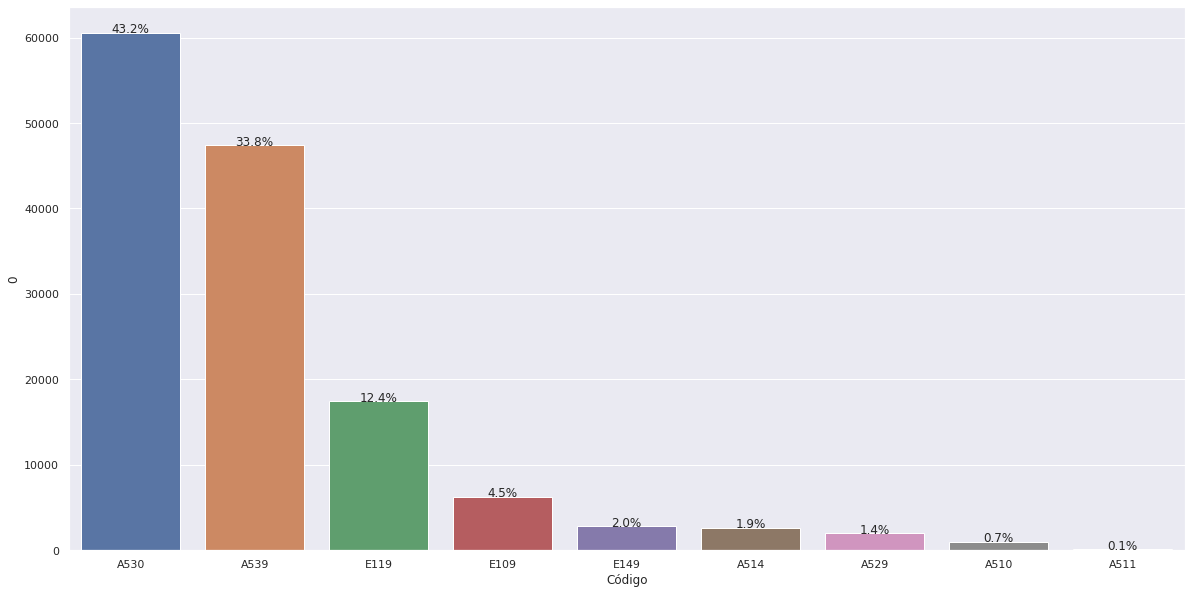

In [ ]:
enfermedades = notas.groupby('Código').size()
enfermedades = enfermedades.to_frame()
enfermedades = enfermedades.reset_index()
enfermedades = enfermedades.sort_values(by=(0),ascending=False).head(9)

fig, ax = plt.subplots(figsize=(20,10))
ax = barplot_with_percentages(x="Código", y=0, data=enfermedades, ax=ax)

We can see that we have 9 unique codes in our dataset. These codes are based on the [ICD-10](https://icd.who.int/browse10/2019) Code system, where each disease is characterized by a  unique number. In our case we have, in alphabetical order:
- [A510](https://icd.who.int/browse10/2019/en#A51.0): 
Primary genital syphilis
- [A511](https://icd.who.int/browse10/2019/en#A51.1): Primary anal syphilis
- [A514](https://icd.who.int/browse10/2019/en#A51.4): Other secondary syphilis
- [A529](https://icd.who.int/browse10/2019/en#A52.9): Late syphilis, unspecified
- [A530](https://icd.who.int/browse10/2019/en#A53.0): Latent syphilis, unspecified as early or late
- [A539](https://icd.who.int/browse10/2019/en#A53.9): Syphilis, unspecified
- [E109](https://icd.who.int/browse10/2019/en#E10.9): Type 1 diabetes mellitus
- [E119](https://icd.who.int/browse10/2019/en#E11.9): Type 2 diabetes mellitus
- [E149](https://icd.who.int/browse10/2019/en#E14.9): Unspecified diabetes mellitus


In [ ]:
code = notas.Código.value_counts().to_frame()
code['percentage'] = code.Código / sum(code.Código) * 100
code

Código  percentage
A530                                                 60586   43.221687
A539                                                 47408   33.820581
E119                                                 17439   12.440877
E109                                                  6278    4.478687
E149                                                  2808    2.003210
A514                                                  2614    1.864812
A529                                                  1970    1.405386
A510                                                   977    0.696986
A511                                                    94    0.067059
SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O ...       1    0.000713

As we can see from the barplot and the value counts, we have the different codes for the diseases plus data related to Plan, which shouldn't be here. Let's see if we can recover the Code for this sample:

In [ ]:
notas[['Código','Nombre']].value_counts().reset_index().rename({0:'Frequency'}, axis=1)

Código  \
0                                               A530   
1                                               A539   
2                                               E119   
3                                               E109   
4                                               E149   
5                                               A514   
6                                               A529   
7                                               A510   
8                                               A511   
9  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   

                                              Nombre  Frequency  
0  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...      60586  
1                           SIFILIS, NO ESPECIFICADA      47408  
2  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...      17439  
3  DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...       6278  
4  DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION...       2808  
5                          OTRAS SIFILIS SECUNDARIAS       2614  
6                    SIFILIS TARDIA, NO ESPECIFICADA       1970  
7                           SIFILIS GENITAL PRIMARIA        977  
8                              SIFILIS PRIMARIA ANAL         94  
9                                Confirmado Repetido          1

In [ ]:
notas[notas.Nombre == 'Confirmado Repetido']

IDRecord                                             Código  \
42708      30.0  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   

                    Nombre                                               Tipo  \
42708  Confirmado Repetido  *Control por Trabajo Social según frecuencia y...   

      Plan  
42708  NaN

It seems that we could move all the columns to the right starting from Code. We can then take advantage of the fact that each Code follows the ICD-10 code specification, in order to fully recover the misaligned data point.



In [ ]:
index = notas[notas.Nombre == 'Confirmado Repetido'].index
notas.loc[index, ['Nombre', 'Tipo', 'Plan']] = notas.loc[index, ['Código', 'Nombre', 'Tipo']].to_numpy()
notas.loc[index, 'Código'] = notas[notas['Nombre'] == notas.loc[index, 'Código'].iat[0]]['Código'].iloc[0]
notas.loc[index]

IDRecord Código                                             Nombre  \
42708      30.0   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   

                      Tipo                                               Plan  
42708  Confirmado Repetido  *Control por Trabajo Social según frecuencia y...

#### Name (Nombre)

Let's take a look now at Name, which represents the condition that each patient in the dataset has.

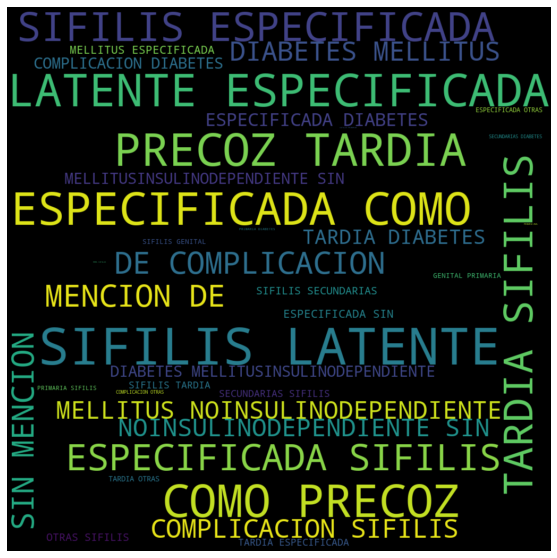

In [ ]:
wordcloud = WordCloud(width=1024, height=1024).generate(notas.Nombre.str.cat(sep=' ').replace(',',''))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [ ]:
(notas[['Código','Nombre']].value_counts(normalize=True).mul(100).round(1).astype(str) + '%').reset_index().rename({0:'Percentage'}, axis=1)

Código                                             Nombre Percentage
0   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...      43.2%
1   A539                           SIFILIS, NO ESPECIFICADA      33.8%
2   E119  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...      12.4%
3   E109  DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...       4.5%
4   E149  DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION...       2.0%
5   A514                          OTRAS SIFILIS SECUNDARIAS       1.9%
6   A529                    SIFILIS TARDIA, NO ESPECIFICADA       1.4%
7   A510                           SIFILIS GENITAL PRIMARIA       0.7%
8   A511                              SIFILIS PRIMARIA ANAL       0.1%

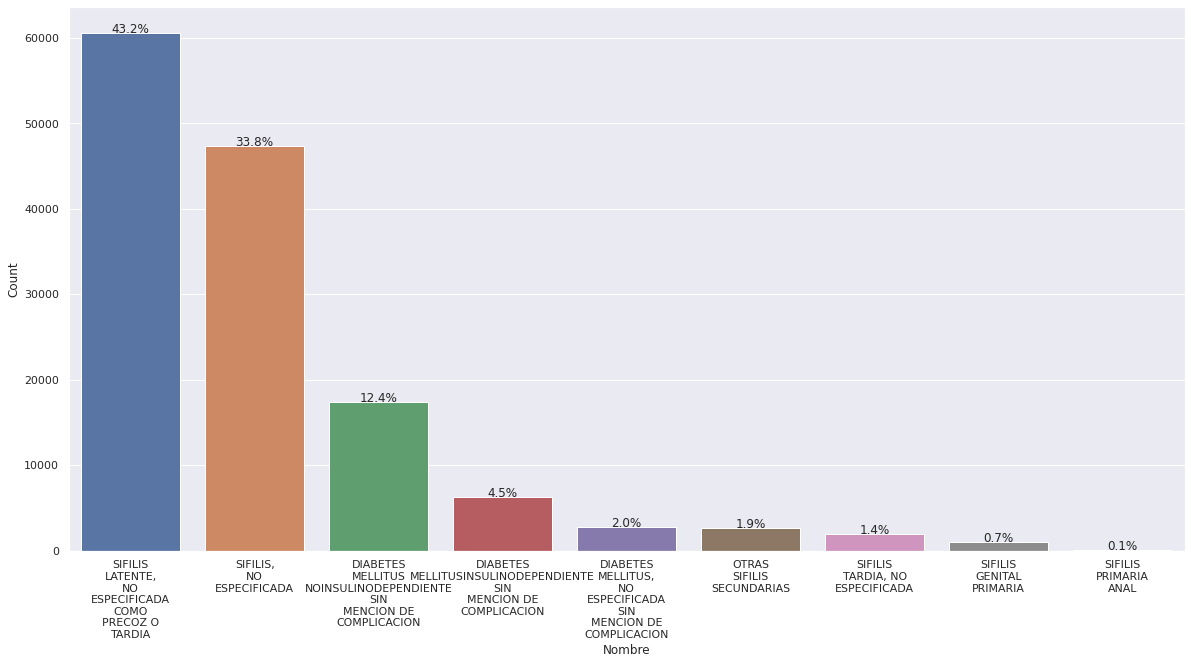

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = barplot_with_percentages(x="Nombre", y=0, data=notas[['Código', 'Nombre']].value_counts().to_frame().reset_index(), ax=ax)
ax.set(xlabel='Nombre', ylabel='Count')
wrap_labels(ax, 10)

In [ ]:
# Separated by the main two diseases
c = notas['Código'].str.slice(stop=2).value_counts(dropna=False)
p = notas['Código'].str.slice(stop=2).value_counts(dropna=False, normalize=True).mul(100).round(1).astype(str) + '%'
pd.concat([c,p], axis=1, keys=['Count', 'Percentage'])

Count Percentage
A5  113650      81.1%
E1   26525      18.9%

As we can see from the dataset, around 80% of the dataset is related to Syphilis, while the remaining 20% relates to Diabetes, making the dataset very unbalanced with respect to the target variable for prediction. It is possible we will need to find a way to balance the data to be able to correctly predict between the two target classes.

We have the same information in Name as we do in Code, as it's the string representation of the ICD-10 Code

In [ ]:
name = notas.Nombre.value_counts().to_frame()
name['percentage'] = name.Nombre / sum(name.Nombre) * 100
name

Nombre  percentage
SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O ...   60587   43.222401
SIFILIS, NO ESPECIFICADA                             47408   33.820581
DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MEN...   17439   12.440877
DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCIO...    6278    4.478687
DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION ...    2808    2.003210
OTRAS SIFILIS SECUNDARIAS                             2614    1.864812
SIFILIS TARDIA, NO ESPECIFICADA                       1970    1.405386
SIFILIS GENITAL PRIMARIA                               977    0.696986
SIFILIS PRIMARIA ANAL                                   94    0.067059

#### Type (Tipo)

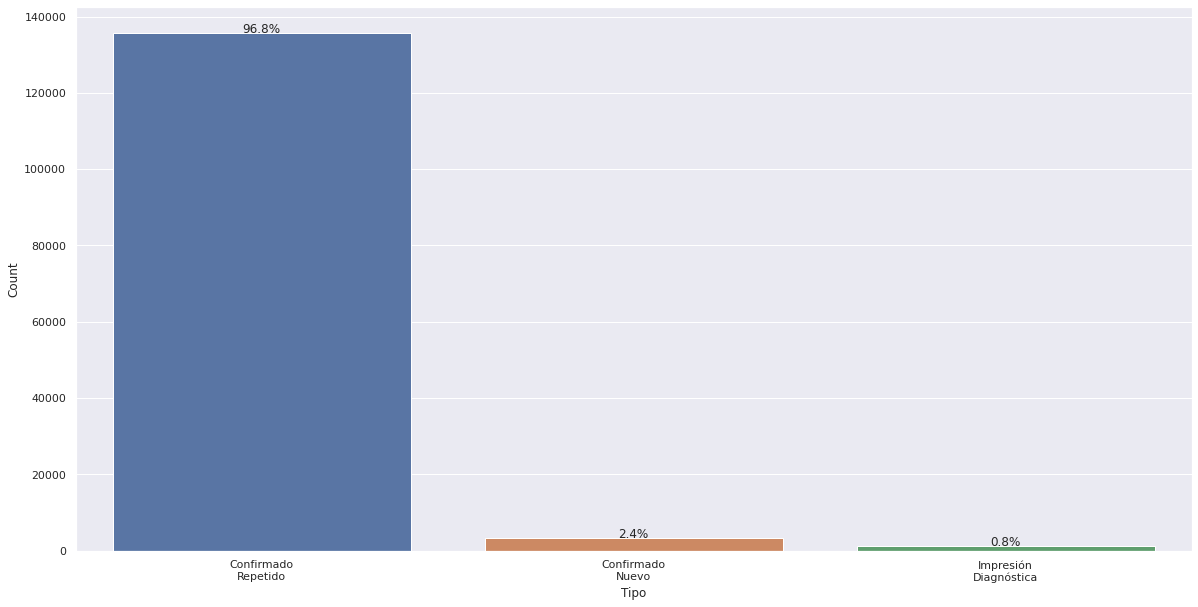

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = barplot_with_percentages(x="Tipo", y=0, data=notas[['Tipo']].value_counts().to_frame().reset_index(), ax=ax, ci=None)
ax.set(xlabel='Tipo', ylabel='Count')
wrap_labels(ax, 10)

In [ ]:
df_type = notas.Tipo.value_counts().to_frame()
df_type['percentage'] = df_type.Tipo / sum(df_type.Tipo) * 100
df_type

Tipo  percentage
Confirmado Repetido    135715   96.818263
Confirmado Nuevo         3328    2.374175
Impresión Diagnóstica    1132    0.807562

Type describes the medical daignosis type of the current record/sample. There are three categories:
- Impresión Diagnóstica: Medical impression, or the "educated guess" on the condition/disease of the patient.
- Confirmado Nuevo: The patient has just been confirmed to suffer of the disease present in Name and Code.
- Confirmado repetido: The patient had previously been diagnosed and is in a follow-up or getting further tests for their condition.

Again there is a huge unbalance in the data with respect to the type of medical diagnoses.

In [ ]:
notas['Diagnosis'] = notas['Código'].apply(lambda x: 'Sifilis' if 'A5' in x else 'Diabetes')
notas.groupby(['Diagnosis', 'Tipo']).size()

Diagnosis  Tipo                 
Diabetes   Confirmado Nuevo            612
           Confirmado Repetido       25746
           Impresión Diagnóstica       167
Sifilis    Confirmado Nuevo           2716
           Confirmado Repetido      109969
           Impresión Diagnóstica       965
dtype: int64

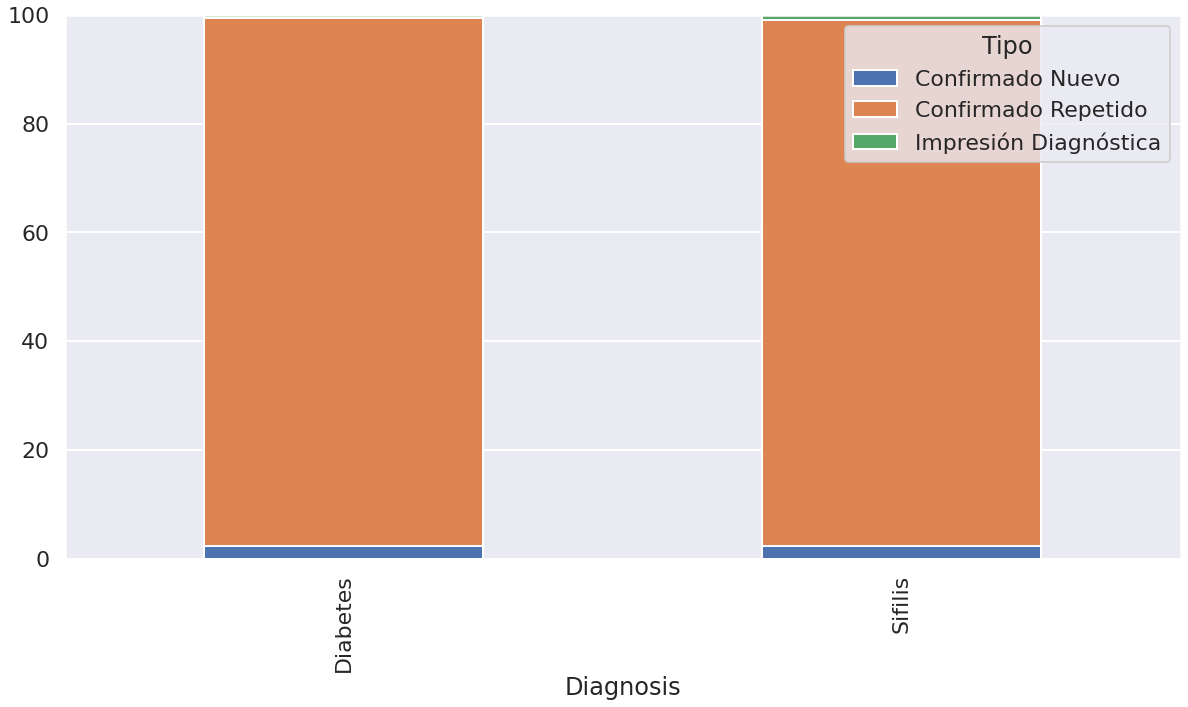

In [ ]:
with sns.plotting_context("poster"):
    sd_pivot = pd.pivot_table(notas[['Diagnosis','Tipo']].value_counts().to_frame().reset_index(), index='Diagnosis', columns='Tipo', values=0, aggfunc='sum')
    suma = sd_pivot.sum(axis=1)
    sd_pivot = sd_pivot.div(suma/100, axis=0)
    sd_pivot.plot.bar(stacked=True,figsize=(20,10),ylim=(0,100))

### Text Data Analysis

#### Plan

Let's now analyze Plan, which is of type String and contains information related to the Electronic Health Record of the patient, i.e. the Doctor's Notes.

In [ ]:
notas.Plan.to_frame()

Plan
0       - ORDENO TAR ABC +3TC +ATV/r  - PROFILAXIS NO ...
1       - TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2       usuaria la cual se ve pertinente seguimiento d...
3       1. Se formula TAR (TDF/FTC+EFV)  2. S/S Paracl...
4       EDUCACIÓN  Se brinda retroalimentación con rel...
...                                                   ...
140222  1.se reitera la importancia de estar atenta a ...
140223  Se requiere seguimiento por psicología  Se req...
140224                                       VER ANALSIS 
140225  Paciente atendido por teleasistencia bajo moda...
140226  TOMAR TRATAMIENTO TAR: TDF FTC + EFV  NO SE PU...

[140175 rows x 1 columns]

As the data is in spanish, it can contain accented characters (e.g. EDUCACIÓN). Let's replace them with their corresponding accent-less characters so they're easier to group/plot/etc.

In [ ]:
notas['Plan'] = notas.Plan.astype(str).apply(lambda x: strip_accents(x))
notas.Plan.to_frame()

Plan
0       - ORDENO TAR ABC +3TC +ATV/r  - PROFILAXIS NO ...
1       - TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2       usuaria la cual se ve pertinente seguimiento d...
3       1. Se formula TAR (TDF/FTC+EFV)  2. S/S Paracl...
4       EDUCACION  Se brinda retroalimentacion con rel...
...                                                   ...
140222  1.se reitera la importancia de estar atenta a ...
140223  Se requiere seguimiento por psicologia  Se req...
140224                                       VER ANALSIS 
140225  Paciente atendido por teleasistencia bajo moda...
140226  TOMAR TRATAMIENTO TAR: TDF FTC + EFV  NO SE PU...

[140175 rows x 1 columns]

##### Removing stopwords

Let's first download the set of Spanish stopwords so it's easier to analyze the real data present in the notes (increase signal to nosie ratio of the data)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Remove the stopwords and convert to a long string so we can operate over the data.

In [ ]:
plan = convert_to_long_string(notas.Plan)

Plot the resulting data

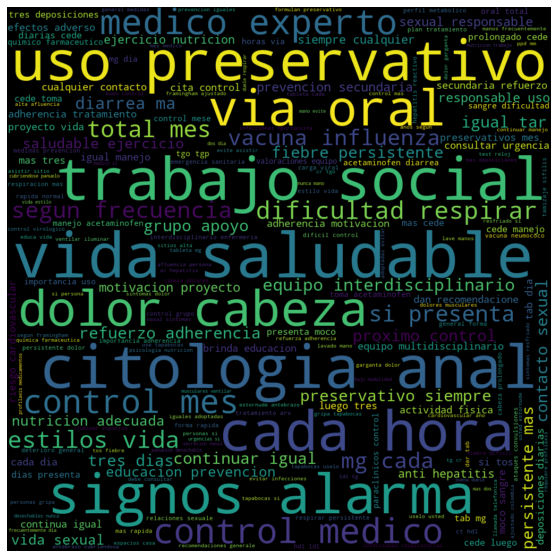

In [ ]:
wordcloud = WordCloud(width=1024, height=1024).generate(plan)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

TODO: Talk about most important words found in the wordcloud

In [ ]:
sentence_list = notas.Plan.apply(lambda x:remove_characters(remove_stop_words(x), ['-', ','])).str.replace('[0-9]','',regex=True).to_list()

vectorizer = TfidfVectorizer(use_idf=True, stop_words = stopwords.words('spanish'))
tf_idf = vectorizer.fit_transform(sentence_list)
tf_idf_df = pd.DataFrame(tf_idf[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
tf_idf_df = tf_idf_df.sort_values('TF-IDF', ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


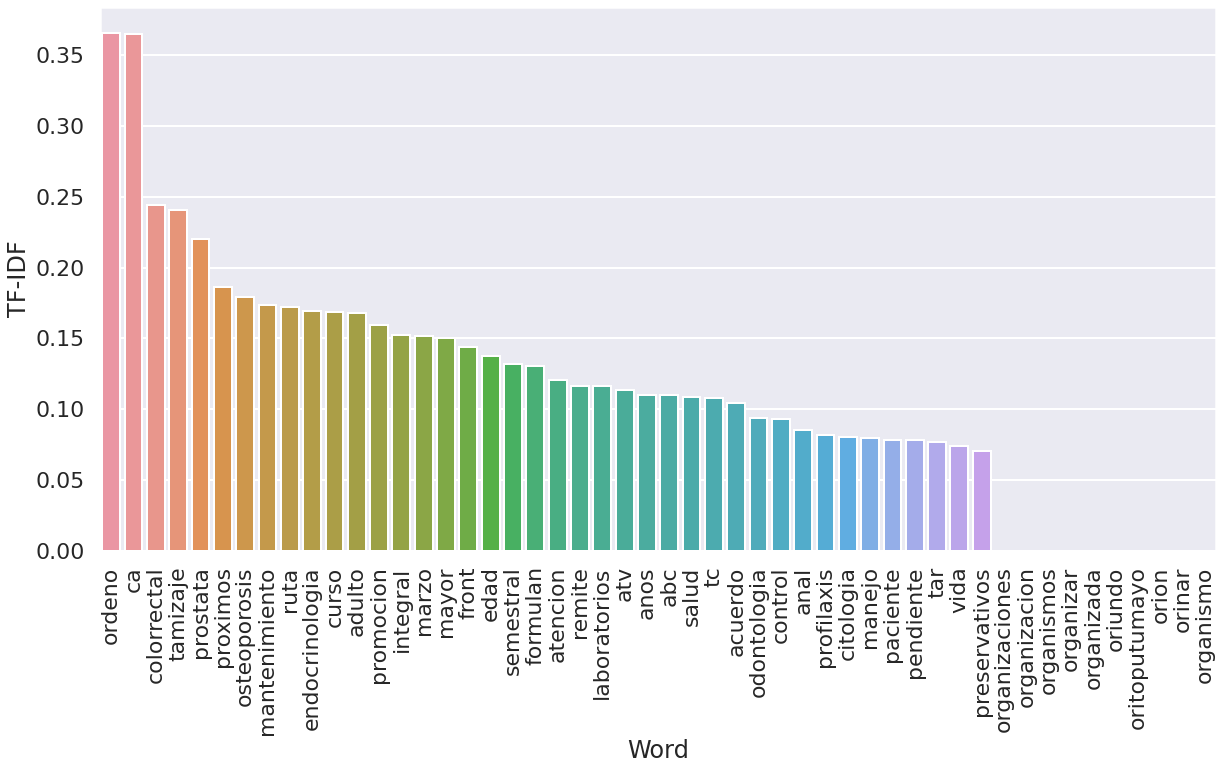

In [ ]:
with sns.plotting_context("poster"):
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.barplot(x="index", y="TF-IDF", data=tf_idf_df.iloc[:50, :].reset_index(), ax=ax)
    ax.set(xlabel='Word', ylabel='TF-IDF')
    _ = plt.xticks(rotation=90)
    # wrap_labels(ax, 10)

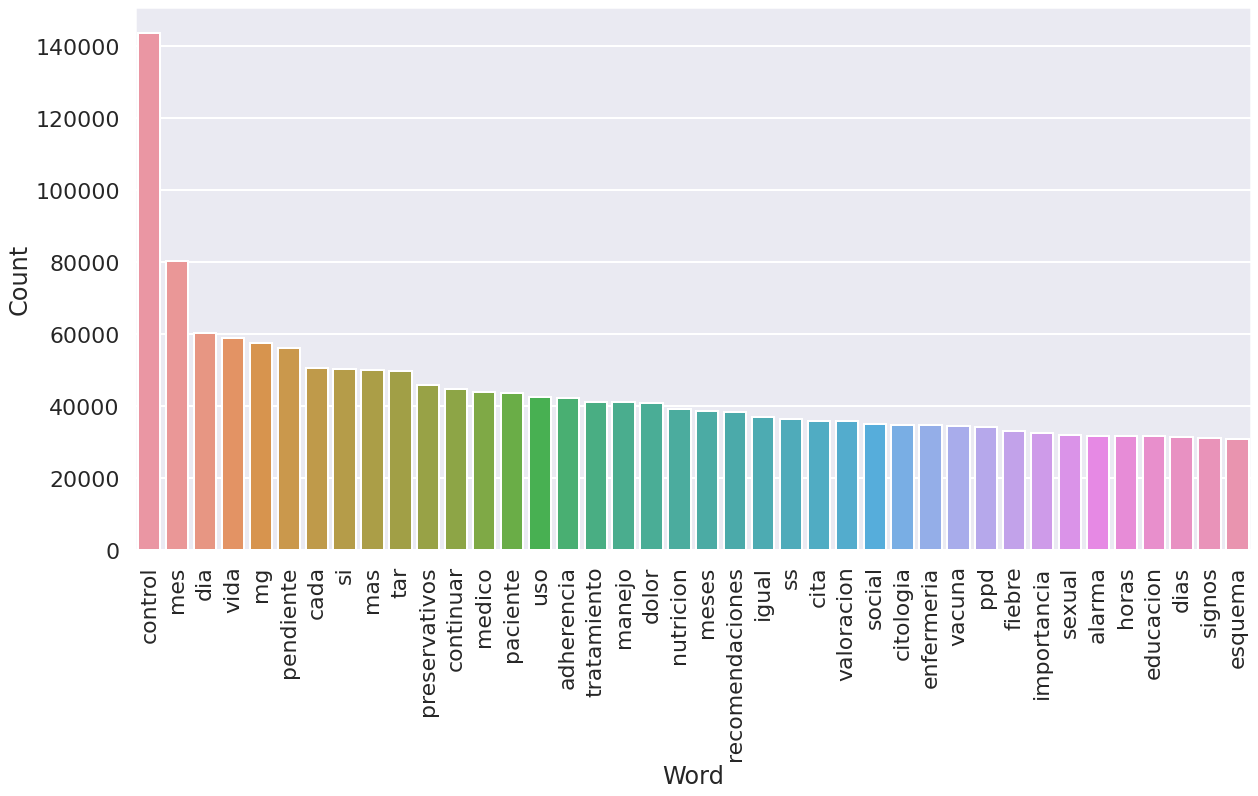

In [ ]:
plan = convert_to_long_string(notas.Plan)
plan_series = pd.Series(plan.split())

with sns.plotting_context("poster"):
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.barplot(x="index", y=0, data=plan_series.value_counts().to_frame().reset_index()[:40], ax=ax)
    ax.set(xlabel='Word', ylabel='Count')
    _ = plt.xticks(rotation=90)
    # wrap_labels(ax, 10)

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,20), constrained_layout=True, sharey=True)
with sns.plotting_context("talk"):
    for code, ax in zip(sorted(list(notas.Código.unique())), axs.flatten()):
        plan = convert_to_long_string(notas[notas.Código==code].Plan)
        plan_series = pd.Series(plan.split())

        ax = sns.barplot(x="index", y=0, data=plan_series.value_counts().to_frame().reset_index()[:10], ax=ax)
        ax.set(xlabel='Word', ylabel='Count')
        ax.set_title(f'Word count for {code}')
        _ = plt.xticks(rotation=90)
        # wrap_labels(ax, 10)

There doesn't seem to be much that can be concluded on in this list. Maybe of note is the TAR, which could indicate "Test de Antigeno Rapido", used for detecting COVID. Let's try and see if we can get anything better by splitting by disease.

In [ ]:
notas.groupby('Código')['Plan'] \
    .apply(','.join) \
    .apply(lambda x: find_top_k_words(x, 3)) \
    .to_frame() \
    .explode('Plan')

Plan
Código                    
A510        (control, 953)
A510           (vida, 497)
A510            (mas, 442)
A511          (dolor, 103)
A511            (tar, 103)
A511             (si, 101)
A514       (control, 2649)
A514          (vida, 1594)
A514            (si, 1488)
A529       (control, 1732)
A529           (vida, 921)
A529            (mas, 812)
A530      (control, 56400)
A530            (1, 30435)
A530         (vida, 28362)
A539      (control, 41284)
A539       (vacuna, 25802)
A539    (pendiente, 21110)
E109           (mes, 8914)
E109          (cada, 7942)
E109           (dia, 5853)
E119         (cada, 21003)
E119          (mes, 18219)
E119           (mg, 15104)
E149          (cada, 3858)
E149            (mg, 2964)
E149           (mes, 2865)

Of note is the mention of vaccine for A539, and pain and TAR for A511. There seems to be a higher level of control-related words for Syphilis than for Diabetes.

For Diabetes, there seems to be a lot of emphasis on mes, cada, and mg, which would indicate prescription(s) of something.

A deeper dive into n-grams and/or relationships between words, similar to what [GloVe](https://nlp.stanford.edu/projects/glove/) does would be beneficial in the near future.

TODO (Cristian): Comparar Sociodemografico con enfermedades (Nombre) de Notas

In [ ]:
notas_sociodemografico = notas.merge(sociodemografico, on='IDRecord')

In [ ]:
notas_sociodemografico.head()

IDRecord Código                    Nombre                 Tipo  \
0   44600.0   A539  SIFILIS, NO ESPECIFICADA  Confirmado Repetido   
1   44600.0   A539  SIFILIS, NO ESPECIFICADA  Confirmado Repetido   
2   44600.0   A539  SIFILIS, NO ESPECIFICADA  Confirmado Repetido   
3   44600.0   A539  SIFILIS, NO ESPECIFICADA  Confirmado Repetido   
4   44600.0   A539  SIFILIS, NO ESPECIFICADA  Confirmado Repetido   

                                                Plan Diagnosis  Edad  Genero  \
0  - ORDENO TAR ABC +3TC +ATV/r  - PROFILAXIS NO ...   Sifilis    53  Hombre   
1  PACIENTE QUE SE ENCUENTRA EN TRATAMIENTO ANTIR...   Sifilis    53  Hombre   
2  CONSERVAR ADHERENCIA AL TRATAMIENTO   ACUDIR A...   Sifilis    53  Hombre   
3  1. CONTINUA MISMO TAR TDF+FTC+ATV/r BICONJUGAD...   Sifilis    53  Hombre   
4  PROXIMA CONSULTA CON ENFERMERIA EN 6 MESES;  S...   Sifilis    53  Hombre   

  GrupoEtnico AreaResidencial EstadoCivil TSangre  
0     Mestizo     Zona Urbana     Soltero      NA  
1     Mestizo     Zona Urbana     Soltero      NA  
2     Mestizo     Zona Urbana     Soltero      NA  
3     Mestizo     Zona Urbana     Soltero      NA  
4     Mestizo     Zona Urbana     Soltero      NA

In [ ]:
bins = [0,20,40,60,80,100]
notas_sociodemografico['Edad'] = pd.cut(notas_sociodemografico['Edad'], bins)
notas_sociodemografico

IDRecord Código                                             Nombre  \
0        44600.0   A539                           SIFILIS, NO ESPECIFICADA   
1        44600.0   A539                           SIFILIS, NO ESPECIFICADA   
2        44600.0   A539                           SIFILIS, NO ESPECIFICADA   
3        44600.0   A539                           SIFILIS, NO ESPECIFICADA   
4        44600.0   A539                           SIFILIS, NO ESPECIFICADA   
...          ...    ...                                                ...   
140167   85348.0   A539                           SIFILIS, NO ESPECIFICADA   
140168  118895.0   E119  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
140169  106323.0   A539                           SIFILIS, NO ESPECIFICADA   
140170   84159.0   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
140171   66469.0   E119  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   

                       Tipo  \
0       Confirmado Repetido   
1       Confirmado Repetido   
2       Confirmado Repetido   
3       Confirmado Repetido   
4       Confirmado Repetido   
...                     ...   
140167  Confirmado Repetido   
140168  Confirmado Repetido   
140169  Confirmado Repetido   
140170  Confirmado Repetido   
140171  Confirmado Repetido   

                                                     Plan Diagnosis  \
0       - ORDENO TAR ABC +3TC +ATV/r  - PROFILAXIS NO ...   Sifilis   
1       PACIENTE QUE SE ENCUENTRA EN TRATAMIENTO ANTIR...   Sifilis   
2       CONSERVAR ADHERENCIA AL TRATAMIENTO   ACUDIR A...   Sifilis   
3       1. CONTINUA MISMO TAR TDF+FTC+ATV/r BICONJUGAD...   Sifilis   
4       PROXIMA CONSULTA CON ENFERMERIA EN 6 MESES;  S...   Sifilis   
...                                                   ...       ...   
140167  *PLAN:  - TARV: NAIVE  - OTRA MEDICACION:  NO ...   Sifilis   
140168  1. PIPERACILINA TAZOBACTAM 4,5 GR IV CADA 8 HO...  Diabetes   
140169  CONTINUAR TAR CON:tdf ftc atv/r   TOMAR EL TAR...   Sifilis   
140170    Plan de manejo:  pendiente  Control de parac...   Sifilis   
140171  SE INFORMA SOBRE SERVICIOS DEL PROGRAMA PALLIU...  Diabetes   

             Edad  Genero GrupoEtnico AreaResidencial  EstadoCivil TSangre  
0        (40, 60]  Hombre     Mestizo     Zona Urbana      Soltero      NA  
1        (40, 60]  Hombre     Mestizo     Zona Urbana      Soltero      NA  
2        (40, 60]  Hombre     Mestizo     Zona Urbana      Soltero      NA  
3        (40, 60]  Hombre     Mestizo     Zona Urbana      Soltero      NA  
4        (40, 60]  Hombre     Mestizo     Zona Urbana      Soltero      NA  
...           ...     ...         ...             ...          ...     ...  
140167   (20, 40]  Hombre     Mestizo     Zona Urbana      Soltero      NA  
140168   (60, 80]  Hombre     Mestizo     Zona Urbana       Casado      O+  
140169   (20, 40]  Hombre     Mestizo     Zona Urbana  Desconocido      O+  
140170   (20, 40]   Mujer      Blanco     Zona Urbana      Soltero      NA  
140171  (80, 100]   Mujer      Blanco     Zona Urbana      Viudo/a      O+  

[140172 rows x 12 columns]

In [ ]:
notas_edades = notas_sociodemografico.groupby(['Nombre','Edad'])[['Nombre','Edad']].size().to_frame()
notas_edades.head(10)

0
Nombre                                             Edad           
DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MEN... (0, 20]       0
                                                   (20, 40]    660
                                                   (40, 60]   5479
                                                   (60, 80]   7142
                                                   (80, 100]  4043
DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION ... (0, 20]       0
                                                   (20, 40]    125
                                                   (40, 60]    767
                                                   (60, 80]   1100
                                                   (80, 100]   816

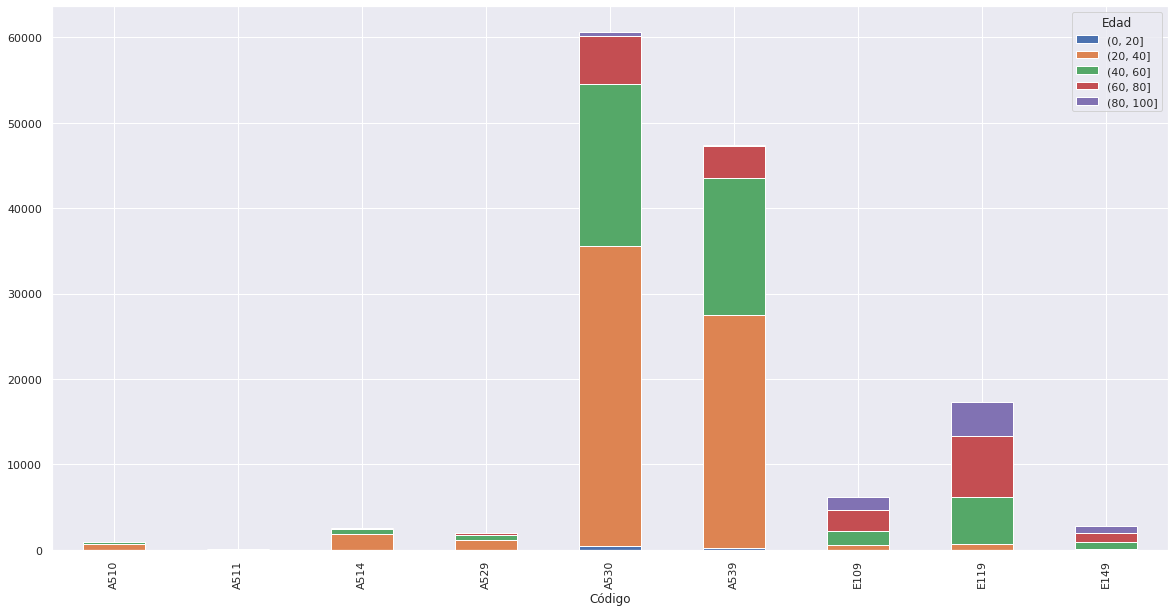

In [ ]:
notas_sociodemografico.groupby(['Código','Edad'])[['Código','Edad']].size().unstack().plot(kind='bar', stacked=True)

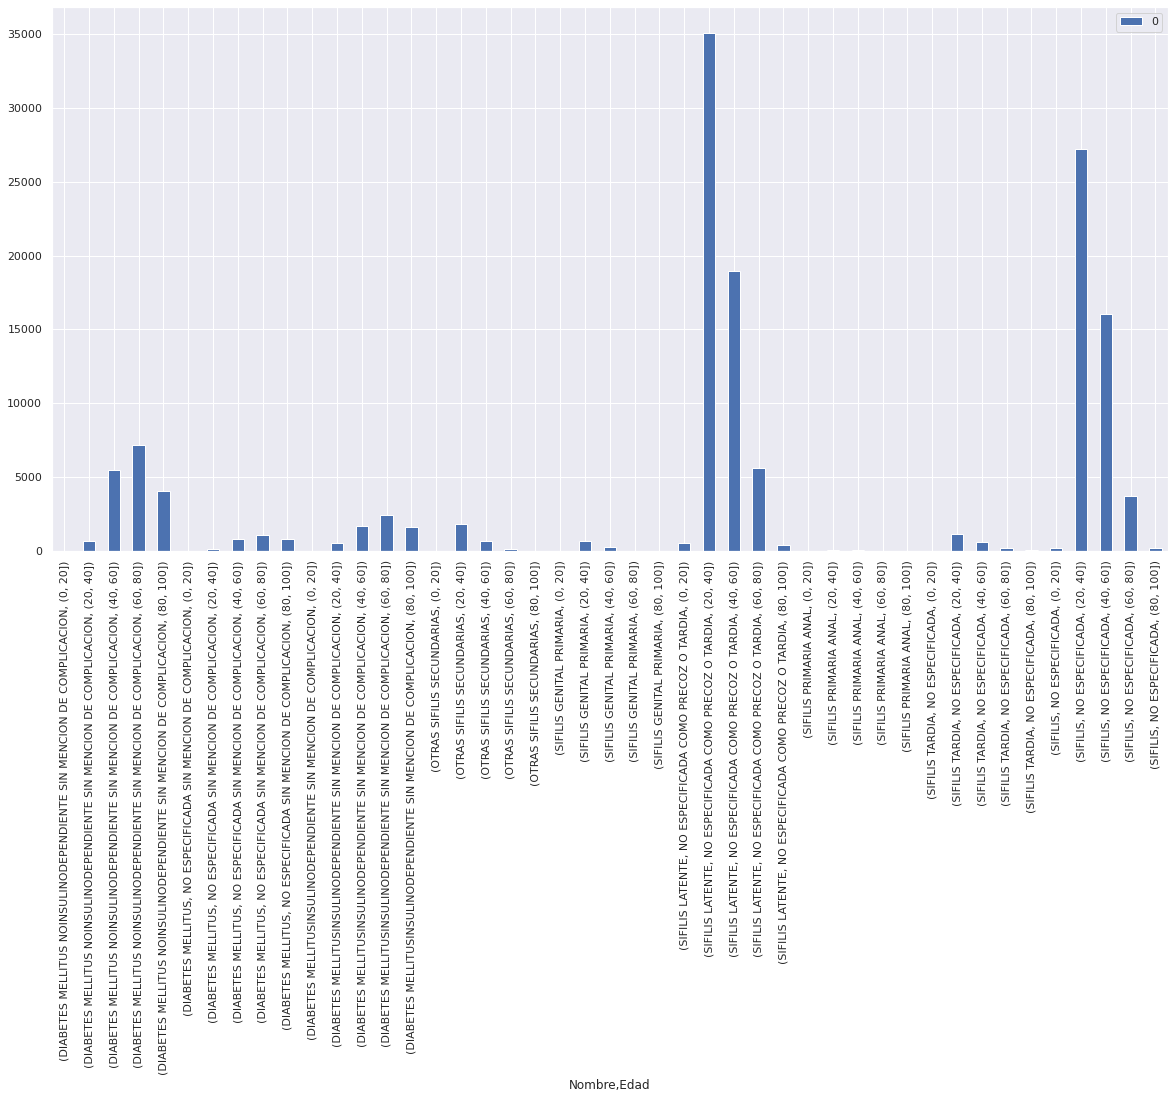

In [ ]:
my_plot = notas_edades.plot(kind='bar', stacked=True)
plt.show()

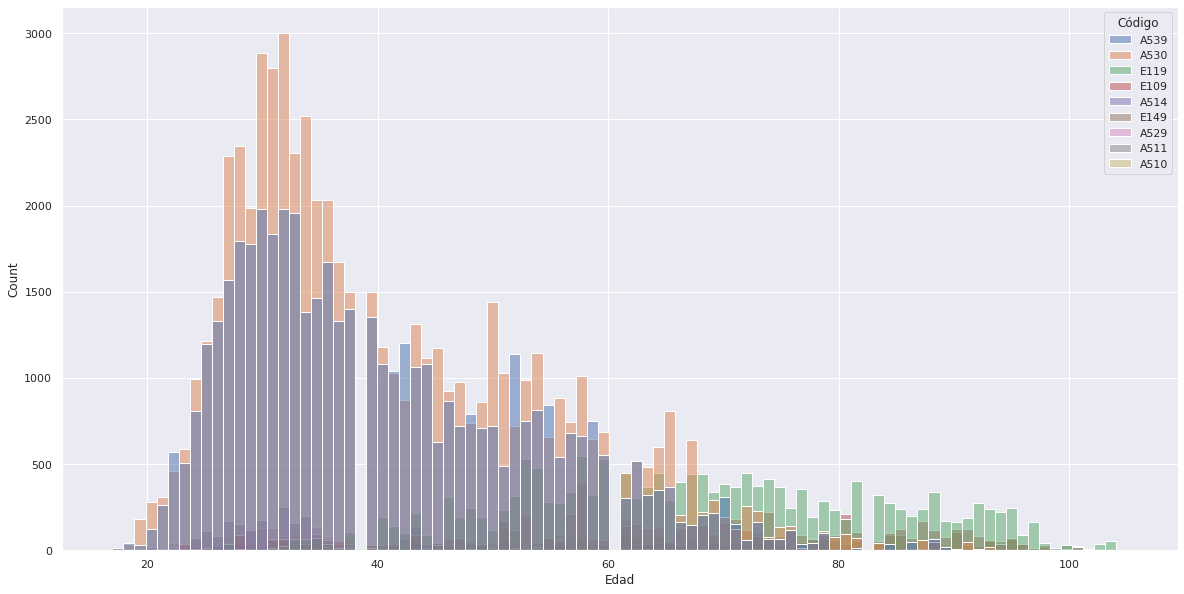

In [ ]:
sns.histplot(data=notas.merge(sociodemografico, on='IDRecord'), x="Edad", hue='Código')

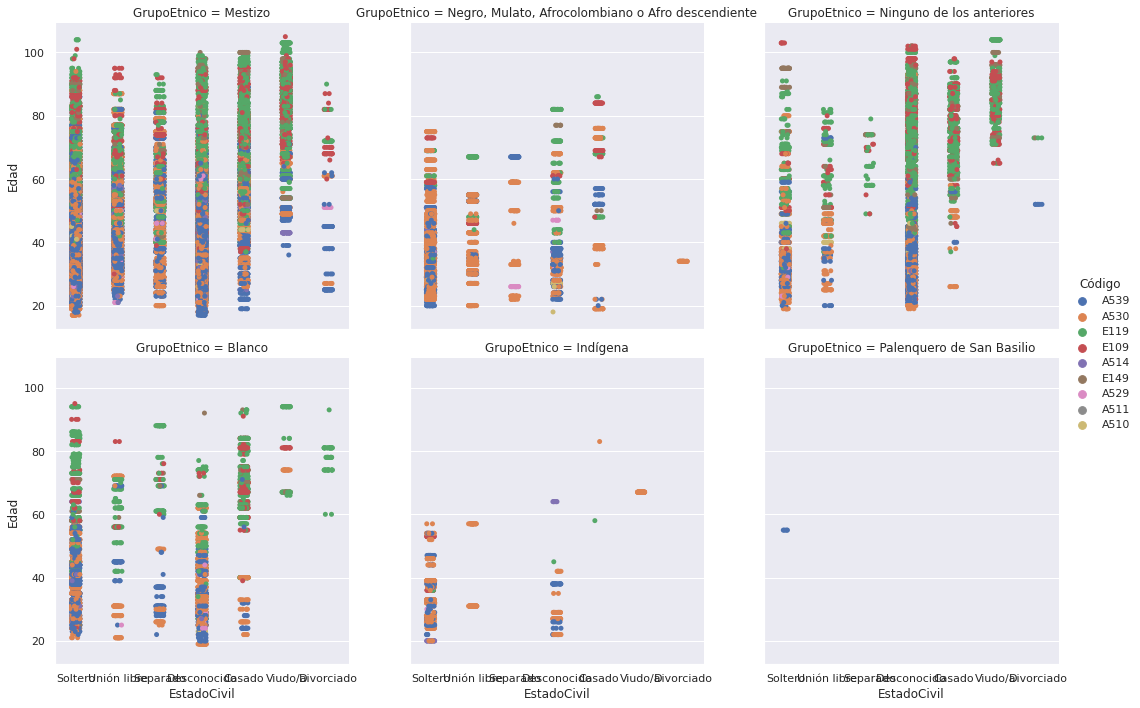

In [ ]:
g = sns.catplot(
    x="EstadoCivil",
    y="Edad",
    hue="Código",
    col="GrupoEtnico",
    col_wrap=3,
    data=notas.merge(sociodemografico, on='IDRecord')
    )

TODO (Charic): Comparar Laboratorios con enfermedades (Nombre) de Notas 

## Laboratorios file and Notas file joint analysis

Let's merge Laboratorios and Notas data to analyse what information they hold. Each RecordID corresponds to the information of a person, so it makes sense to merge them on this column.

In [ ]:
notas.IDRecord = notas.IDRecord.astype(dtype='int')

In [ ]:
lab_notes_union = pd.merge(laboratorios, notas, how='outer', on='IDRecord', suffixes=('_labs', '_notes'))
lab_notes_union.shape

(5072171, 10)

In [ ]:
a = lab_notes_union[lab_notes_union[['Nombre_notes', 'Código']].isnull().any(axis=1)]
print("Shape of rows without 'Nombre_notes', 'Código' values: ", a.shape)
b = lab_notes_union[lab_notes_union[['Nombre_labs', 'Codigo']].isnull().any(axis=1)]
print("Shape rows without 'Nombre_labs', 'Codigo' values: ", b.shape)

Shape of rows without 'Nombre_notes', 'Código' values:  (168, 10)
Shape rows without 'Nombre_labs', 'Codigo' values:  (16130, 10)


In [ ]:
print("Unique IDRecords for Notas: ", notas.IDRecord.unique().size)
print("Unique IDRecords for Laboratorios: ", laboratorios.IDRecord.unique().size)
print("Unique IDRecords of rows without 'Nombre_notes', 'Código' values from Notas: ", a.IDRecord.unique().size)
print("Unique IDRecords of rows without 'Nombre_labs', 'Codigo' values from Laboratorios: ", b.IDRecord.unique().size)

Unique IDRecords for Notas:  9270
Unique IDRecords for Laboratorios:  5964
Unique IDRecords of rows without 'Nombre_notes', 'Código' values from Notas:  12
Unique IDRecords of rows without 'Nombre_labs', 'Codigo' values from Laboratorios:  3318


In [ ]:
lab_notes = pd.merge(laboratorios, notas, how='inner', on='IDRecord', suffixes=('_labs', '_notes'))

In [ ]:
lab_notes.head(8)

IDRecord  Codigo                 Nombre_labs               Fecha Valor  \
0     95627  902045  TIEMPO DE PROTROMBINA (PT) 2022-02-22 18:43:00   NaN   
1     95627  902045  TIEMPO DE PROTROMBINA (PT) 2022-02-22 18:43:00   NaN   
2     95627  902045  TIEMPO DE PROTROMBINA (PT) 2022-02-22 18:43:00   NaN   
3     95627  902045  TIEMPO DE PROTROMBINA (PT) 2022-02-22 18:43:00   NaN   
4     95627  902045  TIEMPO DE PROTROMBINA (PT) 2022-02-22 18:43:00   NaN   
5     95627  902045  TIEMPO DE PROTROMBINA (PT) 2022-02-22 18:43:00   NaN   
6     95627  902045  TIEMPO DE PROTROMBINA (PT) 2022-02-22 18:43:00   NaN   
7     95627  902045  TIEMPO DE PROTROMBINA (PT) 2022-02-22 18:43:00   NaN   

  Código                                       Nombre_notes  \
0   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
1   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
2   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
3   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
4   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
5   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
6   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   
7   A530  SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...   

                  Tipo                                               Plan  \
0  Confirmado Repetido                                       VER ANALISIS   
1  Confirmado Repetido  NOTIFICAR A TIEMPO LA FECHAS DE POSIBLE VIAJE ...   
2  Confirmado Repetido  - TDF/FTC+DTG  - CONTROL DE HEP C (EPCLUSA)  -...   
3  Confirmado Repetido  PLAN  DE ENFERMERIA    COMO SE DETECTA EL CANC...   
4  Confirmado Repetido    Plan de tratamiento  PROXIMO CONTROL CON: Me...   
5  Confirmado Repetido  - TDF/FTC+DTG  - CONTROL DE HEP C (EPCLUSA)  -...   
6  Confirmado Repetido  *Control por Trabajo Social segun frecuencia y...   
7  Confirmado Repetido  IMPORTANCIA DE CUMPLIMIENTO A LOS CONTROLES Y ...   

  Diagnosis  
0   Sifilis  
1   Sifilis  
2   Sifilis  
3   Sifilis  
4   Sifilis  
5   Sifilis  
6   Sifilis  
7   Sifilis

The new merged table lab_notes contains 5055873 rows corresponding to **5962 unique patients**. Given that the IDRecord of 168 Notes and 16130 Laboratories tests did not correspond to each other, there are 16298 rows that are not included in the final table. 

The Notas file contains 9270 unique IDRecords and the Laboratorios file has 5964 unique IDRecords. After merging the tables, the lost rows correspond to 12 unique IDRecords lost from Notas and 3318 unique IDRecords lost from Labratorios, which gives a total of **3330 people who are not included in the final table** (the not included 16298 rows correspond to them).

For Notas the percentage of lost people in the merged table is 0.13% which is not very important, however for Laboratorios the percentage of lost people in the merged table is 55.6%, which is considerable. So, from the 9282 unique IDRecords from both tables, we work with 5962.


Let's take a look to a one IDRecord information

In [ ]:
lab_notes[lab_notes.IDRecord == 88761]

IDRecord  Codigo                                        Nombre_labs  \
92461      88761  902209  HEMOGRAMA III (HEMOGLOBINA, HEMATOCRITO, RECUE...   
92462      88761  902209  HEMOGRAMA III (HEMOGLOBINA, HEMATOCRITO, RECUE...   
92463      88761  902209  HEMOGRAMA III (HEMOGLOBINA, HEMATOCRITO, RECUE...   
92464      88761  902209  HEMOGRAMA III (HEMOGLOBINA, HEMATOCRITO, RECUE...   
92465      88761  902209  HEMOGRAMA III (HEMOGLOBINA, HEMATOCRITO, RECUE...   
...          ...     ...                                                ...   
105227     88761  903846                                       HIERRO TOTAL   
105228     88761  903846                                       HIERRO TOTAL   
105229     88761  903846                                       HIERRO TOTAL   
105230     88761  903846                                       HIERRO TOTAL   
105231     88761  903846                                       HIERRO TOTAL   

                     Fecha Valor Código  \
92461  2021-05-05 23:51:00   NaN   E119   
92462  2021-05-05 23:51:00   NaN   E119   
92463  2021-05-05 23:51:00   NaN   E119   
92464  2021-05-05 23:51:00   NaN   E119   
92465  2021-05-05 23:51:00   NaN   E119   
...                    ...   ...    ...   
105227 2020-12-11 00:00:00  62.8   E119   
105228 2020-12-11 00:00:00  62.8   E119   
105229 2020-12-11 00:00:00  62.8   E119   
105230 2020-12-11 00:00:00  62.8   E119   
105231 2020-12-11 00:00:00  62.8   E119   

                                             Nombre_notes  \
92461   DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
92462   DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
92463   DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
92464   DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
92465   DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
...                                                   ...   
105227  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
105228  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
105229  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
105230  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
105231  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   

                       Tipo  \
92461   Confirmado Repetido   
92462   Confirmado Repetido   
92463   Confirmado Repetido   
92464   Confirmado Repetido   
92465   Confirmado Repetido   
...                     ...   
105227  Confirmado Repetido   
105228  Confirmado Repetido   
105229  Confirmado Repetido   
105230  Confirmado Repetido   
105231  Confirmado Repetido   

                                                     Plan Diagnosis  
92461   LOSARTAN 50 MG CADA DIA  NIFEDIPINO 30 MG CADA...  Diabetes  
92462   Control con nefrologia en un mes.  Valoracion ...  Diabetes  
92463   Psicoeducacion respecto a factores de riesgo y...  Diabetes  
92464   SE INDICA DIETA BLANDA HIPOSODICA FRACCCIONADA...  Diabetes  
92465   SS// PARACLINICOS PROGRAMA NEFROPROTECCION, TO...  Diabetes  
...                                                   ...       ...  
105227  -DIETA NORMOCALORICA, HIPOGLUCIDA, HIPOSODICA ...  Diabetes  
105228  Psicoeducacion respecto a factores de riesgo y...  Diabetes  
105229  Losartan 50 mg cada dia  Nifedipino 30 mg cada...  Diabetes  
105230  -Fortalecer los?buenos estilos de vida saludab...  Diabetes  
105231  SE DEJAN MEDICAMENTOS ASI:LOSARTAN 50 MG CADA ...  Diabetes  

[12771 rows x 10 columns]

In [ ]:
laboratorios[laboratorios.IDRecord == 88761]

IDRecord  Codigo                                             Nombre  \
62         88761  902209  HEMOGRAMA III (HEMOGLOBINA, HEMATOCRITO, RECUE...   
446        88761  903426  HEMOGLOBINA GLICOSILADA POR ANTICUERPOS MONOCL...   
770        88761  903426  HEMOGLOBINA GLICOSILADA POR ANTICUERPOS MONOCL...   
884        88761  903426  HEMOGLOBINA GLICOSILADA POR ANTICUERPOS MONOCL...   
1095       88761  903603                          CALCIO ABSORCIÓN ATÓMICA    
...          ...     ...                                                ...   
186990     88761  907106                     PARCIAL DE ORINA - UROANALISIS   
187656     88761  907106                     PARCIAL DE ORINA - UROANALISIS   
187885     88761  907106                     PARCIAL DE ORINA - UROANALISIS   
189528     88761  903016                                         FERRITINA    
189541     88761  903846                                       HIERRO TOTAL   

                     Fecha                           Valor  
62     2021-05-05 23:51:00                             NaN  
446    2021-04-09 12:06:00                             NaN  
770    2021-07-10 03:46:00                            6.50  
884    2021-04-12 03:21:00                            7.70  
1095   2021-04-12 03:21:00                            9.50  
...                    ...                             ...  
186990 2021-10-03 00:00:00  Proteínas 150 mg, leucocitos 1  
187656 2020-08-12 00:00:00   Proteínas 75 mg, resto normal  
187885 2021-02-09 00:00:00  PH 7.0 , D 1009 , PROTEINAS 15  
189528 2020-12-11 00:00:00                             170  
189541 2020-12-11 00:00:00                            62.8  

[387 rows x 5 columns]

In [ ]:
notas[notas.IDRecord == 88761].head(5)

IDRecord Código                                             Nombre  \
915       88761   E119  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
5057      88761   E119  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
5405      88761   E119  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
8957      88761   E119  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   
17493     88761   E119  DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...   

                      Tipo                                               Plan  \
915    Confirmado Repetido  LOSARTAN 50 MG CADA DIA  NIFEDIPINO 30 MG CADA...   
5057   Confirmado Repetido  Control con nefrologia en un mes.  Valoracion ...   
5405   Confirmado Repetido  Psicoeducacion respecto a factores de riesgo y...   
8957   Confirmado Repetido  SE INDICA DIETA BLANDA HIPOSODICA FRACCCIONADA...   
17493  Confirmado Repetido  SS// PARACLINICOS PROGRAMA NEFROPROTECCION, TO...   

      Diagnosis  
915    Diabetes  
5057   Diabetes  
5405   Diabetes  
8957   Diabetes  
17493  Diabetes

An specfic IDRecord may have many rows in Laboratorios and many rows in Notas. The later contains the column Date which helps to place the lab results in time. However, Notas does not, which complicates our matching between lab results and notes. We cannot be sure if a note mentions one or more lab results or if a lab result has one or more notes related. 

There are many lab tets done for a particular name in notes. However, after an initial inspection, we can see that there are many lab tests names that are similar to each other. Lets see the Nombre column for Laboratorios. First we lower case the column, strip blank spaces at the start and end of sentences, and strip accents. Then, we use the Jaccard coefficient to compare each row to the others in order to find similar names. 

In [ ]:
name_code["names"] = name_code.Nombre.str.lower().str.strip().apply(lambda x: strip_accents(x))

In [ ]:
def jaccard_coeff(series):

  jacc = np.zeros((len(series), len(series)))
  index = []
  for i, phrase1 in enumerate(series):
    for j, phrase2 in enumerate(series):
      s1, s2 = set(phrase1.split()), set(phrase2.split())
      jacc[i][j] = len(s1.intersection(s2)) / len(s1.union(s2))
    jacc[i][i] = 0
    if np.any(jacc[i]>= 0.5):
      index.append(True)
    else:
      index.append(False)

  return jacc, index

jacc, simi  = jaccard_coeff(name_code["names"])
name_code[simi].sort_values(by=["names"])["names"].head(20)

30     *hemograma iv (hemoglobina, hematocrito, recue...
65                       acido folico (folatos) en suero
147                  acido folico [folatos] en suero . .
41                  acido urico en suero u otros fluidos
36                                              albumina
129                                         albumina . .
146                            albumina en orina de 24 h
35                          albuminuria en orina parcial
75     baciloscopia coloracion acido alcohol-resisten...
71     baciloscopia coloracion acido alcohol-resisten...
99     citomegalovirus, anticuerpos ig g (cmv-g) por eia
110    citomegalovirus, anticuerpos ig m (cmv-m) por eia
6           colesterol de baja densidad (ldl) enzimatico
46     colesterol de baja densidad (ldl) inmunologico...
51                                            creatinina
0                                             creatinina
95                                 creatinina depuracion
74                           cr

After inspecting the result for similar names, we can see that there are some repeated names like 'creatina' and other names the differentiate only by the use of '[ ]' instead of '( )'. Also, there are names that have some periods at the end of the sentence like 'albumina . .' vs. 'albumina'. Taking this findings in mind, we inspect for those elements.

In [ ]:
name_code[name_code["names"].apply(lambda x: ('.' in x) or ('(' in x) or ('[' in x))].sort_values(by=["names"])["names"].head(10)

30     *hemograma iv (hemoglobina, hematocrito, recue...
65                       acido folico (folatos) en suero
147                  acido folico [folatos] en suero . .
129                                         albumina . .
145                       alfa fetoproteina (afp) serica
90                 antigeno especifico de prostata (psa)
75     baciloscopia coloracion acido alcohol-resisten...
71     baciloscopia coloracion acido alcohol-resisten...
77            capacidad de combinacion del hierro (tibc)
99     citomegalovirus, anticuerpos ig g (cmv-g) por eia
Name: names, dtype: object

Now, lets apply these corrections for the Laboratorios file so that it is easier to group by test names

In [ ]:
laboratorios["name"] = laboratorios.Nombre.str.lower().str.strip().apply(lambda x: strip_accents(x)) \
.str.replace('[', '(').str.replace(']',')') \
.str.replace(r'\s(\.+)', '', regex=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


Finally, we see that we have more names of test that are repeated. Moreover, almos all of them have the same name and different codes.

In [ ]:
name_code_clean = laboratorios[['name', 'Codigo']].value_counts().reset_index().rename({0:'Count'}, axis=1)
name_code_clean[name_code_clean.name.duplicated(keep=False)].sort_values(['name'])

name    Codigo  Count
152                    acido folico (folatos) en suero    903505      1
65                     acido folico (folatos) en suero    903105     60
125                                           albumina    501739      2
36                                            albumina    903803    973
0                                           creatinina    903895  11712
51                                          creatinina  903895..    129
98   hormona estimulante del tiroides (tsh) ultrase...     60281      8
21   hormona estimulante del tiroides (tsh) ultrase...    904904   3411
158                                            potasio     60198      1
34                                             potasio    903859   1101
5    transaminasa glutamico oxalacetica o aspartato...    903867   9269
136  transaminasa glutamico oxalacetica o aspartato...     60242      1
137  transaminasa glutamico oxalacetica o aspartato...     60241      1
83   transaminasa glutamico piruvica o alanino amin...     60232     18
66   transaminasa glutamico piruvica o alanino amin...     60231     58
68                                       trigliceridos     60101     52
3                                        trigliceridos    903868   9905

In [ ]:
lab_notes_clean = pd.merge(laboratorios, notas, how='inner', on='IDRecord', suffixes=('_labs', '_notes'))

To be able to see the Notas names better, we abbreviate some of the longest names.

In [ ]:
lab_notes_clean.Nombre_notes.replace({'DIABETES MELLITUS NOINSULINODEPENDIENTE SIN MENCION DE COMPLICACION':'DIABETES M. NO INSULINODEPENDIENTE S.M.C.',
          'DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION DE COMPLICACION':'DIABETES M., NO ESPECIFICADA S.M.C.',
          'DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCION DE COMPLICACION':'DIABETES M. INSULINODEPENDIENTE S.M.C',
          'SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O TARDIA':'SIF. LATENTE, NO ESP. COMO PRECOZ O TARDIA'}, inplace=True)

We do the same for the longest names in Laboratorios file

In [ ]:
lab_notes_clean.name = lab_notes_clean.name.apply(lambda x: re.sub(r'\(([^)]+)\)', '', x) if 'hemograma' in x else x)
lab_notes_clean[lab_notes_clean.name.str.contains('hemograma', regex=False)].name.head(5)

40    hemograma iii  metodo automatico
41    hemograma iii  metodo automatico
42    hemograma iii  metodo automatico
43    hemograma iii  metodo automatico
44    hemograma iii  metodo automatico
Name: name, dtype: object

In [ ]:
nombres = lab_notes_clean.groupby(["Nombre_notes", "name"]).size().to_frame('counts').reset_index("name")

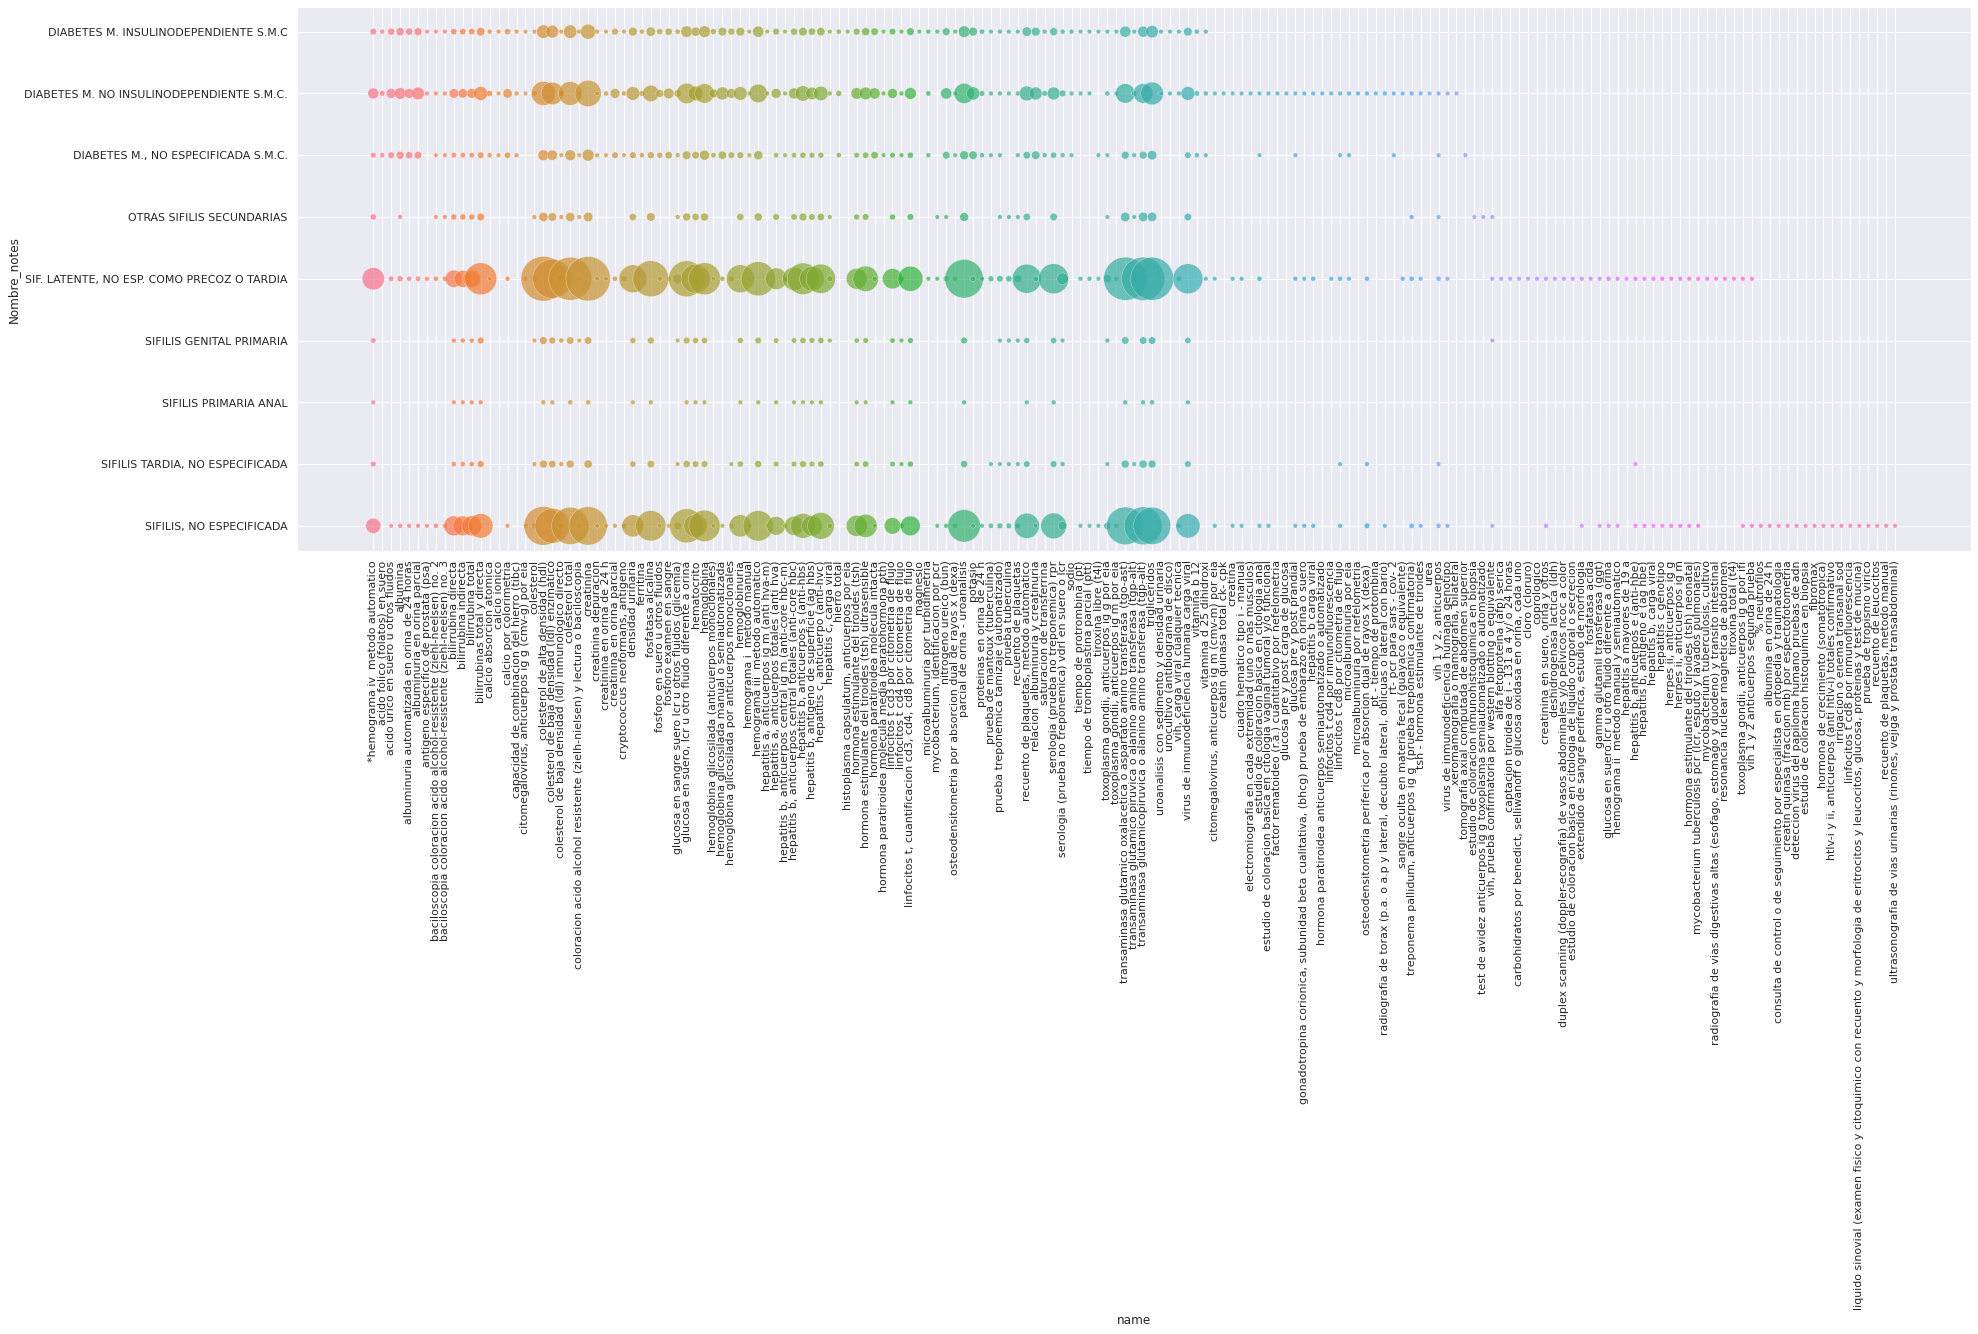

In [ ]:
fig, ax = plt.subplots(figsize = ( 30, 10 ))
_ = sns.scatterplot(data=nombres, y="Nombre_notes", x="name", hue='name', size="counts", alpha=0.7, legend=False, sizes=(20, 2000), ax=ax)
plt.xticks(rotation=90)
#plt.figure(figsize = (30,10))
ax.set_xlabel( "name" , size = 12 )
plt.show()

DIABETES M. INSULINODEPENDIENTE S.M.C


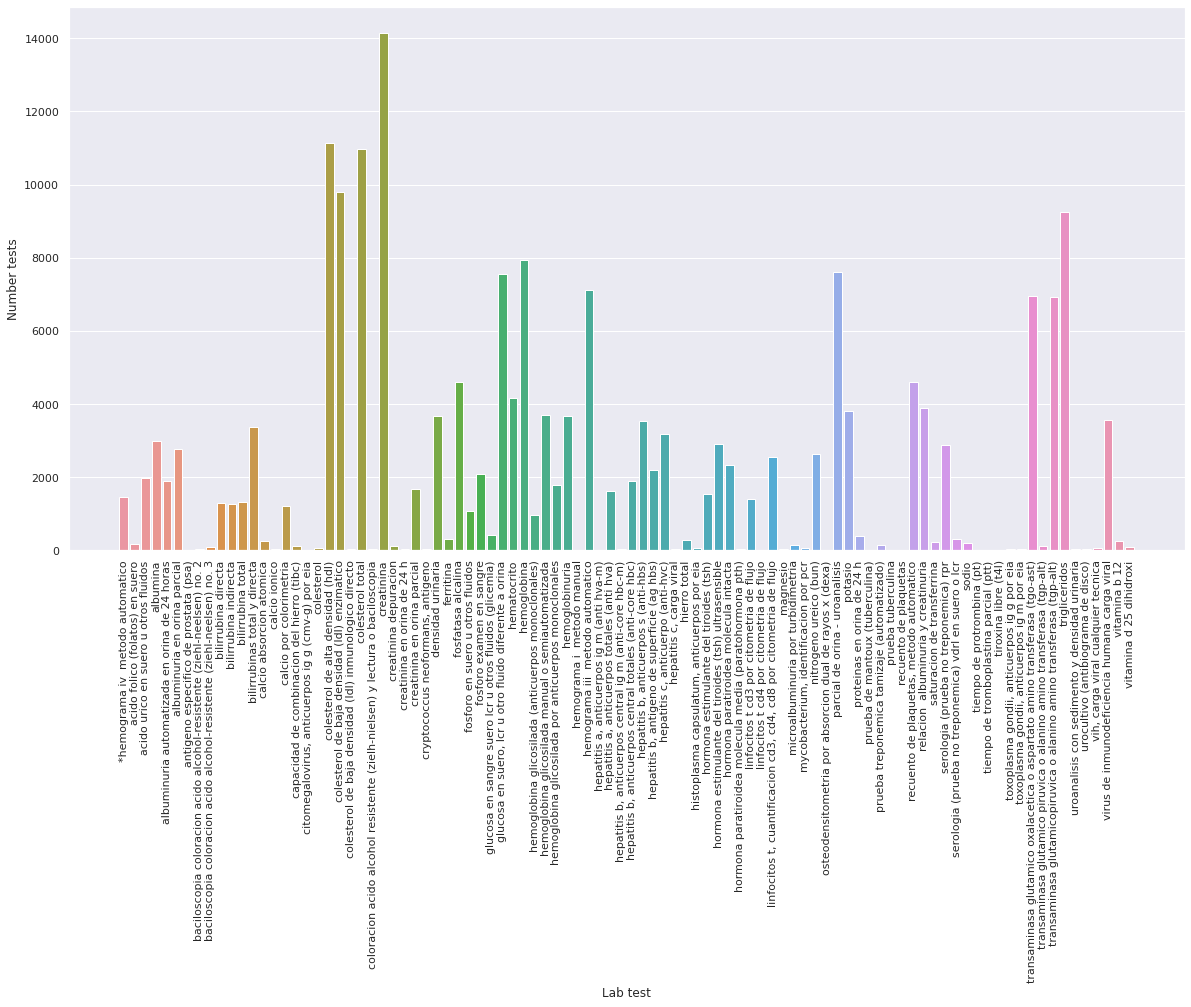

DIABETES M. NO INSULINODEPENDIENTE S.M.C.


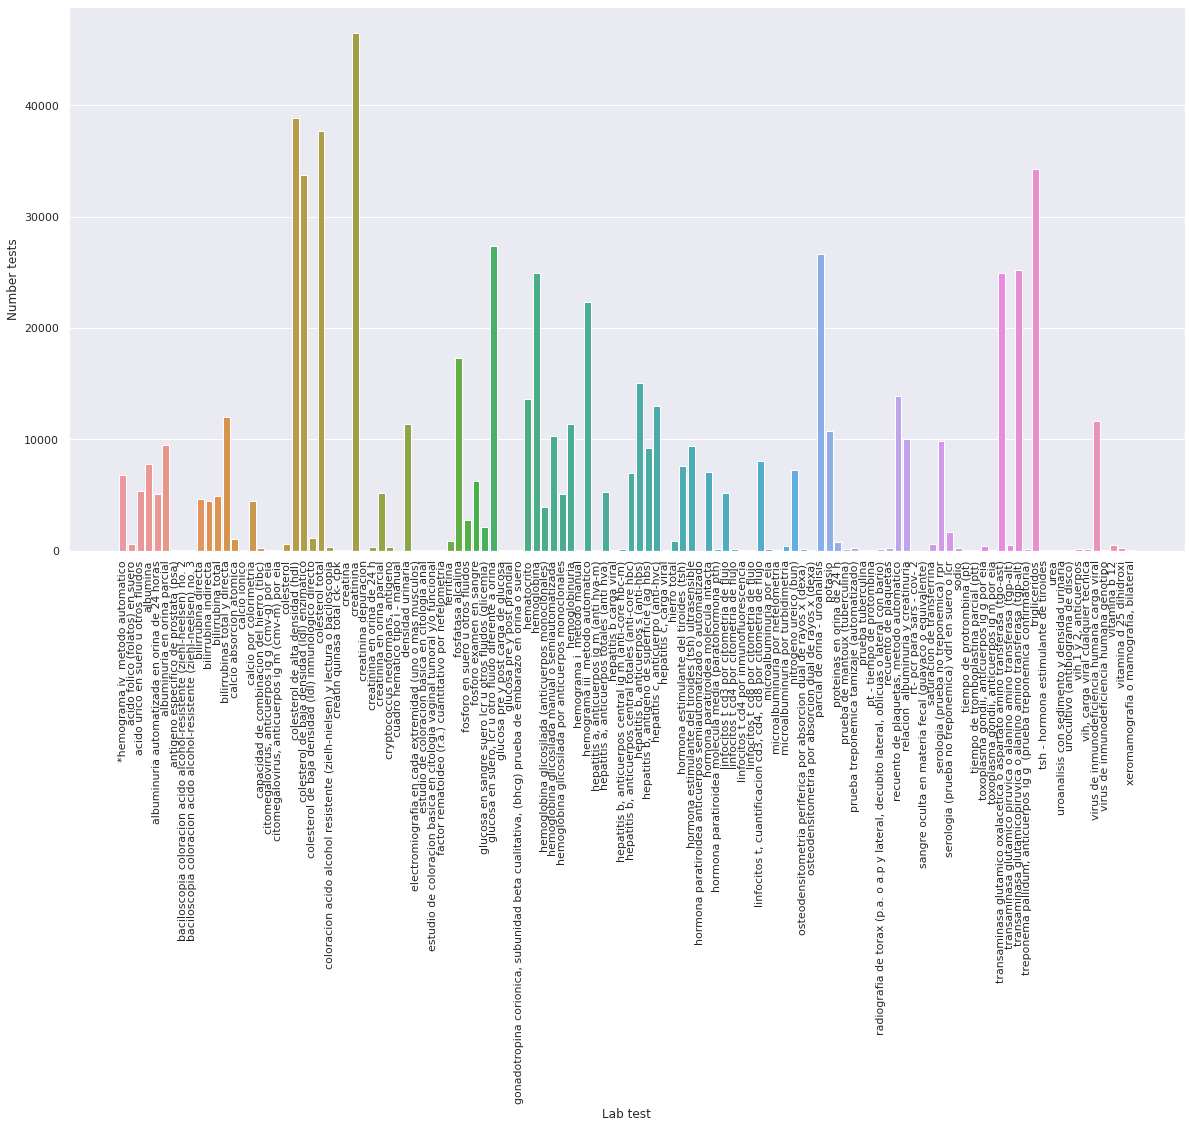

DIABETES M., NO ESPECIFICADA S.M.C.


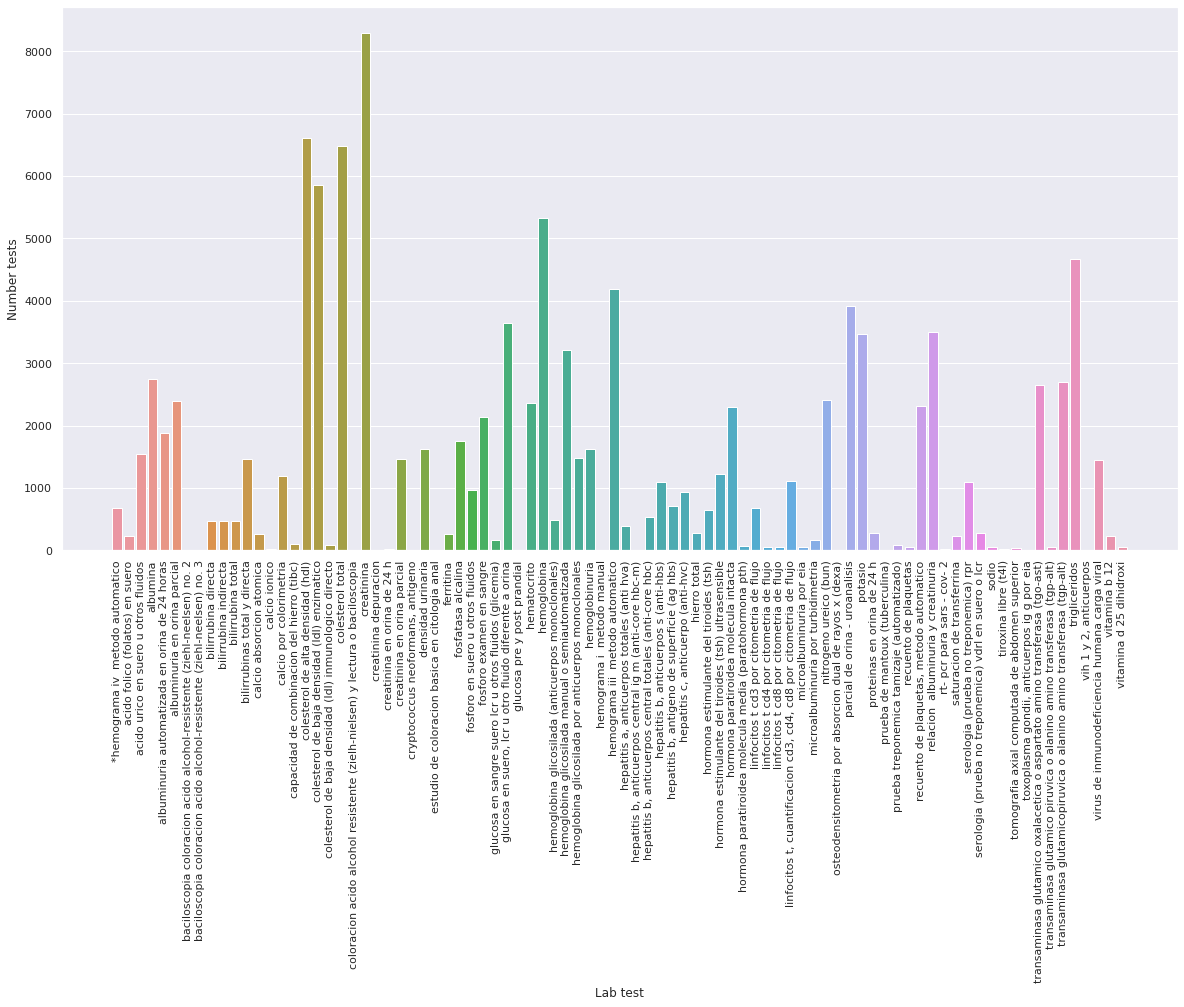

OTRAS SIFILIS SECUNDARIAS


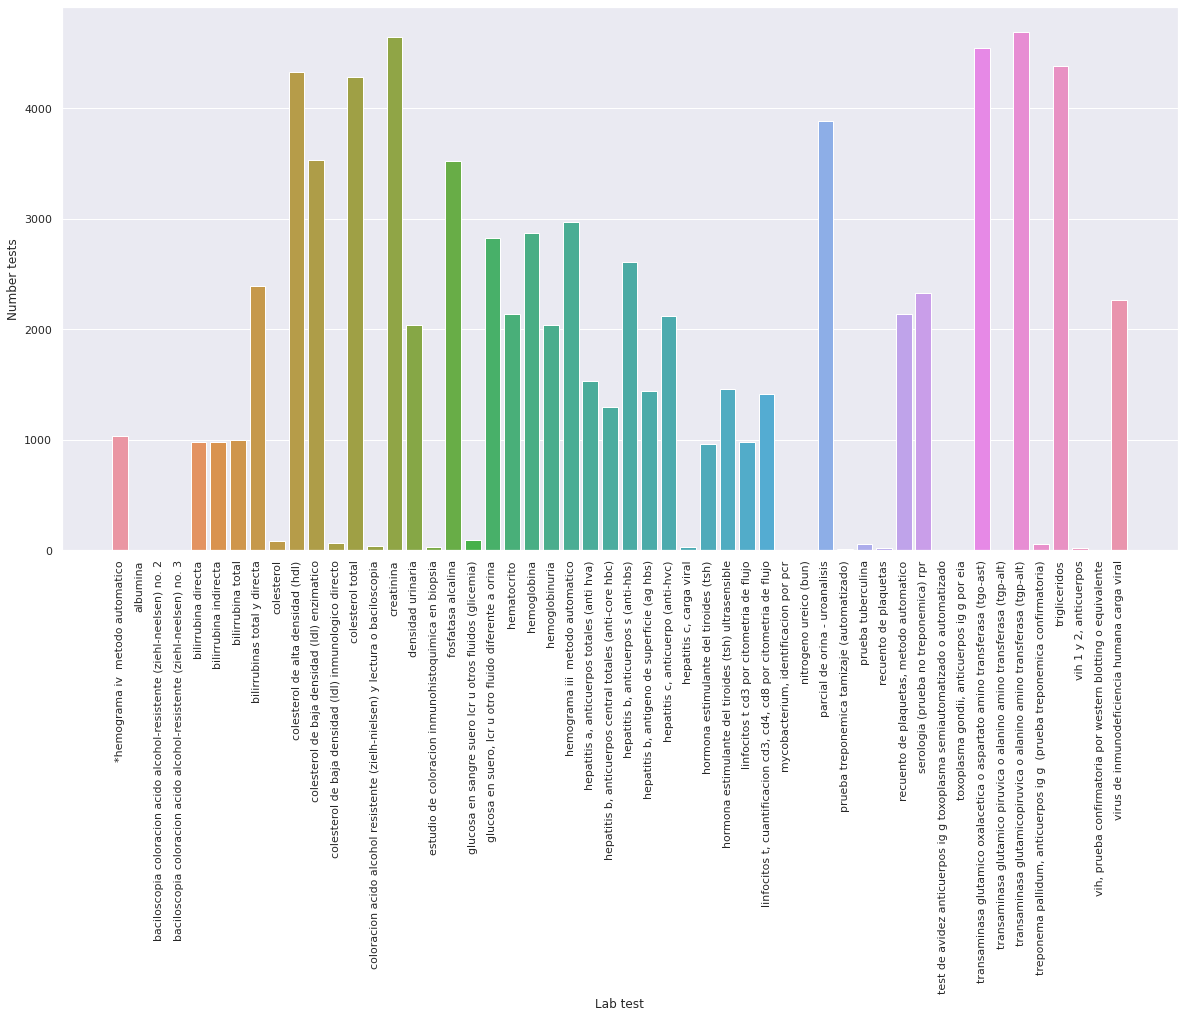

SIF. LATENTE, NO ESP. COMO PRECOZ O TARDIA


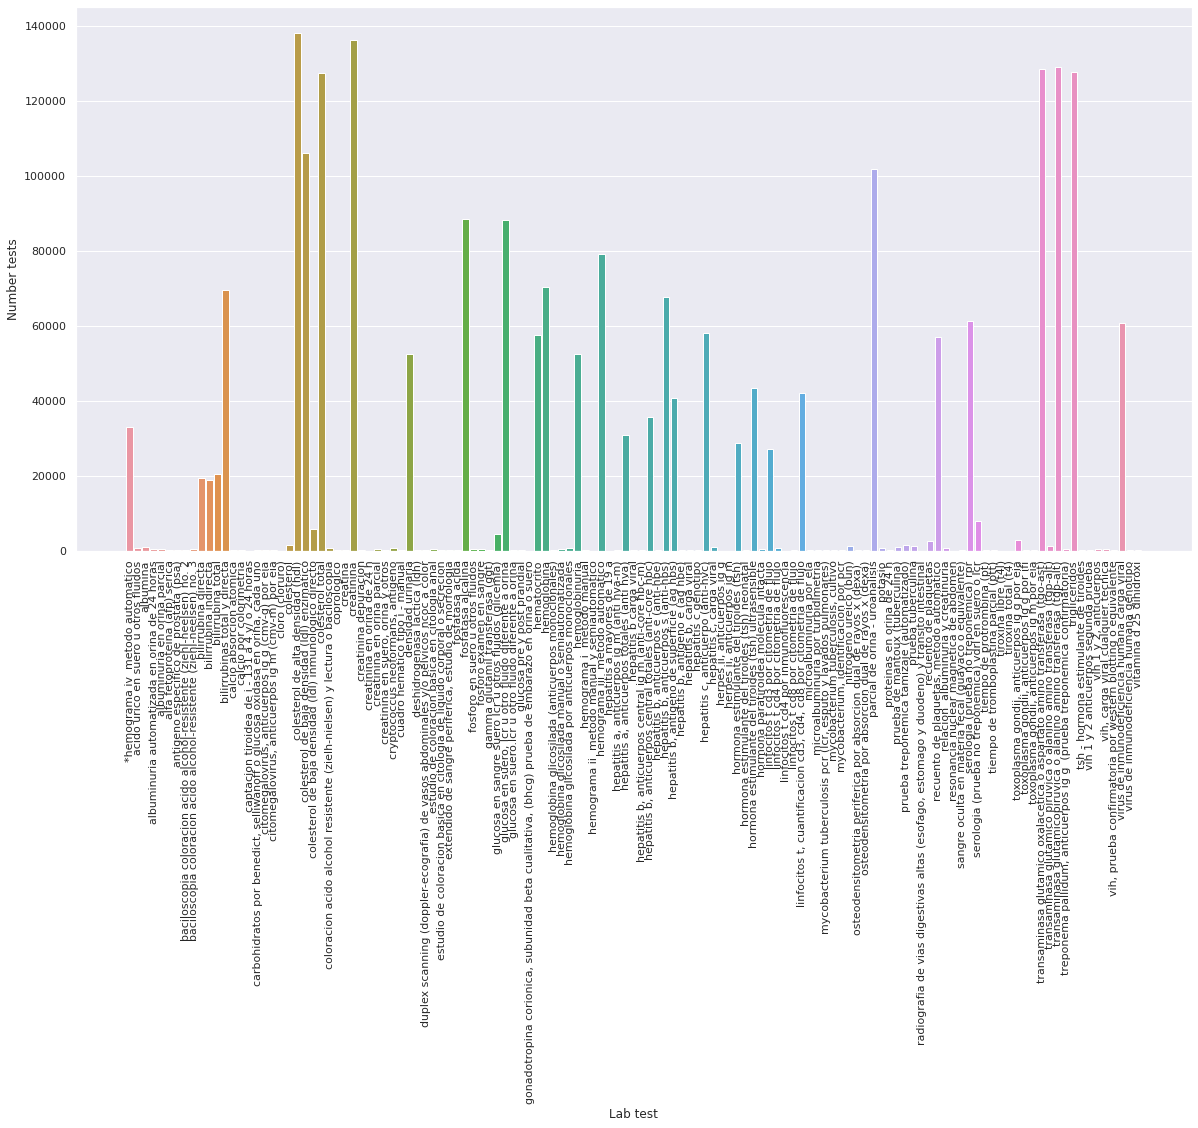

SIFILIS GENITAL PRIMARIA


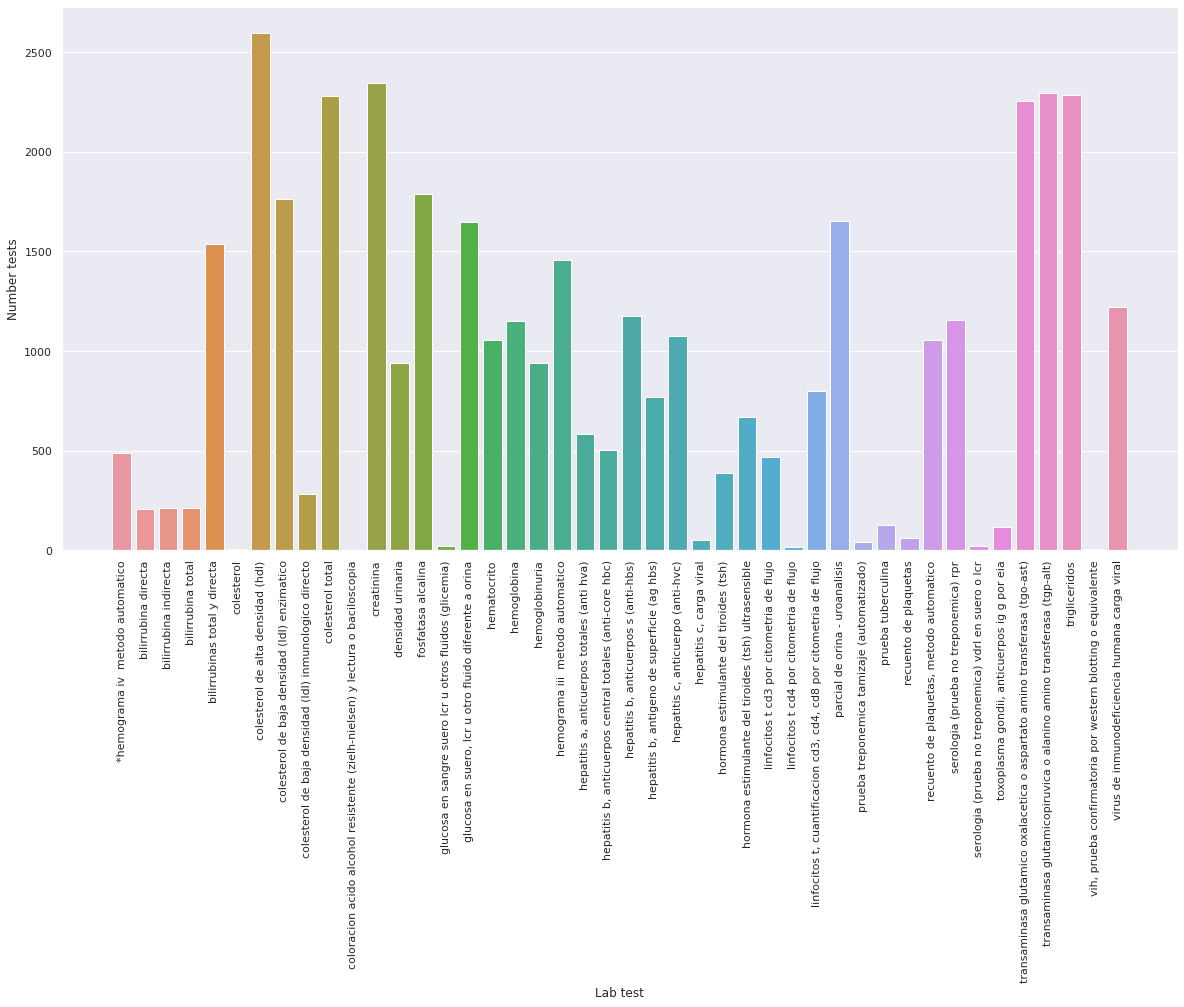

SIFILIS PRIMARIA ANAL


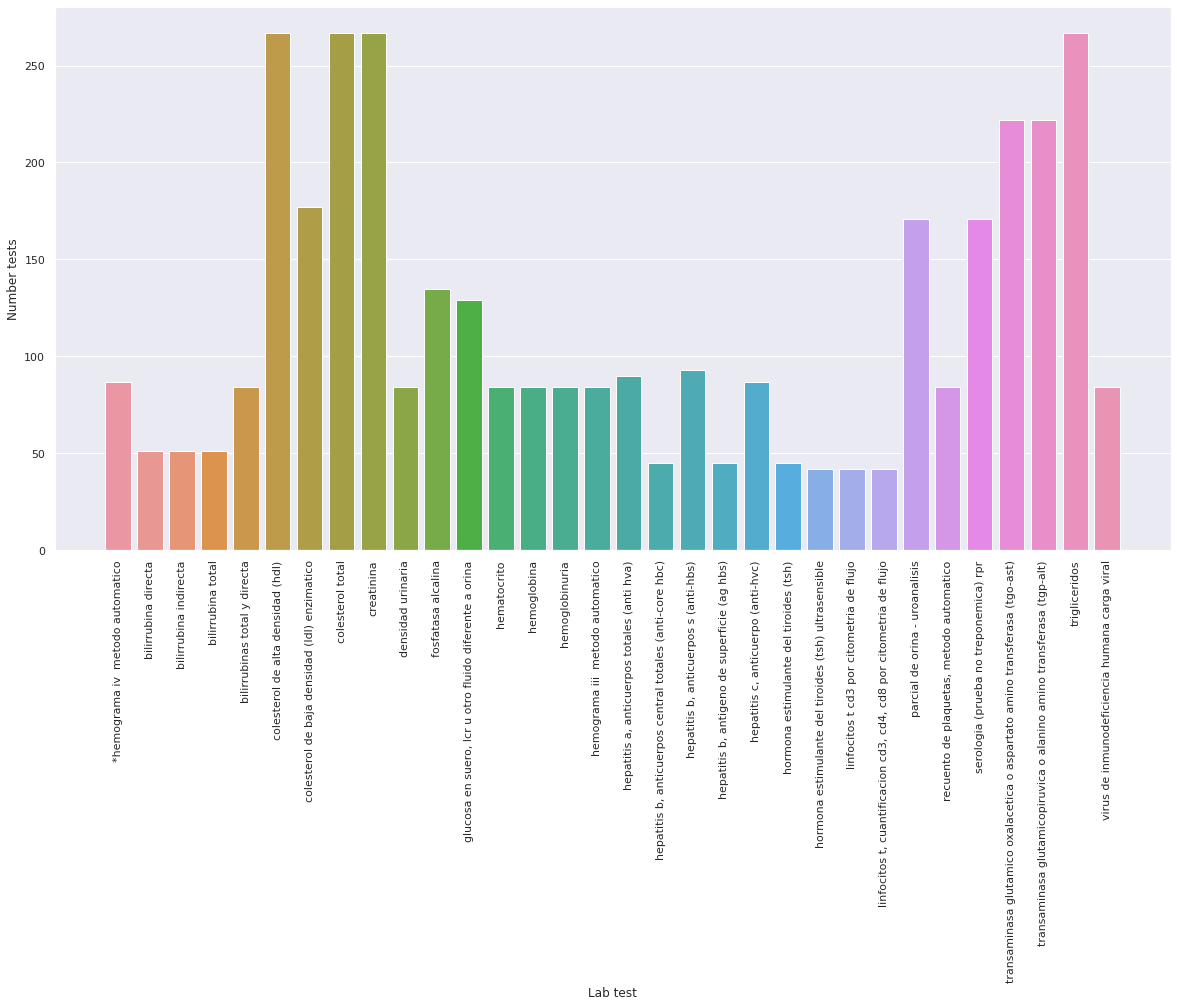

SIFILIS TARDIA, NO ESPECIFICADA


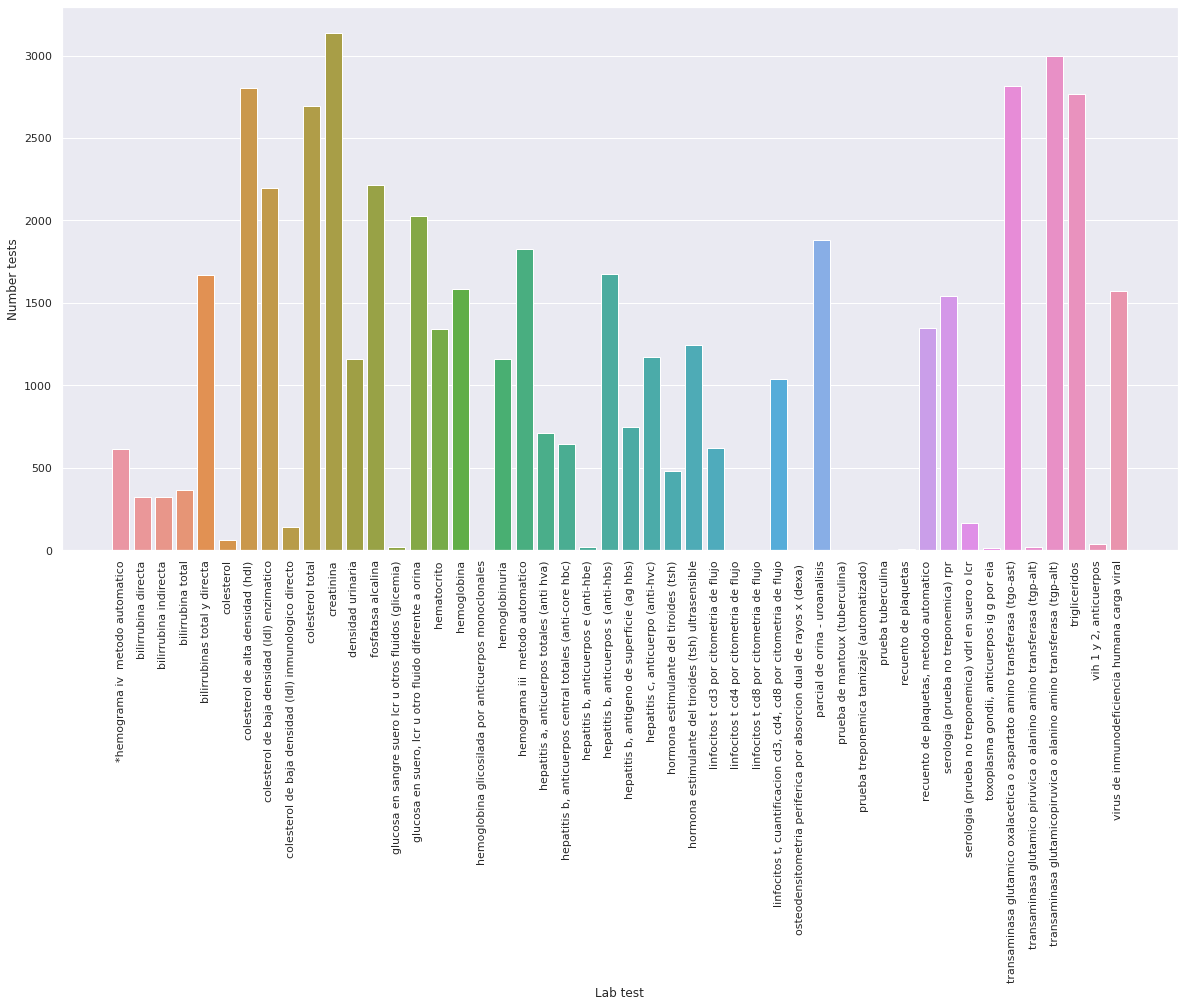

SIFILIS, NO ESPECIFICADA


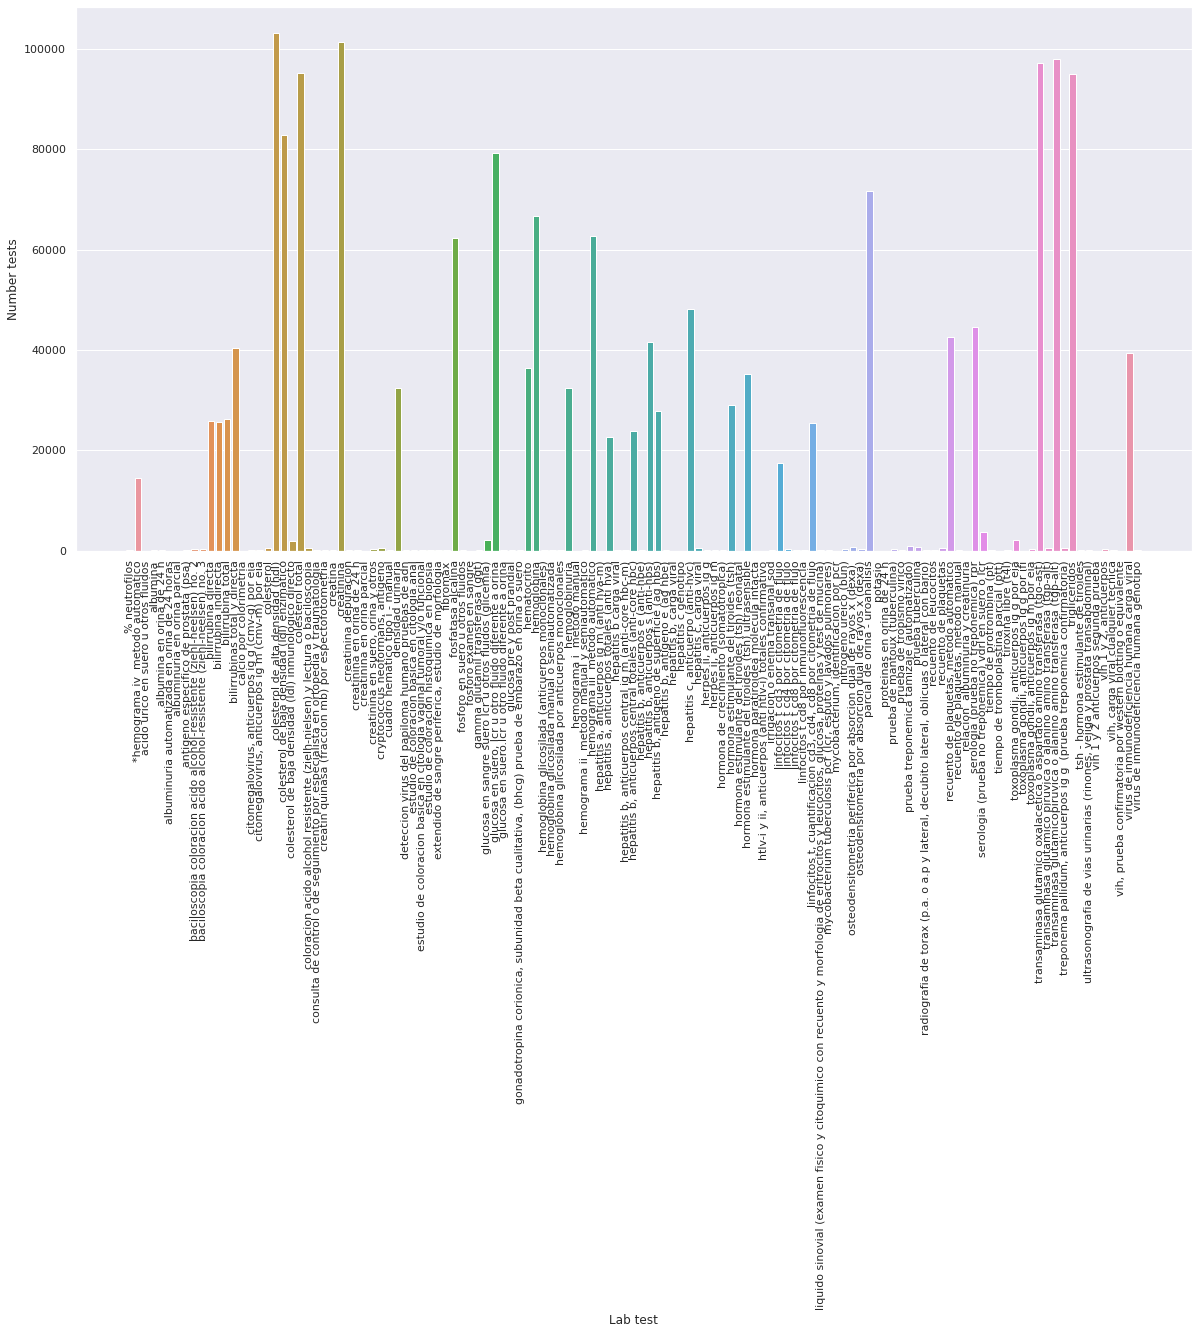

In [ ]:
def plot_bar(data, x, y, fig_size, rot, title, xlabel, ylabel):
    
    #ax = df_hour_boro[borough].plot.bar(figsize=(10,5), rot=0, title='Accidents per hour in ' + borough)
    #ax = data.plot.bar(figsize=fig_size, rot=rot, title=title)
    fig, ax = plt.subplots(figsize=fig_size)
    _ = sns.barplot(x=x, y=y, data=data, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.xticks(rotation=rot)
    ax.plot()
    plt.show()

# Plot the bar graph with the boroughs in the x-axis and number of accidents per square mile in the y-axis.
for note_name in nombres.index.get_level_values(0).unique().tolist():
    print(note_name)
    plot_bar(nombres[nombres.index == note_name], "name", "counts", (20,10), 90, note_name, "Lab test", "Number tests")

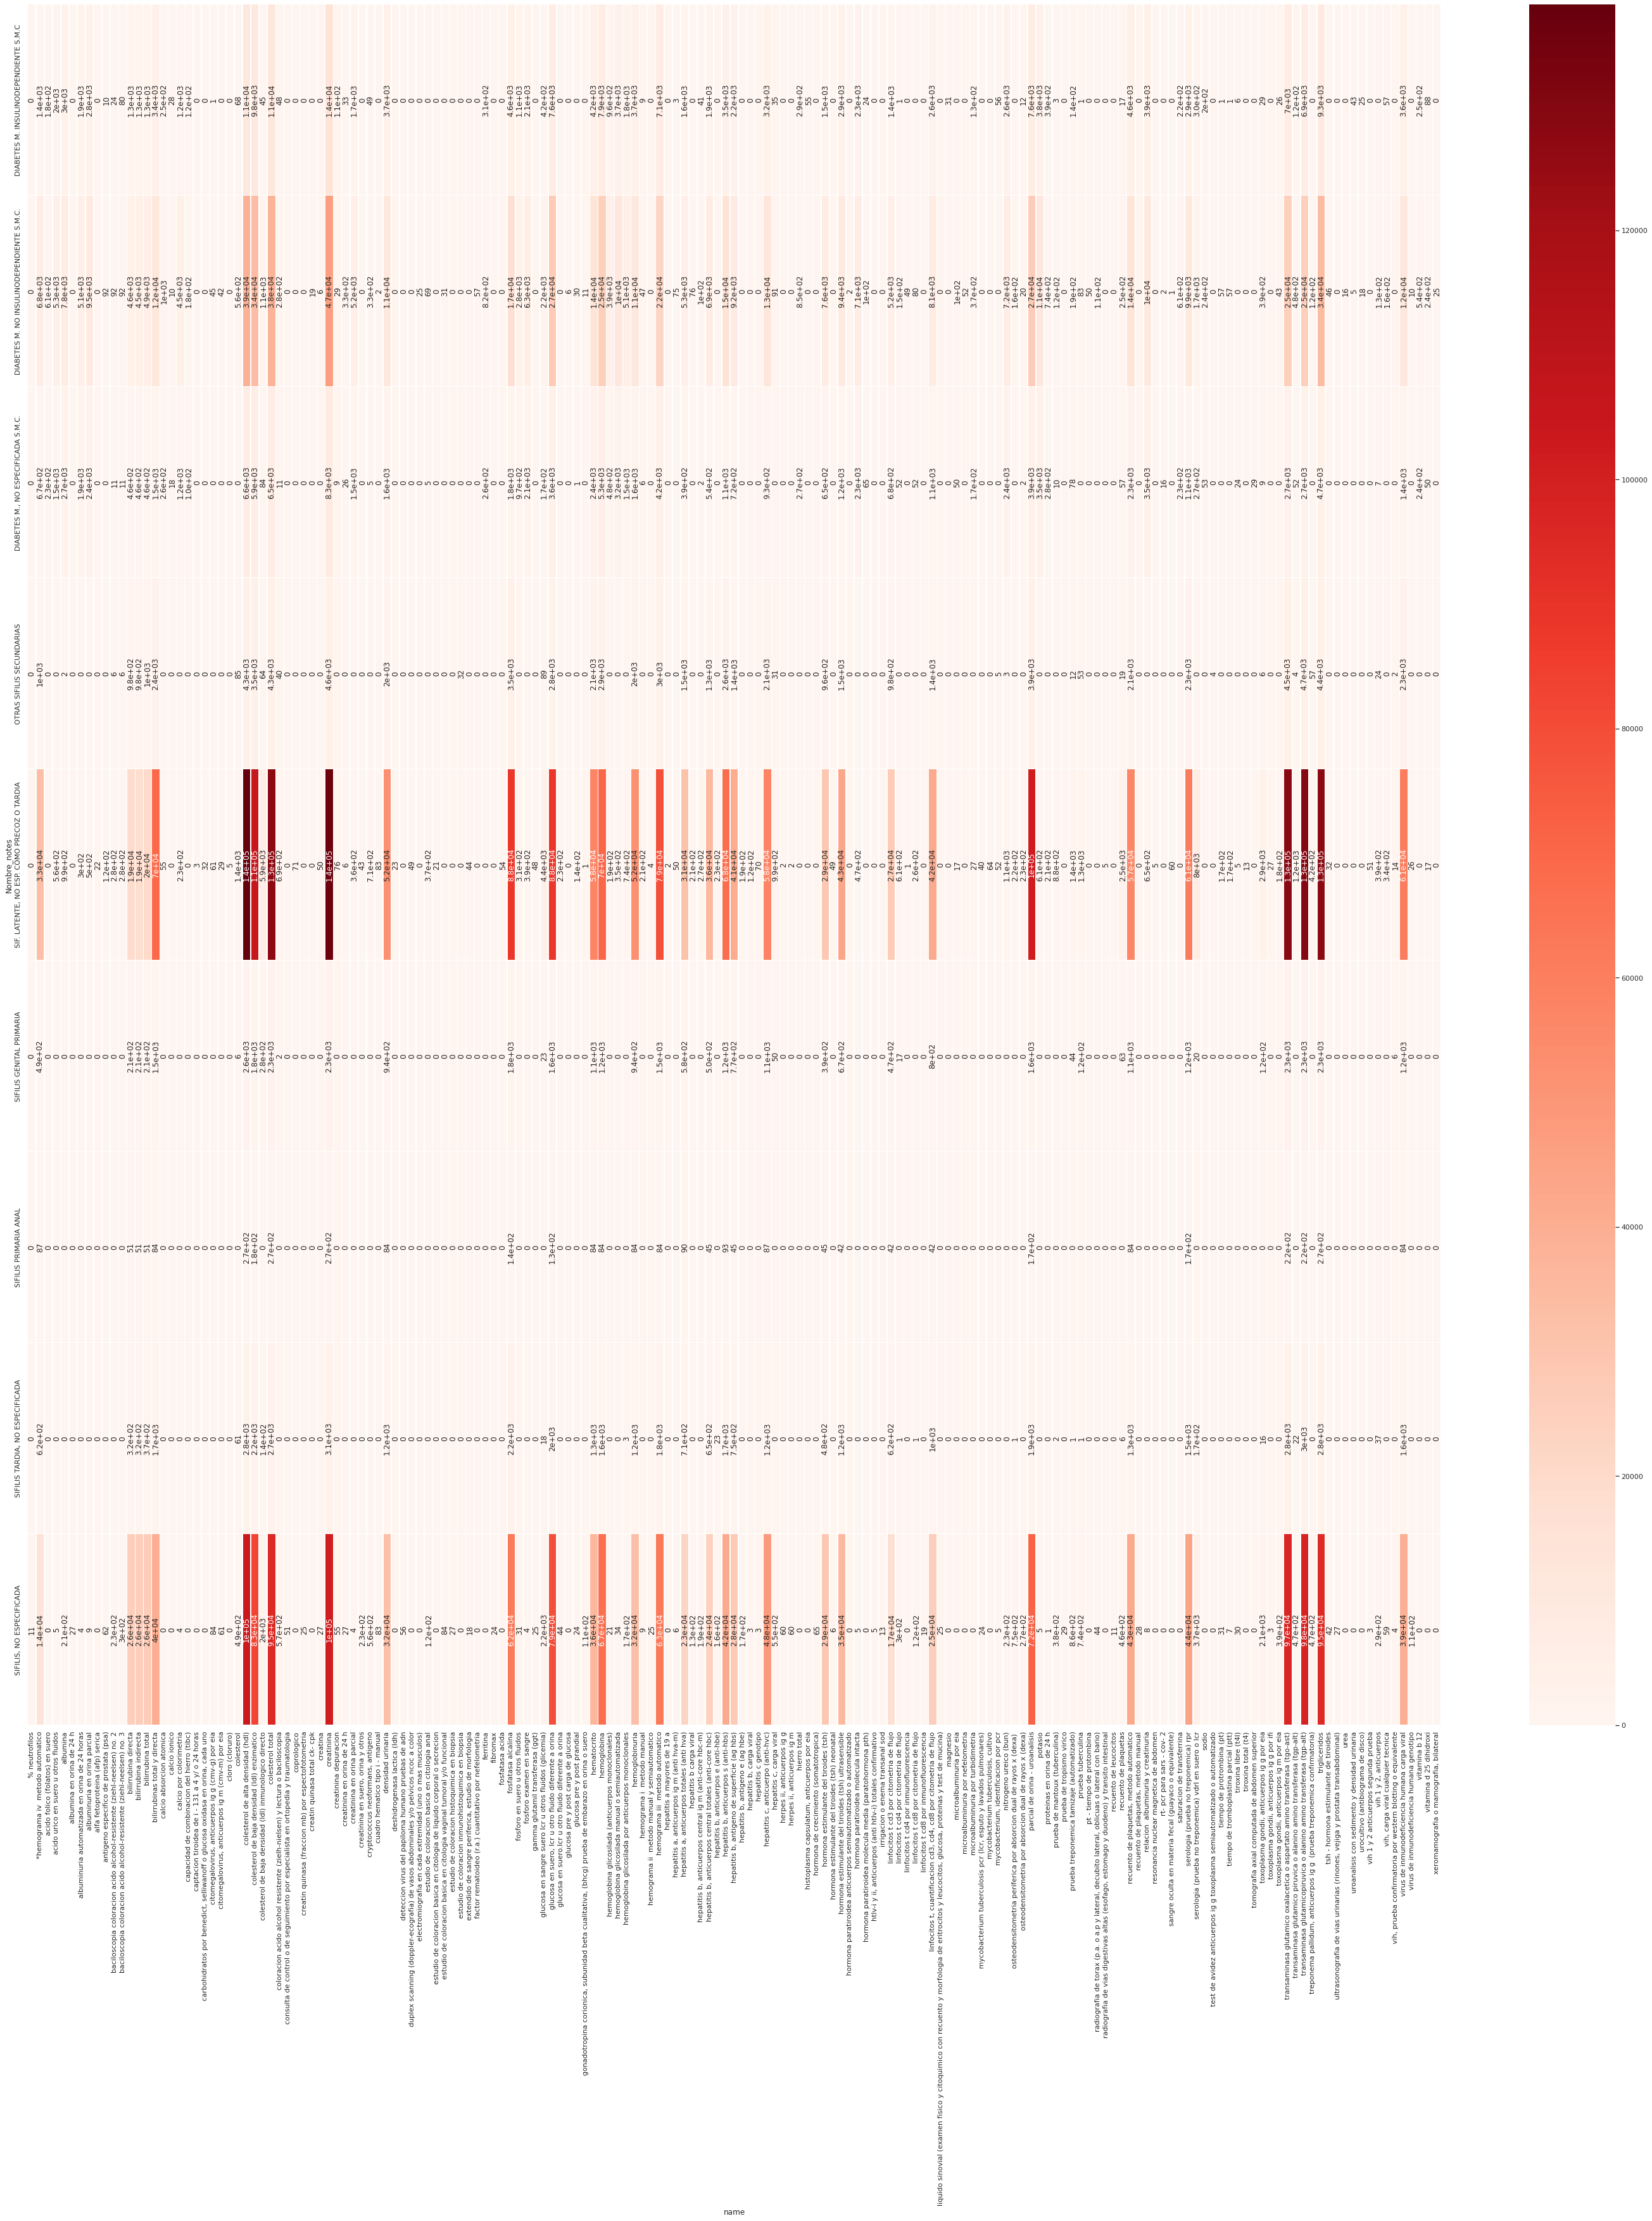

In [ ]:
nombres = nombres.reset_index()
crosstab_names = pd.crosstab(lab_notes_clean['Nombre_notes'], lab_notes_clean['name'])
fig, ax = plt.subplots(figsize=(50,50)) 
sns.heatmap(crosstab_names, annot=True, linewidths=.5, cmap='Reds', annot_kws={'rotation': 90}, ax=ax)

To be able to have smaller plots, we divide the data into Diabetes and Sifilis notes

In [ ]:
diabetes_df = lab_notes_clean[lab_notes_clean.Nombre_notes.str.contains('DIABETES', regex=False)]
sifilis_df = lab_notes_clean[lab_notes_clean.Nombre_notes.str.contains('SIF', regex=False)]

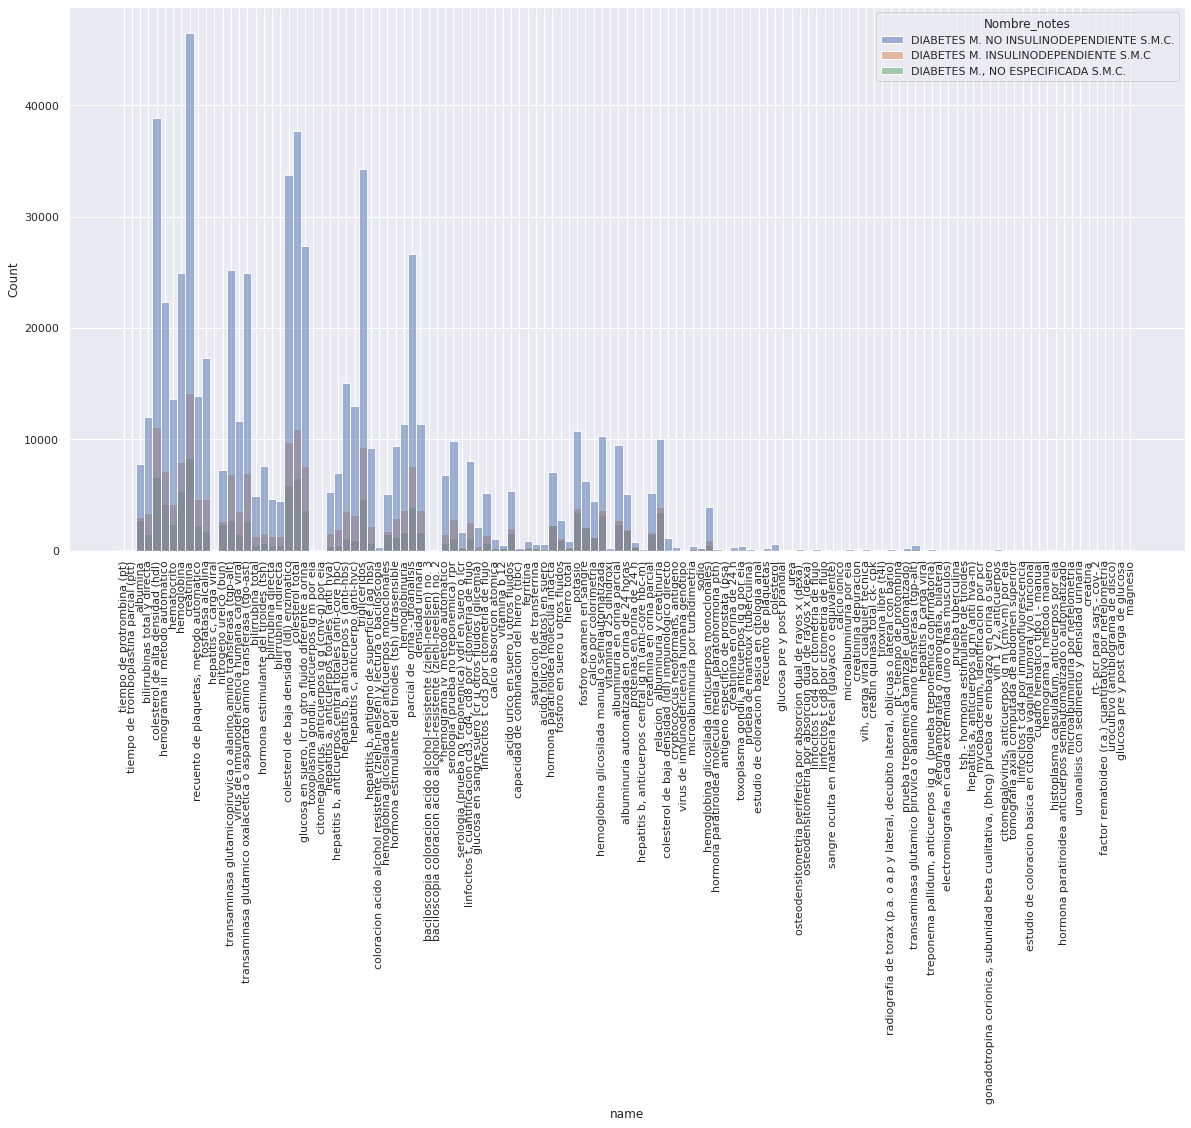

In [ ]:
sns.histplot(data=diabetes_df, x="name", hue='Nombre_notes')
plt.xticks(rotation=90)
plt.show()

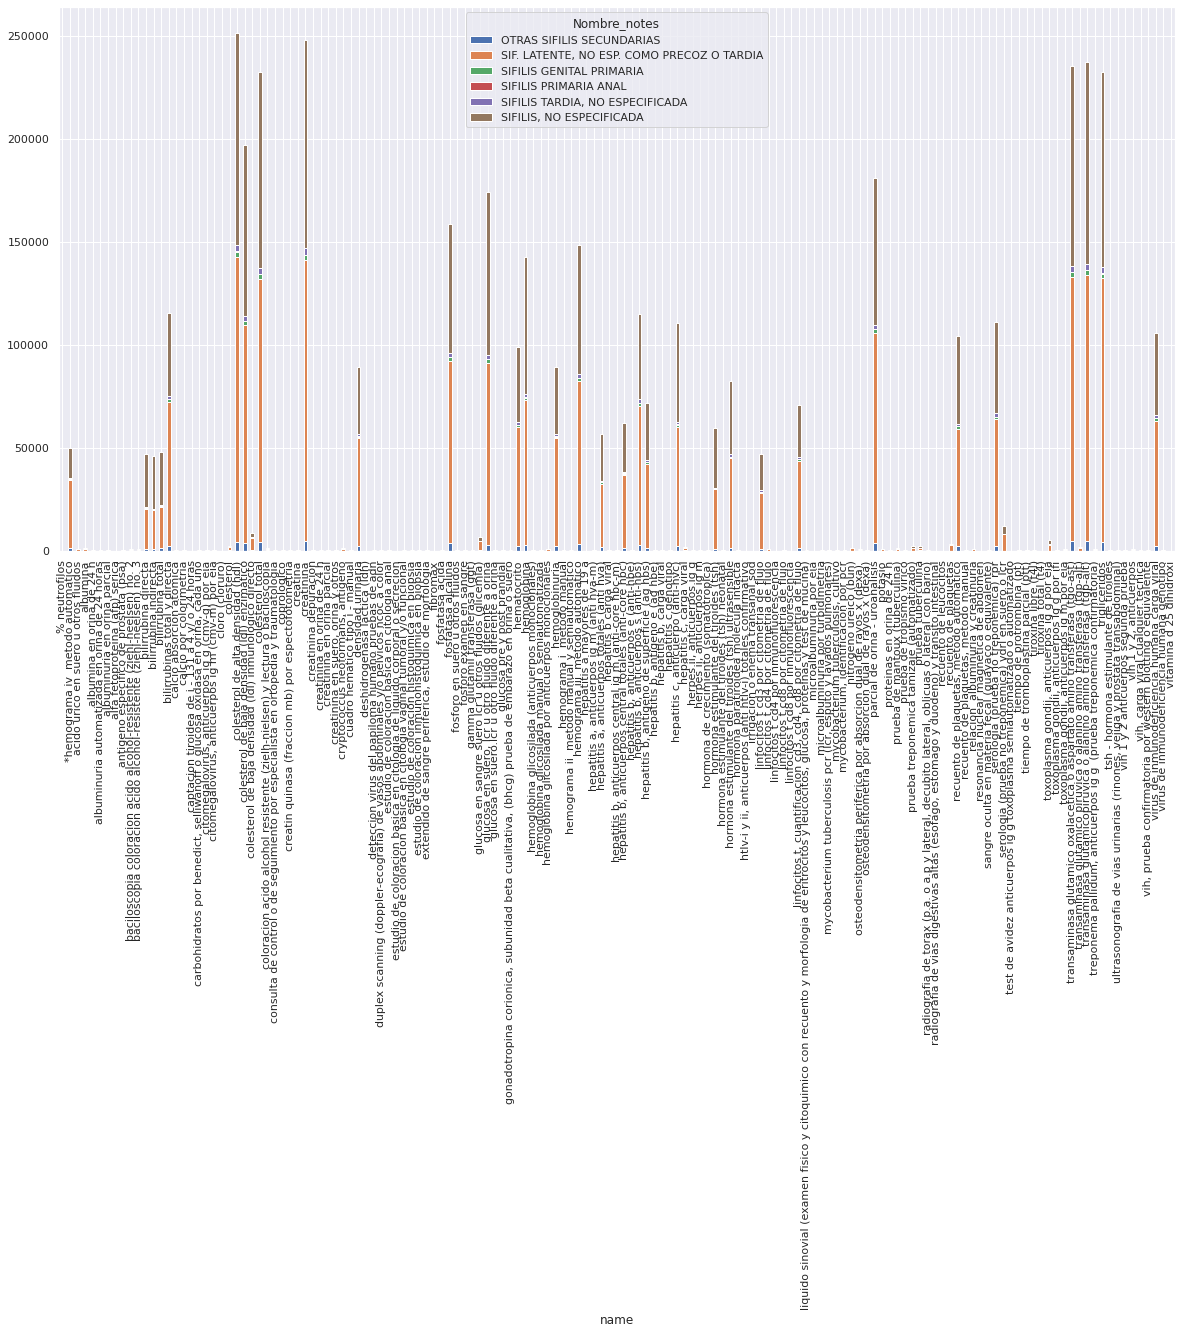

In [ ]:
sifilis_df.groupby(["name", "Nombre_notes"]).size().unstack().plot(kind='bar', stacked=True)

Finally lets see if we can take a look into the relation between people, names and dates

DIABETES M. INSULINODEPENDIENTE S.M.C


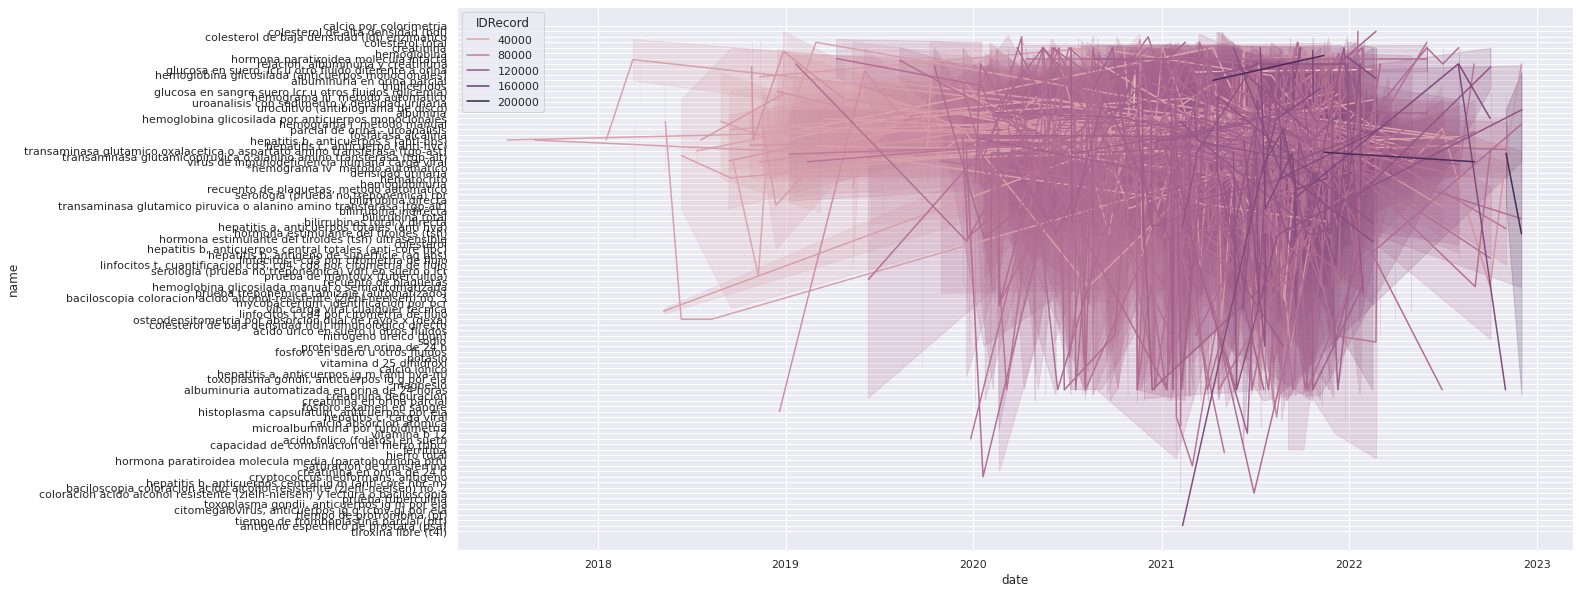

In [ ]:
lab_notes_clean['date'] = lab_notes_clean.Fecha.dt.date
data = lab_notes_clean.groupby(['Nombre_notes', 'IDRecord','name', 'date']).size().reset_index()
print(data.Nombre_notes.unique()[0])
sns.lineplot(data=data[data.Nombre_notes == data.Nombre_notes.unique()[0]], x="date", y="name", hue="IDRecord")

# Conclusions

- The datset is heavily unbalanced, featurewise and target class-wise.
- There are a total of 9 diseases that can be predicted on, that can be globbaly classified into Diabetes and Syphilis.
- There are some features which might need to be dropped, as there are too many missing values and they can't be recovered/input.
- A deeper analysis of the target feature and it's relationship with the EHR is needed to further understand the problem.